# Predicción de Series Temporales e-Waste mediante Redes Neuronales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

# PREDICCION POR DEPARTAMENTO

Cargamos nuestro Dataset por Departamento 2015-2020

In [2]:
#Data Original
Name = 'DEPARTAMENTO_GrpConsolidado'
#Carga archivo fuente para la predicción DEPARTAMENTO_GrpConsolidado.csv
datos = pd.read_csv(Name+'.csv',sep=';')
#Se crea una copy of the original data
datos_dep = datos.copy()
datos = datos.drop('DEPARTAMENTO',axis=1)
#Se define el año como indice
datos['ANIO'] = pd.to_datetime(datos['ANIO'], format='%Y')
datos = datos.set_index('ANIO')
datos = datos.sort_index()
datos

IDDEPARTAMENTO  GENERACION_TOTAL_KG
ANIO                                           
2015-01-01               0               470.00
2015-01-01               5            465967.03
2015-01-01              26             16540.01
2015-01-01              25              3922.00
2015-01-01               6              3177.00
...                    ...                  ...
2020-01-01              27             49835.43
2020-01-01              19              4676.22
2020-01-01              28               559.70
2020-01-01              21             30692.36
2020-01-01              32                23.00

[198 rows x 2 columns]

RECORRIDO, ENTRENAMIENTO Y PROYECCIÓN

In [36]:
columns = datos_dep['DEPARTAMENTO'].unique()
iddepto = datos_dep['IDDEPARTAMENTO'].unique()
# Definir Dataframe necesarios.
val_metodo =  pd.DataFrame()
df = datos.copy()
##range(len(iddepto))
#hasta = range(len(iddepto))
prcmse = 0
prcmape = 0
lprcmse = []
lprcmape = []
for p in range(len(iddepto)):
    print(p)
    df = datos[datos['IDDEPARTAMENTO'] == iddepto[p]]
    long = len(df)
    PASOS=2
        # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    # load dataset
    values = df.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, PASOS, 1)
    #reframed.head()
    
    # Dividimos en set de Entrenamiento y Validación
    values = reframed.values
    n_train_days = long - (3+PASOS)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    
    #Creamos la red neuronal Feedforward
    def crear_modeloFF():
        model = Sequential() 
        model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
        model.add(Flatten())
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse","mape"])
        model.summary()
        return model
    
    #Entrenamos la red con 40 ciclos
    EPOCHS=40
    model = crear_modeloFF()
    history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)
    
    prcmse = sum(history.history['mse'])/EPOCHS
    lprcmse.append(prcmse)
    prcmape = sum(history.history['mape'])/EPOCHS
    lprcmape.append(prcmape)
    
    results=model.predict(x_val)
    
    compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
    compara.columns = ['real', 'prediccion']

    inverted = scaler.inverse_transform(compara.values)

    compara2 = pd.DataFrame(inverted)
    compara2.columns = ['real', 'prediccion']
    compara2['diferencia'] = compara2['real'] - compara2['prediccion']
    #compara2.head()
    
    #A partir de los dos ultimos años (2019-2020) preparamos los datos para Test
    ultimosDias = df['2019-01-01':'2020-01-01']
    ultimosDias
    values = ultimosDias.values
    values = values.astype('float32')
    # normalize features
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
    #reframed.head(7)
    
    values = reframed.values
    x_test = values[1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    x_test

    def agregarNuevoValor(x_test,nuevoValor):
        for i in range(x_test.shape[2]-1):
            x_test[0][0][i] = x_test[0][0][i+1]
        x_test[0][0][x_test.shape[2]-1]=nuevoValor
        return x_test
    
    #Pronóstico de los 5 años posteriores (2021-2025)
    results=[]
    for i in range(5):
        parcial=model.predict(x_test)
        results.append(parcial[0])
        print(x_test)
        x_test=agregarNuevoValor(x_test,parcial[0])

    adimen = [x for x in results]    
    print(adimen)
    inverted = scaler.inverse_transform(adimen)
    inverted

    prediccion5años = pd.DataFrame(inverted)
    prediccion5años.columns = ['pronostico']
    prediccion5años =  round(prediccion5años, 2)
    
    #Agregamos el resultado del pronostico en el dataset
    i=0
    for fila in prediccion5años.pronostico:
        i=i+1
        ultimosDias.loc['202' + str(i)+'-01-01'] = fila
        ANIO = '202'+ str(i)+'-01-01'
        datos_dep = datos_dep.append({'DEPARTAMENTO' : columns[p],'IDDEPARTAMENTO' : iddepto[p],'ANIO' : '202' + str(i), 'GENERACION_TOTAL_KG' : round(float(fila),3)}, ignore_index=True)

0
(1, 1, 2) (1,) (9, 1, 2) (9,)
Model: "sequential_168"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_336 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_168 (Flatten)       (None, 2)                 0         
                                                                 
 dense_337 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4364 - mse: 2.0632 - mape: 143.6380 - val_loss: 0.4205 - val_mse: 0.2019 - val_mape: 45.6561
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4327 - mse: 2.0526 - mape: 143.2705 - val_loss: 0.419

Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_338 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_169 (Flatten)       (None, 2)                 0         
                                                                 
 dense_339 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 817ms/step - loss: 1.5544 - mse: 2.4163 - mape: 155.4439 - val_loss: 1.0023 - val_mse: 1.1731 - val_mape: 207.5792
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.5518 - mse: 2.4080 - mape: 155.1776 - val_loss: 1.0004 - val_mse: 1.1686 - val_mape: 207.1549
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5491 - mse: 2.3997 - mape: 154.9102 - val_loss: 0.9986 - val_mse: 1.1640 - val_mape: 206.7288
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.5464 - mse: 2.3914 - mape: 154.6418 - val_loss: 0.9967 - val_mse: 1.1594 - val_mape: 206.3010
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5437 - mse: 2.3831 - mape: 154.3723 - val_loss: 0.9948 - val_mse: 1.1548 - val_mape: 205.8714
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 1.5410 - mse: 2.3747 - mape: 154.1017 - val_loss: 0.9930 - val_mse: 1.1503 - val_mape: 205.4399
Epoch 7/

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.4270 - mse: 0.1823 - mape: 42.6959 - val_loss: 0.5032 - val_mse: 0.2837 - val_mape: 965.0063
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4243 - mse: 0.1800 - mape: 42.4313 - val_loss: 0.5029 - val_mse: 0.2837 - val_mape: 963.5890
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4217 - mse: 0.1778 - mape: 42.1683 - val_loss: 0.5027 - val_mse: 0.2837 - val_mape: 962.1648
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4191 - mse: 0.1756 - mape: 41.9069 - val_loss: 0.5025 - val_mse: 0.2836 - val_mape: 960.7336
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4165 - mse: 0.1734 - mape: 41.6471 - val_loss: 0.5022 - val_mse: 0.2836 - val_mape: 959.2959
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4139 - mse: 0.1713 - mape: 41.3889 - val_loss: 0.5020 - val_mse: 0.2837 - val_mape: 957.8514
Epoch 7/40
1/1 [=

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 813ms/step - loss: 0.8868 - mse: 0.7863 - mape: 89.1685 - val_loss: 0.9762 - val_mse: 1.1222 - val_mape: 167.6344
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8827 - mse: 0.7792 - mape: 88.7622 - val_loss: 0.9741 - val_mse: 1.1186 - val_mape: 167.6653
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8787 - mse: 0.7721 - mape: 88.3562 - val_loss: 0.9719 - val_mse: 1.1150 - val_mape: 167.6948
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.8746 - mse: 0.7650 - mape: 87.9507 - val_loss: 0.9698 - val_mse: 1.1114 - val_mape: 167.7230
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8706 - mse: 0.7580 - mape: 87.5456 - val_loss: 0.9676 - val_mse: 1.1078 - val_mape: 167.7499
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8666 - mse: 0.7510 - mape: 87.1410 - val_loss: 0.9654 - val_mse: 1.1043 - val_mape: 167.7756
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 949ms/step - loss: 0.7932 - mse: 0.6292 - mape: 79.3216 - val_loss: 0.6631 - val_mse: 0.5861 - val_mape: 91.9531
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7877 - mse: 0.6205 - mape: 78.7712 - val_loss: 0.6605 - val_mse: 0.5836 - val_mape: 91.4851
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7822 - mse: 0.6119 - mape: 78.2223 - val_loss: 0.6578 - val_mse: 0.5811 - val_mape: 91.0176
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7768 - mse: 0.6033 - mape: 77.6750 - val_loss: 0.6552 - val_mse: 0.5786 - val_mape: 90.5509
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7713 - mse: 0.5949 - mape: 77.1294 - val_loss: 0.6526 - val_mse: 0.5761 - val_mape: 90.0849
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7659 - mse: 0.5865 - mape: 76.5856 - val_loss: 0.6499 - val_mse: 0.5737 - val_mape: 89.6196
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.7876 - mse: 3.1954 - mape: 178.7571 - val_loss: 0.9533 - val_mse: 1.4120 - val_mape: 121.0624
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7863 - mse: 3.1909 - mape: 178.6314 - val_loss: 0.9521 - val_mse: 1.4091 - val_mape: 120.8246
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7850 - mse: 3.1864 - mape: 178.5049 - val_loss: 0.9509 - val_mse: 1.4062 - val_mape: 120.5865
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7838 - mse: 3.1819 - mape: 178.3778 - val_loss: 0.9496 - val_mse: 1.4033 - val_mape: 120.3483
Epoch 5/40
1/1 [==============================] - 0s 54ms/step - loss: 1.7825 - mse: 3.1773 - mape: 178.2499 - val_loss: 0.9484 - val_mse: 1.4004 - val_mape: 120.1097
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.7812 - mse: 3.1727 - mape: 178.1213 - val_loss: 0.9472 - val_mse: 1.3975 - val_mape: 119.8708
Epoch 7/40


Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 920ms/step - loss: 1.0840 - mse: 1.1752 - mape: 108.4044 - val_loss: 0.7428 - val_mse: 0.7442 - val_mape: 112.0721
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0819 - mse: 1.1706 - mape: 108.1935 - val_loss: 0.7414 - val_mse: 0.7421 - val_mape: 111.5021
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0798 - mse: 1.1660 - mape: 107.9834 - val_loss: 0.7401 - val_mse: 0.7401 - val_mape: 110.9350
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0777 - mse: 1.1615 - mape: 107.7743 - val_loss: 0.7387 - val_mse: 0.7381 - val_mape: 110.3708
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0757 - mse: 1.1570 - mape: 107.5662 - val_loss: 0.7373 - val_mse: 0.7361 - val_mape: 109.8094
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0736 - mse: 1.1526 - mape: 107.3591 - val_loss: 0.7359 - val_mse: 0.7341 - val_mape: 109.2510
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 832ms/step - loss: 0.7886 - mse: 0.6219 - mape: 78.8629 - val_loss: 0.6215 - val_mse: 0.5797 - val_mape: 91.2477
Epoch 2/40
1/1 [==============================] - 0s 53ms/step - loss: 0.7855 - mse: 0.6170 - mape: 78.5495 - val_loss: 0.6207 - val_mse: 0.5778 - val_mape: 91.4079
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7824 - mse: 0.6121 - mape: 78.2358 - val_loss: 0.6199 - val_mse: 0.5759 - val_mape: 91.5678
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7792 - mse: 0.6072 - mape: 77.9219 - val_loss: 0.6190 - val_mse: 0.5741 - val_mape: 91.7273
Epoch 5/40
1/1 [==============================] - 0s 34ms/step - loss: 0.7761 - mse: 0.6023 - mape: 77.6077 - val_loss: 0.6182 - val_mse: 0.5722 - val_mape: 91.8865
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7729 - mse: 0.5974 - mape: 77.2933 - val_loss: 0.6174 - val_mse: 0.5704 - val_mape: 92.0452
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.0397 - mse: 1.0809 - mape: 103.9686 - val_loss: 0.7615 - val_mse: 0.7014 - val_mape: 99.1065
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0365 - mse: 1.0744 - mape: 103.6512 - val_loss: 0.7597 - val_mse: 0.6988 - val_mape: 98.7823
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0333 - mse: 1.0678 - mape: 103.3335 - val_loss: 0.7579 - val_mse: 0.6961 - val_mape: 98.4581
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0302 - mse: 1.0612 - mape: 103.0158 - val_loss: 0.7561 - val_mse: 0.6935 - val_mape: 98.1340
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0270 - mse: 1.0547 - mape: 102.6980 - val_loss: 0.7543 - val_mse: 0.6909 - val_mape: 97.8100
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0238 - mse: 1.0482 - mape: 102.3800 - val_loss: 0.7524 - val_mse: 0.6883 - val_mape: 97.4861
Epoch 7/40
1/1 [=

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 805ms/step - loss: 0.2198 - mse: 0.0483 - mape: 22.8748 - val_loss: 0.3491 - val_mse: 0.2370 - val_mape: 61.6822
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2171 - mse: 0.0471 - mape: 22.5924 - val_loss: 0.3486 - val_mse: 0.2381 - val_mape: 61.8038
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2144 - mse: 0.0460 - mape: 22.3124 - val_loss: 0.3481 - val_mse: 0.2392 - val_mape: 61.9248
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2117 - mse: 0.0448 - mape: 22.0349 - val_loss: 0.3477 - val_mse: 0.2403 - val_mape: 62.0452
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2091 - mse: 0.0437 - mape: 21.7599 - val_loss: 0.3472 - val_mse: 0.2415 - val_mape: 62.1649
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2065 - mse: 0.0426 - mape: 21.4873 - val_loss: 0.3468 - val_mse: 0.2426 - val_mape: 62.2839
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 896ms/step - loss: 0.0460 - mse: 0.0021 - mape: 4.5957 - val_loss: 0.4027 - val_mse: 0.3087 - val_mape: 382.6367
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.0455 - mse: 0.0021 - mape: 4.5497 - val_loss: 0.4024 - val_mse: 0.3087 - val_mape: 382.5973
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0450 - mse: 0.0020 - mape: 4.5043 - val_loss: 0.4022 - val_mse: 0.3087 - val_mape: 382.5582
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 0.0446 - mse: 0.0020 - mape: 4.4594 - val_loss: 0.4020 - val_mse: 0.3087 - val_mape: 382.5192
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0441 - mse: 0.0019 - mape: 4.4149 - val_loss: 0.4018 - val_mse: 0.3087 - val_mape: 382.4804
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0437 - mse: 0.0019 - mape: 4.3710 - val_loss: 0.4016 - val_mse: 0.3087 - val_mape: 382.4418
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.7103 - mse: 2.9251 - mape: 171.0294 - val_loss: 1.3520 - val_mse: 1.9418 - val_mape: 1260.4323
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7077 - mse: 2.9161 - mape: 170.7654 - val_loss: 1.3505 - val_mse: 1.9374 - val_mape: 1259.8949
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7050 - mse: 2.9070 - mape: 170.4995 - val_loss: 1.3489 - val_mse: 1.9329 - val_mape: 1259.3564
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.7023 - mse: 2.8979 - mape: 170.2317 - val_loss: 1.3474 - val_mse: 1.9284 - val_mape: 1258.8180
Epoch 5/40
1/1 [==============================] - 0s 54ms/step - loss: 1.6996 - mse: 2.8887 - mape: 169.9619 - val_loss: 1.3458 - val_mse: 1.9239 - val_mape: 1258.2792
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 1.6969 - mse: 2.8795 - mape: 169.6900 - val_loss: 1.3442 - val_mse: 1.9194 - val_mape: 1257.7399
Epoch

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 788ms/step - loss: 1.0234 - mse: 1.0474 - mape: 102.3410 - val_loss: 0.6750 - val_mse: 0.6111 - val_mape: 84.5890
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0179 - mse: 1.0362 - mape: 101.7930 - val_loss: 0.6716 - val_mse: 0.6052 - val_mape: 84.1574
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0124 - mse: 1.0250 - mape: 101.2444 - val_loss: 0.6682 - val_mse: 0.5993 - val_mape: 83.7246
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0070 - mse: 1.0140 - mape: 100.6954 - val_loss: 0.6648 - val_mse: 0.5934 - val_mape: 83.2907
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0015 - mse: 1.0029 - mape: 100.1459 - val_loss: 0.6613 - val_mse: 0.5876 - val_mape: 82.8557
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9960 - mse: 0.9919 - mape: 99.5959 - val_loss: 0.6579 - val_mse: 0.5818 - val_mape: 82.4197
Epoch 7/40
1/1 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 1.7298 - mse: 2.9922 - mape: 177.3909 - val_loss: 1.0716 - val_mse: 1.5131 - val_mape: 719.8765
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7281 - mse: 2.9863 - mape: 177.2175 - val_loss: 1.0699 - val_mse: 1.5090 - val_mape: 718.2983
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7264 - mse: 2.9805 - mape: 177.0428 - val_loss: 1.0683 - val_mse: 1.5048 - val_mape: 716.7092
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7247 - mse: 2.9745 - mape: 176.8668 - val_loss: 1.0667 - val_mse: 1.5007 - val_mape: 715.1085
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 1.7230 - mse: 2.9686 - mape: 176.6895 - val_loss: 1.0650 - val_mse: 1.4965 - val_mape: 713.4963
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7212 - mse: 2.9626 - mape: 176.5109 - val_loss: 1.0634 - val_mse: 1.4924 - val_mape: 711.8723
Epoch 7/

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 838ms/step - loss: 1.4221 - mse: 2.0223 - mape: 142.2086 - val_loss: 0.9676 - val_mse: 1.1481 - val_mape: 125.0585
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4189 - mse: 2.0133 - mape: 141.8911 - val_loss: 0.9651 - val_mse: 1.1431 - val_mape: 124.4328
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.4157 - mse: 2.0043 - mape: 141.5724 - val_loss: 0.9626 - val_mse: 1.1381 - val_mape: 123.8054
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4125 - mse: 1.9952 - mape: 141.2524 - val_loss: 0.9600 - val_mse: 1.1331 - val_mape: 123.1762
Epoch 5/40
1/1 [==============================] - 0s 51ms/step - loss: 1.4093 - mse: 1.9862 - mape: 140.9310 - val_loss: 0.9574 - val_mse: 1.1281 - val_mape: 122.5451
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.4061 - mse: 1.9771 - mape: 140.6084 - val_loss: 0.9549 - val_mse: 1.1231 - val_mape: 121.9123
Epoch 7/

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 2s 2s/step - loss: 1.6704 - mse: 2.7901 - mape: 167.0351 - val_loss: 1.1450 - val_mse: 1.6146 - val_mape: 251.8190
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6678 - mse: 2.7816 - mape: 166.7823 - val_loss: 1.1441 - val_mse: 1.6118 - val_mape: 251.6340
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6653 - mse: 2.7732 - mape: 166.5279 - val_loss: 1.1432 - val_mse: 1.6091 - val_mape: 251.4486
Epoch 4/40
1/1 [==============================] - 0s 49ms/step - loss: 1.6627 - mse: 2.7646 - mape: 166.2719 - val_loss: 1.1423 - val_mse: 1.6063 - val_mape: 251.2625
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6601 - mse: 2.7561 - mape: 166.0144 - val_loss: 1.1413 - val_mse: 1.6034 - val_mape: 251.0759
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6576 - mse: 2.7475 - mape: 165.7552 - val_loss: 1.1404 - val_mse: 1.6006 - val_mape: 250.8886
Epoch 7/40


Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.1766 - mse: 0.0312 - mape: 19.1238 - val_loss: 0.6871 - val_mse: 0.7582 - val_mape: 111.9081
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1752 - mse: 0.0307 - mape: 18.9708 - val_loss: 0.6870 - val_mse: 0.7585 - val_mape: 112.0151
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1737 - mse: 0.0302 - mape: 18.8184 - val_loss: 0.6869 - val_mse: 0.7588 - val_mape: 112.1217
Epoch 4/40
1/1 [==============================] - 0s 178ms/step - loss: 0.1723 - mse: 0.0297 - mape: 18.6665 - val_loss: 0.6867 - val_mse: 0.7591 - val_mape: 112.2277
Epoch 5/40
1/1 [==============================] - 0s 58ms/step - loss: 0.1709 - mse: 0.0292 - mape: 18.5153 - val_loss: 0.6866 - val_mse: 0.7594 - val_mape: 112.3332
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1696 - mse: 0.0287 - mape: 18.3647 - val_loss: 0.6865 - val_mse: 0.7597 - val_mape: 112.4381
Epoch 7/40
1/1 [

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.0659 - mse: 0.0043 - mape: 92.7301 - val_loss: 0.5332 - val_mse: 0.5697 - val_mape: 197.6535
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0624 - mse: 0.0039 - mape: 87.8352 - val_loss: 0.5333 - val_mse: 0.5698 - val_mape: 197.5009
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0589 - mse: 0.0035 - mape: 82.9327 - val_loss: 0.5334 - val_mse: 0.5698 - val_mape: 197.3473
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0554 - mse: 0.0031 - mape: 78.0226 - val_loss: 0.5335 - val_mse: 0.5699 - val_mape: 197.1926
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0519 - mse: 0.0027 - mape: 73.1052 - val_loss: 0.5336 - val_mse: 0.5700 - val_mape: 197.0369
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0484 - mse: 0.0023 - mape: 68.1801 - val_loss: 0.5337 - val_mse: 0.5700 - val_mape: 196.8802
Epoch 7/40
1/1 [=

_________________________________________________________________
Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 916ms/step - loss: 1.5996 - mse: 2.5588 - mape: 159.9622 - val_loss: 1.1416 - val_mse: 1.5210 - val_mape: 141.7122
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5972 - mse: 2.5510 - mape: 159.7200 - val_loss: 1.1397 - val_mse: 1.5157 - val_mape: 141.4451
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.5948 - mse: 2.5433 - mape: 159.4766 - val_loss: 1.1379 - val_mse: 1.5104 - val_mape: 141.1774
Epoch 4/40
1/1 [==============================] - 0s 112ms/step - loss: 1.5923 - mse: 2.5355 - mape: 159.2321 - val_loss: 1.1360 - val_mse: 1.5051 - val_mape: 140.9090
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5899 - mse: 2.5277 - mape: 158.9864 - val_loss: 1.1342 - val_mse: 1.4998 - val_mape: 140.6400
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5874 - mse: 2.5198 - mape: 158.7395 - val_loss: 1.1323 - val_mse: 1.4944 - val_mape: 140.3703
Epoch 7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 970ms/step - loss: 0.2964 - mse: 0.0879 - mape: 29.6405 - val_loss: 0.5141 - val_mse: 0.4724 - val_mape: 55.1171
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2947 - mse: 0.0868 - mape: 29.4670 - val_loss: 0.5125 - val_mse: 0.4716 - val_mape: 54.9279
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.2929 - mse: 0.0858 - mape: 29.2947 - val_loss: 0.5110 - val_mse: 0.4708 - val_mape: 54.7394
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.2912 - mse: 0.0848 - mape: 29.1237 - val_loss: 0.5095 - val_mse: 0.4700 - val_mape: 54.5515
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2895 - mse: 0.0838 - mape: 28.9540 - val_loss: 0.5080 - val_mse: 0.4693 - val_mape: 54.3644
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2879 - mse: 0.0829 - mape: 28.7856 - val_loss: 0.5064 - val_mse: 0.4685 - val_mape: 54.1779
Epoch 7/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.1933 - mse: 0.0374 - mape: 19.3267 - val_loss: 0.6197 - val_mse: 0.5590 - val_mape: 91.0125
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.1922 - mse: 0.0369 - mape: 19.2181 - val_loss: 0.6205 - val_mse: 0.5606 - val_mape: 91.1888
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1911 - mse: 0.0365 - mape: 19.1100 - val_loss: 0.6212 - val_mse: 0.5623 - val_mape: 91.3648
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1900 - mse: 0.0361 - mape: 19.0023 - val_loss: 0.6219 - val_mse: 0.5639 - val_mape: 91.5406
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1890 - mse: 0.0357 - mape: 18.8952 - val_loss: 0.6227 - val_mse: 0.5656 - val_mape: 91.7160
Epoch 6/40
1/1 [==============================] - 0s 173ms/step - loss: 0.1879 - mse: 0.0353 - mape: 18.7885 - val_loss: 0.6234 - val_mse: 0.5673 - val_mape: 91.8913
Epoch 7/40
1/1 [======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 792ms/step - loss: 0.3993 - mse: 0.1595 - mape: 39.9332 - val_loss: 0.5208 - val_mse: 0.4678 - val_mape: 108.4672
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 0.3958 - mse: 0.1566 - mape: 39.5787 - val_loss: 0.5203 - val_mse: 0.4681 - val_mape: 108.7209
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3923 - mse: 0.1539 - mape: 39.2267 - val_loss: 0.5198 - val_mse: 0.4683 - val_mape: 108.9730
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3888 - mse: 0.1511 - mape: 38.8770 - val_loss: 0.5192 - val_mse: 0.4687 - val_mape: 109.2234
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3853 - mse: 0.1485 - mape: 38.5298 - val_loss: 0.5187 - val_mse: 0.4690 - val_mape: 109.4720
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 0.3819 - mse: 0.1458 - mape: 38.1851 - val_loss: 0.5182 - val_mse: 0.4693 - val_mape: 109.7188
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 965ms/step - loss: 1.1562 - mse: 1.3369 - mape: 115.6247 - val_loss: 0.9049 - val_mse: 1.0077 - val_mape: 1179.6605
Epoch 2/40
1/1 [==============================] - 0s 141ms/step - loss: 1.1521 - mse: 1.3274 - mape: 115.2128 - val_loss: 0.9035 - val_mse: 1.0038 - val_mape: 1176.6506
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 1.1480 - mse: 1.3179 - mape: 114.8001 - val_loss: 0.9021 - val_mse: 1.0000 - val_mape: 1173.6381
Epoch 4/40
1/1 [==============================] - 0s 112ms/step - loss: 1.1439 - mse: 1.3084 - mape: 114.3865 - val_loss: 0.9007 - val_mse: 0.9961 - val_mape: 1170.6212
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1397 - mse: 1.2990 - mape: 113.9722 - val_loss: 0.8993 - val_mse: 0.9923 - val_mape: 1167.6000
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1356 - mse: 1.2895 - mape: 113.5569 - val_loss: 0.8979 - val_mse: 0.9884 - val_mape: 1164.5728


Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 897ms/step - loss: 0.1720 - mse: 0.0296 - mape: 17.2009 - val_loss: 0.4669 - val_mse: 0.4880 - val_mape: 54.6058
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.1704 - mse: 0.0290 - mape: 17.0353 - val_loss: 0.4659 - val_mse: 0.4876 - val_mape: 54.5420
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1687 - mse: 0.0285 - mape: 16.8712 - val_loss: 0.4650 - val_mse: 0.4871 - val_mape: 54.4784
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1671 - mse: 0.0279 - mape: 16.7088 - val_loss: 0.4641 - val_mse: 0.4867 - val_mape: 54.4150
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1655 - mse: 0.0274 - mape: 16.5479 - val_loss: 0.4632 - val_mse: 0.4862 - val_mape: 54.3519
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1639 - mse: 0.0269 - mape: 16.3887 - val_loss: 0.4623 - val_mse: 0.4858 - val_mape: 54.2890
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 820ms/step - loss: 0.1883 - mse: 0.0355 - mape: 19.1810 - val_loss: 1.1285 - val_mse: 1.4931 - val_mape: 198.2466
Epoch 2/40
1/1 [==============================] - 0s 156ms/step - loss: 0.1864 - mse: 0.0347 - mape: 18.9869 - val_loss: 1.1282 - val_mse: 1.4928 - val_mape: 198.3071
Epoch 3/40
1/1 [==============================] - 0s 117ms/step - loss: 0.1845 - mse: 0.0340 - mape: 18.7943 - val_loss: 1.1280 - val_mse: 1.4925 - val_mape: 198.3665
Epoch 4/40
1/1 [==============================] - 0s 82ms/step - loss: 0.1826 - mse: 0.0334 - mape: 18.6033 - val_loss: 1.1277 - val_mse: 1.4922 - val_mape: 198.4247
Epoch 5/40
1/1 [==============================] - 0s 171ms/step - loss: 0.1808 - mse: 0.0327 - mape: 18.4139 - val_loss: 1.1274 - val_mse: 1.4919 - val_mape: 198.4820
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.1789 - mse: 0.0320 - mape: 18.2262 - val_loss: 1.1271 - val_mse: 1.4917 - val_mape: 198.5381


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.0966 - mse: 0.0093 - mape: 9.6646 - val_loss: 0.3370 - val_mse: 0.2072 - val_mape: 110.3877
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0959 - mse: 0.0092 - mape: 9.5864 - val_loss: 0.3366 - val_mse: 0.2082 - val_mape: 110.4912
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0951 - mse: 0.0090 - mape: 9.5088 - val_loss: 0.3362 - val_mse: 0.2091 - val_mape: 110.5934
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0943 - mse: 0.0089 - mape: 9.4319 - val_loss: 0.3359 - val_mse: 0.2101 - val_mape: 110.6943
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 0.0936 - mse: 0.0088 - mape: 9.3556 - val_loss: 0.3355 - val_mse: 0.2111 - val_mape: 110.7938
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0928 - mse: 0.0086 - mape: 9.2800 - val_loss: 0.3351 - val_mse: 0.2121 - val_mape: 110.8920
Epoch 7/40
1/1 [=======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.9488 - mse: 0.9002 - mape: 94.8805 - val_loss: 0.8469 - val_mse: 0.8132 - val_mape: 117.6137
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.9456 - mse: 0.8941 - mape: 94.5567 - val_loss: 0.8469 - val_mse: 0.8126 - val_mape: 118.1274
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9423 - mse: 0.8880 - mape: 94.2332 - val_loss: 0.8469 - val_mse: 0.8119 - val_mape: 118.6405
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.9391 - mse: 0.8819 - mape: 93.9099 - val_loss: 0.8469 - val_mse: 0.8113 - val_mape: 119.1529
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9359 - mse: 0.8758 - mape: 93.5868 - val_loss: 0.8469 - val_mse: 0.8108 - val_mape: 119.6647
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9326 - mse: 0.8698 - mape: 93.2640 - val_loss: 0.8469 - val_mse: 0.8102 - val_mape: 120.1758
Epoch 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 915ms/step - loss: 0.9799 - mse: 0.9602 - mape: 97.9903 - val_loss: 0.8425 - val_mse: 0.8397 - val_mape: 130.4660
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9770 - mse: 0.9545 - mape: 97.7009 - val_loss: 0.8421 - val_mse: 0.8390 - val_mape: 130.7625
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9741 - mse: 0.9489 - mape: 97.4115 - val_loss: 0.8417 - val_mse: 0.8383 - val_mape: 131.0583
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9712 - mse: 0.9433 - mape: 97.1222 - val_loss: 0.8413 - val_mse: 0.8376 - val_mape: 131.3535
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9683 - mse: 0.9377 - mape: 96.8330 - val_loss: 0.8409 - val_mse: 0.8369 - val_mape: 131.6481
Epoch 6/40
1/1 [==============================] - 0s 82ms/step - loss: 0.9654 - mse: 0.9321 - mape: 96.5438 - val_loss: 0.8405 - val_mse: 0.8363 - val_mape: 131.9420
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 845ms/step - loss: 1.4266 - mse: 2.0352 - mape: 142.6621 - val_loss: 1.0908 - val_mse: 1.3537 - val_mape: 118.1357
Epoch 2/40
1/1 [==============================] - 0s 88ms/step - loss: 1.4203 - mse: 2.0171 - mape: 142.0261 - val_loss: 1.0869 - val_mse: 1.3433 - val_mape: 117.6627
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 1.4139 - mse: 1.9990 - mape: 141.3861 - val_loss: 1.0830 - val_mse: 1.3329 - val_mape: 117.1880
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.4074 - mse: 1.9808 - mape: 140.7422 - val_loss: 1.0791 - val_mse: 1.3225 - val_mape: 116.7116
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4009 - mse: 1.9626 - mape: 140.0944 - val_loss: 1.0751 - val_mse: 1.3121 - val_mape: 116.2335
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3944 - mse: 1.9444 - mape: 139.4426 - val_loss: 1.0712 - val_mse: 1.3018 - val_mape: 115.7535
Epoch 7/

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.7465 - mse: 0.6580 - mape: 113.6674 - val_loss: 0.8555 - val_mse: 0.8833 - val_mape: 113.1400
Epoch 2/40
1/1 [==============================] - 0s 36ms/step - loss: 0.7435 - mse: 0.6535 - mape: 113.0904 - val_loss: 0.8549 - val_mse: 0.8823 - val_mape: 113.0112
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7404 - mse: 0.6490 - mape: 112.5124 - val_loss: 0.8544 - val_mse: 0.8814 - val_mape: 112.8823
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7374 - mse: 0.6445 - mape: 111.9332 - val_loss: 0.8538 - val_mse: 0.8805 - val_mape: 112.7531
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7344 - mse: 0.6400 - mape: 111.3529 - val_loss: 0.8532 - val_mse: 0.8795 - val_mape: 112.6238
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.7313 - mse: 0.6356 - mape: 110.7716 - val_loss: 0.8527 - val_mse: 0.8786 - val_mape: 112.4942
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.2501 - mse: 0.0662 - mape: 25.0089 - val_loss: 0.5172 - val_mse: 0.4424 - val_mape: 130.4617
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.2481 - mse: 0.0652 - mape: 24.8117 - val_loss: 0.5176 - val_mse: 0.4439 - val_mape: 130.7728
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2461 - mse: 0.0642 - mape: 24.6159 - val_loss: 0.5181 - val_mse: 0.4454 - val_mape: 131.0833
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2442 - mse: 0.0631 - mape: 24.4214 - val_loss: 0.5185 - val_mse: 0.4468 - val_mape: 131.3932
Epoch 5/40
1/1 [==============================] - 0s 59ms/step - loss: 0.2422 - mse: 0.0621 - mape: 24.2283 - val_loss: 0.5189 - val_mse: 0.4483 - val_mape: 131.7025
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2403 - mse: 0.0612 - mape: 24.0367 - val_loss: 0.5194 - val_mse: 0.4498 - val_mape: 132.0110
Epoch 7/40
1/1 [=

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 2s 2s/step - loss: 1.1158 - mse: 1.2560 - mape: 331.5827 - val_loss: 0.6533 - val_mse: 0.5307 - val_mape: 19336.7773
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 1.1130 - mse: 1.2495 - mape: 331.0130 - val_loss: 0.6506 - val_mse: 0.5277 - val_mape: 19024.3398
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1102 - mse: 1.2430 - mape: 330.4397 - val_loss: 0.6479 - val_mse: 0.5247 - val_mape: 18711.0977
Epoch 4/40
1/1 [==============================] - 0s 122ms/step - loss: 1.1074 - mse: 1.2365 - mape: 329.8626 - val_loss: 0.6452 - val_mse: 0.5217 - val_mape: 18397.0273
Epoch 5/40
1/1 [==============================] - 0s 125ms/step - loss: 1.1046 - mse: 1.2299 - mape: 329.2817 - val_loss: 0.6425 - val_mse: 0.5187 - val_mape: 18082.1211
Epoch 6/40
1/1 [==============================] - 0s 134ms/step - loss: 1.1018 - mse: 1.2234 - mape: 328.6970 - val_loss: 0.6398 - val_mse: 0.5157 - val_mape: 17766.3

_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4439 - mse: 0.1971 - mape: 44.3906 - val_loss: 0.7188 - val_mse: 0.5933 - val_mape: 135.8805
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4419 - mse: 0.1952 - mape: 44.1859 - val_loss: 0.7188 - val_mse: 0.5944 - val_mape: 136.0116
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4398 - mse: 0.1934 - mape: 43.9819 - val_loss: 0.7188 - val_mse: 0.5955 - val_mape: 136.1423
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4378 - mse: 0.1917 - mape: 43.7786 - val_loss: 0.7188 - val_mse: 0.5967 - val_mape: 136.2726
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4358 - mse: 0.1899 - mape: 43.5759 - val_loss: 0.7188 - val_mse: 0.5978 - val_mape: 136.4025
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.4337 - mse: 0.1881 - mape: 43.3740 - val_loss: 0.7188 - val_mse: 0.5990 - val_mape: 136.5318
Epoch 

In [41]:
#Porcentaje de Error MSE
print("Porcentaje de MSE",round(float((sum(lprcmse)/len(iddepto))/100),3))
#Porcentaje de Error MAPE
print("Porcentaje de MAPE",round(float((sum(lprcmape)/len(iddepto))/100),3))

0.009
0.00941985795026714
Porcentaje de MSE 0.009
Porcentaje de MAPE 0.876


In [48]:
#Se exporta del dataset final donde contiene los pronosticos
datos_dep
datos_dep.to_csv('DEPARTAMENTO_Pronostico_16032023.csv', index=False, sep=';')

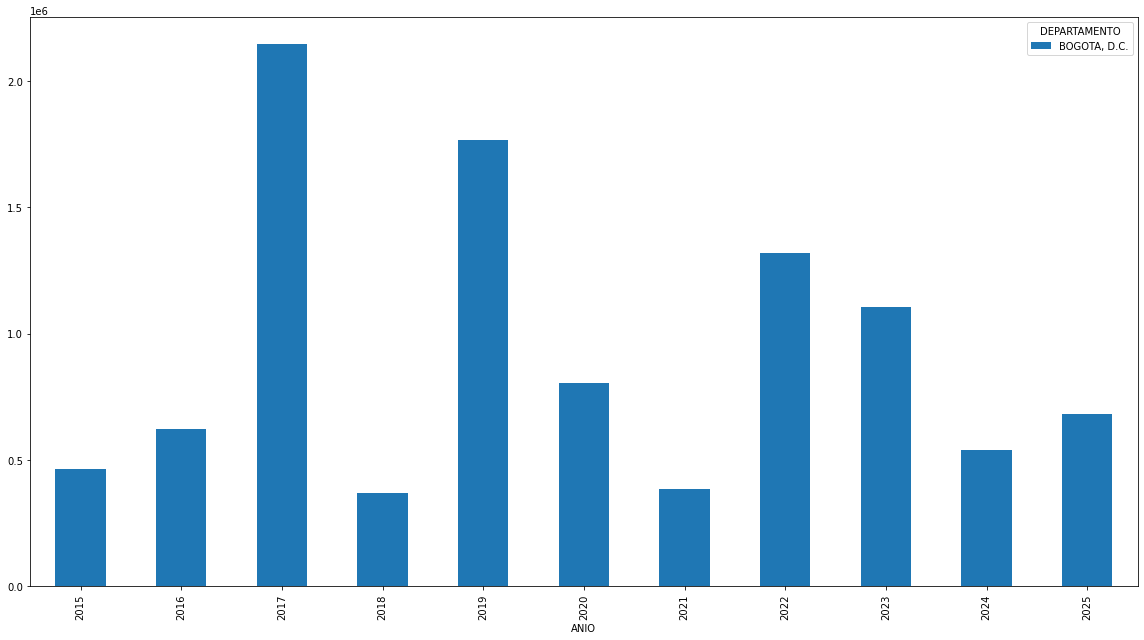

In [98]:
# recupera el peso de cada año, agrupado por sexo:
datosFIL = datos_dep[datos_dep['IDDEPARTAMENTO'] == 5.0]
datos_dep_y = datosFIL.groupby(['ANIO', 'DEPARTAMENTO']).mean()["GENERACION_TOTAL_KG"].unstack()
# genera el gráfico:
datos_dep_y.plot(kind="bar")
plt.tight_layout()  # tip(!)

# PREDICCION POR MUNICIPIO

Cargamos nuestro Dataset por Municipio 2015-2020

In [42]:
Name = 'MUNICIPIO_GrpConsolidado'
#Carga archivo fuente para la predicción
datos = pd.read_csv(Name+'.csv',sep=';')
#Se crea una copy of the original data
#datos = datos[datos['IDDEPARTAMENTO'] == 5.0]
datos_mun = datos.copy()
datos = datos.drop('MUNICIPIO',axis=1)
#Se establece el año como indice
datos['ANIO'] = pd.to_datetime(datos['ANIO'], format='%Y')
datos = datos.set_index('ANIO')
datos = datos.sort_index()
datos

IDMUNICIPIO  GENERACION_TOTAL_KG
ANIO                                        
2015-01-01            0                  0.0
2015-01-01          274                  0.0
2015-01-01           92                  0.0
2015-01-01          275                  0.0
2015-01-01           91                  0.0
...                 ...                  ...
2020-01-01           46                  0.0
2020-01-01          333                765.0
2020-01-01          246                  0.0
2020-01-01          340                602.2
2020-01-01          396                  0.0

[2382 rows x 2 columns]

RECORRIDO, ENTRENAMIENTO Y PROYECCIÓN

In [44]:
columns = datos_mun['MUNICIPIO'].unique()
iddepto = datos_mun['IDMUNICIPIO'].unique()
# Definir Dataframe necesarios.
val_metodo =  pd.DataFrame()
df = datos.copy()
prcmse = 0
prcmape = 0
lprcmse = []
lprcmape = []
for p in range(len(iddepto)):
    print(p)
    df = datos[datos['IDMUNICIPIO'] == iddepto[p]]
    long = len(df)
    PASOS=2
        # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    # load dataset
    values = df.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, PASOS, 1)
    #reframed.head()
    
    # Dividimos en set de Entrenamiento y Validación
    values = reframed.values
    n_train_days = long - (3+PASOS)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    
    #Creamos la red neuronal Feedforward
    def crear_modeloFF():
        model = Sequential() 
        model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
        model.add(Flatten())
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse","mape"])
        model.summary()
        return model
    
    #Entrenamos la red con 40 ciclos
    EPOCHS=40
    model = crear_modeloFF()
    history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)
    
    prcmse = sum(history.history['mse'])/EPOCHS
    lprcmse.append(prcmse)
    prcmape = sum(history.history['mape'])/EPOCHS
    lprcmape.append(prcmape)
    
    results=model.predict(x_val)
    
    compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
    compara.columns = ['real', 'prediccion']

    inverted = scaler.inverse_transform(compara.values)

    compara2 = pd.DataFrame(inverted)
    compara2.columns = ['real', 'prediccion']
    compara2['diferencia'] = compara2['real'] - compara2['prediccion']
    #compara2.head()
    
    #A partir de los dos ultimos años (2019-2020) preparamos los datos para Test
    ultimosDias = df['2019-01-01':'2020-01-01']
    ultimosDias
    values = ultimosDias.values
    values = values.astype('float32')
    # normalize features
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
    #reframed.head(7)
    
    values = reframed.values
    x_test = values[1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    x_test

    def agregarNuevoValor(x_test,nuevoValor):
        for i in range(x_test.shape[2]-1):
            x_test[0][0][i] = x_test[0][0][i+1]
        x_test[0][0][x_test.shape[2]-1]=nuevoValor
        return x_test
    
    #Pronóstico de los 5 años posteriores (2021-2025)
    results=[]
    for i in range(5):
        parcial=model.predict(x_test)
        results.append(parcial[0])
        print(x_test)
        x_test=agregarNuevoValor(x_test,parcial[0])

    adimen = [x for x in results]    
    print(adimen)
    inverted = scaler.inverse_transform(adimen)
    inverted

    prediccion5años = pd.DataFrame(inverted)
    prediccion5años.columns = ['pronostico']
    prediccion5años =  round(prediccion5años, 2)
    
    #Agregamos el resultado del pronostico en el dataset
    i=0
    for fila in prediccion5años.pronostico:
        i=i+1
        ultimosDias.loc['202' + str(i)+'-01-01'] = fila
        ANIO = '202'+ str(i)+'-01-01'
        datos_mun = datos_mun.append({'MUNICIPIO' : columns[p],'IDMUNICIPIO' : iddepto[p],'ANIO' : '202' + str(i), 'GENERACION_TOTAL_KG' : round(float(fila),3)}, ignore_index=True)

0
(1, 1, 2) (1,) (9, 1, 2) (9,)
Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_404 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_202 (Flatten)       (None, 2)                 0         
                                                                 
 dense_405 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6562 - mse: 2.7429 - mape: 165.6157 - val_loss: 1.1132 - val_mse: 1.4863 - val_mape: 232.3071
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 1.6534 - mse: 2.7339 - mape: 165.3442 - val_loss: 1.11

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_406 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_203 (Flatten)       (None, 2)                 0         
                                                                 
 dense_407 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 809ms/step - loss: 0.5208 - mse: 0.2712 - mape: 52.1171 - val_loss: 0.6239 - val_mse: 0.5003 - val_mape: 67.8101
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5170 - mse: 0.2673 - mape: 51.7352 - val_loss: 0.6215 - val_mse: 0.4981 - val_mape: 67.5389
Epoch 3/40
1/1 [==============================] - 0s 56ms/step - loss: 0.5132 - mse: 0.2633 - mape: 51.3549 - val_loss: 0.6191 - val_mse: 0.4959 - val_mape: 67.2682
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 0.5094 - mse: 0.2595 - mape: 50.9762 - val_loss: 0.6167 - val_mse: 0.4937 - val_mape: 66.9979
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5056 - mse: 0.2556 - mape: 50.5991 - val_loss: 0.6143 - val_mse: 0.4916 - val_mape: 66.7280
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5019 - mse: 0.2519 - mape: 50.2236 - val_loss: 0.6119 - val_mse: 0.4895 - val_mape: 66.4587
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 826ms/step - loss: 0.4414 - mse: 0.1948 - mape: 46.1522 - val_loss: 0.6072 - val_mse: 0.5615 - val_mape: 62.1427
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4386 - mse: 0.1924 - mape: 45.8595 - val_loss: 0.6055 - val_mse: 0.5604 - val_mape: 61.9687
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4358 - mse: 0.1899 - mape: 45.5676 - val_loss: 0.6039 - val_mse: 0.5593 - val_mape: 61.7949
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.4330 - mse: 0.1875 - mape: 45.2768 - val_loss: 0.6023 - val_mse: 0.5583 - val_mape: 61.6215
Epoch 5/40
1/1 [==============================] - 0s 54ms/step - loss: 0.4302 - mse: 0.1851 - mape: 44.9869 - val_loss: 0.6006 - val_mse: 0.5572 - val_mape: 61.4484
Epoch 6/40
1/1 [==============================] - 0s 56ms/step - loss: 0.4275 - mse: 0.1827 - mape: 44.6979 - val_loss: 0.5990 - val_mse: 0.5562 - val_mape: 61.2757
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.7531 - mse: 3.0733 - mape: 176.7866 - val_loss: 1.3579 - val_mse: 2.0152 - val_mape: 172.6253
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7514 - mse: 3.0676 - mape: 176.6215 - val_loss: 1.3561 - val_mse: 2.0097 - val_mape: 172.3565
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7498 - mse: 3.0618 - mape: 176.4555 - val_loss: 1.3543 - val_mse: 2.0043 - val_mape: 172.0862
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7481 - mse: 3.0560 - mape: 176.2885 - val_loss: 1.3525 - val_mse: 1.9988 - val_mape: 171.8142
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7465 - mse: 3.0502 - mape: 176.1204 - val_loss: 1.3507 - val_mse: 1.9933 - val_mape: 171.5407
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7448 - mse: 3.0443 - mape: 175.9513 - val_loss: 1.3488 - val_mse: 1.9878 - val_mape: 171.2655
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 811ms/step - loss: 0.6850 - mse: 0.4692 - mape: 68.5715 - val_loss: 0.8209 - val_mse: 0.7329 - val_mape: 82.2175
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6803 - mse: 0.4628 - mape: 68.1020 - val_loss: 0.8180 - val_mse: 0.7294 - val_mape: 81.9193
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.6756 - mse: 0.4565 - mape: 67.6345 - val_loss: 0.8150 - val_mse: 0.7260 - val_mape: 81.6223
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6710 - mse: 0.4502 - mape: 67.1692 - val_loss: 0.8121 - val_mse: 0.7226 - val_mape: 81.3265
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6664 - mse: 0.4440 - mape: 66.7061 - val_loss: 0.8091 - val_mse: 0.7193 - val_mape: 81.0321
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6618 - mse: 0.4379 - mape: 66.2453 - val_loss: 0.8062 - val_mse: 0.7160 - val_mape: 80.7389
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 788ms/step - loss: 0.9107 - mse: 0.8294 - mape: 104.8928 - val_loss: 1.1220 - val_mse: 1.3692 - val_mape: 124.9997
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9068 - mse: 0.8223 - mape: 104.4432 - val_loss: 1.1197 - val_mse: 1.3631 - val_mape: 124.7340
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9029 - mse: 0.8153 - mape: 103.9942 - val_loss: 1.1175 - val_mse: 1.3574 - val_mape: 124.4800
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.8990 - mse: 0.8083 - mape: 103.5455 - val_loss: 1.1154 - val_mse: 1.3519 - val_mape: 124.2349
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8951 - mse: 0.8013 - mape: 103.0967 - val_loss: 1.1133 - val_mse: 1.3465 - val_mape: 123.9936
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8912 - mse: 0.7943 - mape: 102.6479 - val_loss: 1.1112 - val_mse: 1.3412 - val_mape: 123.7537
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 897ms/step - loss: 1.0116 - mse: 1.0233 - mape: 101.1813 - val_loss: 1.0043 - val_mse: 1.0308 - val_mape: 100.4424
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0079 - mse: 1.0158 - mape: 100.8107 - val_loss: 1.0020 - val_mse: 1.0260 - val_mape: 100.2136
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0042 - mse: 1.0084 - mape: 100.4403 - val_loss: 0.9998 - val_mse: 1.0212 - val_mape: 99.9848
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0005 - mse: 1.0010 - mape: 100.0700 - val_loss: 0.9975 - val_mse: 1.0164 - val_mape: 99.7560
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.9968 - mse: 0.9936 - mape: 99.6999 - val_loss: 0.9952 - val_mse: 1.0116 - val_mape: 99.5272
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9931 - mse: 0.9862 - mape: 99.3300 - val_loss: 0.9929 - val_mse: 1.0069 - val_mape: 99.2985
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.2562 - mse: 0.0656 - mape: 204.9509 - val_loss: 0.7176 - val_mse: 0.7175 - val_mape: 173.5286
Epoch 2/40
1/1 [==============================] - 0s 153ms/step - loss: 0.2528 - mse: 0.0639 - mape: 202.2181 - val_loss: 0.7175 - val_mse: 0.7203 - val_mape: 172.6918
Epoch 3/40
1/1 [==============================] - 0s 167ms/step - loss: 0.2493 - mse: 0.0622 - mape: 199.4760 - val_loss: 0.7174 - val_mse: 0.7231 - val_mape: 171.8516
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2459 - mse: 0.0605 - mape: 196.7247 - val_loss: 0.7173 - val_mse: 0.7259 - val_mape: 171.0079
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2425 - mse: 0.0588 - mape: 193.9641 - val_loss: 0.7172 - val_mse: 0.7288 - val_mape: 170.1606
Epoch 6/40
1/1 [==============================] - 0s 56ms/step - loss: 0.2390 - mse: 0.0571 - mape: 191.1938 - val_loss: 0.7171 - val_mse: 0.7316 - val_mape: 169.3096
Epoch 7/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 913ms/step - loss: 0.1585 - mse: 0.0251 - mape: 269.4157 - val_loss: 0.5747 - val_mse: 0.5900 - val_mape: 174.7094
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1539 - mse: 0.0237 - mape: 261.6594 - val_loss: 0.5737 - val_mse: 0.5899 - val_mape: 172.2927
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1494 - mse: 0.0223 - mape: 253.8968 - val_loss: 0.5728 - val_mse: 0.5898 - val_mape: 169.8739
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 0.1448 - mse: 0.0210 - mape: 246.1282 - val_loss: 0.5719 - val_mse: 0.5898 - val_mape: 167.4533
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1402 - mse: 0.0197 - mape: 238.3541 - val_loss: 0.5709 - val_mse: 0.5897 - val_mape: 165.0308
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1356 - mse: 0.0184 - mape: 230.5746 - val_loss: 0.5700 - val_mse: 0.5897 - val_mape: 162.6066
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 792ms/step - loss: 0.2560 - mse: 0.0655 - mape: 421.7250 - val_loss: 0.7432 - val_mse: 0.9680 - val_mape: 260.7519
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2529 - mse: 0.0639 - mape: 416.6122 - val_loss: 0.7420 - val_mse: 0.9673 - val_mape: 258.9761
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2498 - mse: 0.0624 - mape: 411.4852 - val_loss: 0.7408 - val_mse: 0.9666 - val_mape: 257.1954
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.2466 - mse: 0.0608 - mape: 406.3442 - val_loss: 0.7396 - val_mse: 0.9659 - val_mape: 255.4099
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2435 - mse: 0.0593 - mape: 401.1888 - val_loss: 0.7384 - val_mse: 0.9652 - val_mape: 253.6196
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2404 - mse: 0.0578 - mape: 396.0191 - val_loss: 0.7372 - val_mse: 0.9645 - val_mape: 251.8243
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 800ms/step - loss: 0.7353 - mse: 0.5407 - mape: 90.2252 - val_loss: 0.8664 - val_mse: 0.8460 - val_mape: 103.5772
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7324 - mse: 0.5364 - mape: 89.8625 - val_loss: 0.8655 - val_mse: 0.8438 - val_mape: 103.6040
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7294 - mse: 0.5320 - mape: 89.5004 - val_loss: 0.8646 - val_mse: 0.8417 - val_mape: 103.6317
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.7265 - mse: 0.5278 - mape: 89.1388 - val_loss: 0.8637 - val_mse: 0.8397 - val_mape: 103.6610
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7235 - mse: 0.5235 - mape: 88.7774 - val_loss: 0.8629 - val_mse: 0.8380 - val_mape: 103.6929
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.7206 - mse: 0.5192 - mape: 88.4160 - val_loss: 0.8622 - val_mse: 0.8365 - val_mape: 103.7270
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.1870 - mse: 1.4089 - mape: 253.0286 - val_loss: 0.8323 - val_mse: 0.8716 - val_mape: 179.9984
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1854 - mse: 1.4052 - mape: 252.6947 - val_loss: 0.8313 - val_mse: 0.8699 - val_mape: 179.7199
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1838 - mse: 1.4015 - mape: 252.3595 - val_loss: 0.8304 - val_mse: 0.8682 - val_mape: 179.4406
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1823 - mse: 1.3978 - mape: 252.0229 - val_loss: 0.8294 - val_mse: 0.8665 - val_mape: 179.1605
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1807 - mse: 1.3940 - mape: 251.6849 - val_loss: 0.8285 - val_mse: 0.8648 - val_mape: 178.8795
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1791 - mse: 1.3903 - mape: 251.3455 - val_loss: 0.8275 - val_mse: 0.8631 - val_mape: 178.5977
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.3601 - mse: 0.1297 - mape: 107.6135 - val_loss: 0.6634 - val_mse: 0.5259 - val_mape: 117.9487
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.3546 - mse: 0.1257 - mape: 105.9543 - val_loss: 0.6602 - val_mse: 0.5216 - val_mape: 117.1712
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3490 - mse: 0.1218 - mape: 104.2951 - val_loss: 0.6570 - val_mse: 0.5173 - val_mape: 116.3928
Epoch 4/40
1/1 [==============================] - 0s 52ms/step - loss: 0.3434 - mse: 0.1180 - mape: 102.6360 - val_loss: 0.6538 - val_mse: 0.5131 - val_mape: 115.6137
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3379 - mse: 0.1142 - mape: 100.9770 - val_loss: 0.6507 - val_mse: 0.5089 - val_mape: 114.8337
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 0.3323 - mse: 0.1105 - mape: 99.3182 - val_loss: 0.6475 - val_mse: 0.5047 - val_mape: 114.0531
Epoch 7/40
1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 786ms/step - loss: 1.6296 - mse: 2.6556 - mape: 193.7279 - val_loss: 1.2327 - val_mse: 1.9796 - val_mape: 143.3126
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6284 - mse: 2.6517 - mape: 193.5857 - val_loss: 1.2316 - val_mse: 1.9768 - val_mape: 143.0003
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 1.6272 - mse: 2.6477 - mape: 193.4428 - val_loss: 1.2306 - val_mse: 1.9739 - val_mape: 142.6879
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6260 - mse: 2.6438 - mape: 193.2993 - val_loss: 1.2295 - val_mse: 1.9710 - val_mape: 142.3754
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.6248 - mse: 2.6399 - mape: 193.1551 - val_loss: 1.2284 - val_mse: 1.9681 - val_mape: 142.0628
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6236 - mse: 2.6359 - mape: 193.0103 - val_loss: 1.2274 - val_mse: 1.9652 - val_mape: 141.7501
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.7308 - mse: 2.9957 - mape: 173.0798 - val_loss: 1.6704 - val_mse: 2.8120 - val_mape: 178.9562
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7291 - mse: 2.9899 - mape: 172.9125 - val_loss: 1.6696 - val_mse: 2.8091 - val_mape: 178.8696
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.7274 - mse: 2.9841 - mape: 172.7444 - val_loss: 1.6687 - val_mse: 2.8062 - val_mape: 178.7826
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7258 - mse: 2.9782 - mape: 172.5757 - val_loss: 1.6679 - val_mse: 2.8033 - val_mape: 178.6954
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.7241 - mse: 2.9724 - mape: 172.4062 - val_loss: 1.6670 - val_mse: 2.8004 - val_mape: 178.6078
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7224 - mse: 2.9665 - mape: 172.2361 - val_loss: 1.6662 - val_mse: 2.7974 - val_mape: 178.5200
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 2s 2s/step - loss: 1.2308 - mse: 1.5148 - mape: 126.1327 - val_loss: 0.7046 - val_mse: 0.6585 - val_mape: 108.9114
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2265 - mse: 1.5042 - mape: 125.6916 - val_loss: 0.7024 - val_mse: 0.6550 - val_mape: 108.3949
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2221 - mse: 1.4936 - mape: 125.2492 - val_loss: 0.7002 - val_mse: 0.6516 - val_mape: 107.8772
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.2178 - mse: 1.4831 - mape: 124.8053 - val_loss: 0.6980 - val_mse: 0.6482 - val_mape: 107.3581
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2135 - mse: 1.4725 - mape: 124.3601 - val_loss: 0.6960 - val_mse: 0.6448 - val_mape: 106.8699
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 1.2091 - mse: 1.4619 - mape: 123.9135 - val_loss: 0.6943 - val_mse: 0.6415 - val_mape: 106.4564
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.3417 - mse: 0.1168 - mape: 36.5075 - val_loss: 0.5871 - val_mse: 0.5914 - val_mape: 61.0504
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.3395 - mse: 0.1153 - mape: 36.2758 - val_loss: 0.5856 - val_mse: 0.5907 - val_mape: 60.8720
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3374 - mse: 0.1138 - mape: 36.0451 - val_loss: 0.5841 - val_mse: 0.5901 - val_mape: 60.6942
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3352 - mse: 0.1124 - mape: 35.8154 - val_loss: 0.5826 - val_mse: 0.5894 - val_mape: 60.5169
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.3331 - mse: 0.1109 - mape: 35.5867 - val_loss: 0.5810 - val_mse: 0.5887 - val_mape: 60.3403
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3310 - mse: 0.1095 - mape: 35.3590 - val_loss: 0.5795 - val_mse: 0.5881 - val_mape: 60.1642
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 832ms/step - loss: 0.4250 - mse: 0.1806 - mape: 42.9248 - val_loss: 0.4877 - val_mse: 0.4066 - val_mape: 51.1842
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.4223 - mse: 0.1783 - mape: 42.6458 - val_loss: 0.4861 - val_mse: 0.4058 - val_mape: 51.0344
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.4195 - mse: 0.1760 - mape: 42.3679 - val_loss: 0.4845 - val_mse: 0.4051 - val_mape: 50.8851
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.4168 - mse: 0.1737 - mape: 42.0913 - val_loss: 0.4829 - val_mse: 0.4043 - val_mape: 50.7365
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4140 - mse: 0.1714 - mape: 41.8159 - val_loss: 0.4813 - val_mse: 0.4036 - val_mape: 50.5884
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4113 - mse: 0.1692 - mape: 41.5418 - val_loss: 0.4797 - val_mse: 0.4029 - val_mape: 50.4410
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 781ms/step - loss: 0.3516 - mse: 0.1236 - mape: 35.2826 - val_loss: 0.6186 - val_mse: 0.6168 - val_mape: 113.5091
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3495 - mse: 0.1221 - mape: 35.0690 - val_loss: 0.6174 - val_mse: 0.6161 - val_mape: 113.5579
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3474 - mse: 0.1207 - mape: 34.8566 - val_loss: 0.6163 - val_mse: 0.6154 - val_mape: 113.6061
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3452 - mse: 0.1192 - mape: 34.6454 - val_loss: 0.6151 - val_mse: 0.6147 - val_mape: 113.6537
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3432 - mse: 0.1178 - mape: 34.4354 - val_loss: 0.6140 - val_mse: 0.6141 - val_mape: 113.7006
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3411 - mse: 0.1163 - mape: 34.2266 - val_loss: 0.6129 - val_mse: 0.6134 - val_mape: 113.7469
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 759ms/step - loss: 1.7675 - mse: 3.1242 - mape: 176.7533 - val_loss: 1.4191 - val_mse: 2.4074 - val_mape: 141.9696
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7659 - mse: 3.1184 - mape: 176.5907 - val_loss: 1.4184 - val_mse: 2.4051 - val_mape: 141.8995
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7643 - mse: 3.1127 - mape: 176.4272 - val_loss: 1.4177 - val_mse: 2.4028 - val_mape: 141.8290
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7626 - mse: 3.1068 - mape: 176.2626 - val_loss: 1.4170 - val_mse: 2.4005 - val_mape: 141.7583
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7610 - mse: 3.1010 - mape: 176.0969 - val_loss: 1.4163 - val_mse: 2.3982 - val_mape: 141.6872
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7593 - mse: 3.0951 - mape: 175.9302 - val_loss: 1.4155 - val_mse: 2.3958 - val_mape: 141.6158
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 754ms/step - loss: 1.0072 - mse: 1.0144 - mape: 106.7093 - val_loss: 0.8498 - val_mse: 0.7771 - val_mape: 102.1151
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0044 - mse: 1.0088 - mape: 106.4176 - val_loss: 0.8481 - val_mse: 0.7743 - val_mape: 101.8744
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0016 - mse: 1.0033 - mape: 106.1259 - val_loss: 0.8464 - val_mse: 0.7716 - val_mape: 101.6337
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9989 - mse: 0.9978 - mape: 105.8343 - val_loss: 0.8447 - val_mse: 0.7688 - val_mape: 101.3932
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9961 - mse: 0.9923 - mape: 105.5427 - val_loss: 0.8430 - val_mse: 0.7661 - val_mape: 101.1529
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9934 - mse: 0.9868 - mape: 105.2513 - val_loss: 0.8413 - val_mse: 0.7633 - val_mape: 100.9126
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 1.7763 - mse: 3.1554 - mape: 178.5526 - val_loss: 1.0949 - val_mse: 1.5359 - val_mape: 135.2668
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7740 - mse: 3.1472 - mape: 178.3213 - val_loss: 1.0921 - val_mse: 1.5303 - val_mape: 134.6311
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.7717 - mse: 3.1390 - mape: 178.0879 - val_loss: 1.0892 - val_mse: 1.5247 - val_mape: 133.9938
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7694 - mse: 3.1307 - mape: 177.8521 - val_loss: 1.0864 - val_mse: 1.5191 - val_mape: 133.3548
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.7670 - mse: 3.1223 - mape: 177.6141 - val_loss: 1.0835 - val_mse: 1.5135 - val_mape: 132.7139
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7646 - mse: 3.1139 - mape: 177.3737 - val_loss: 1.0806 - val_mse: 1.5079 - val_mape: 132.0711
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 971ms/step - loss: 0.5466 - mse: 0.2988 - mape: 446.4109 - val_loss: 0.6795 - val_mse: 0.7952 - val_mape: 233.6739
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5432 - mse: 0.2950 - mape: 443.5772 - val_loss: 0.6785 - val_mse: 0.7941 - val_mape: 232.7097
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5397 - mse: 0.2912 - mape: 440.7319 - val_loss: 0.6774 - val_mse: 0.7929 - val_mape: 231.7416
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.5362 - mse: 0.2875 - mape: 437.8745 - val_loss: 0.6764 - val_mse: 0.7917 - val_mape: 230.7695
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5327 - mse: 0.2837 - mape: 435.0052 - val_loss: 0.6754 - val_mse: 0.7906 - val_mape: 229.7932
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5291 - mse: 0.2800 - mape: 432.1237 - val_loss: 0.6743 - val_mse: 0.7894 - val_mape: 228.8129
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 789ms/step - loss: 1.2956 - mse: 1.6786 - mape: 129.5594 - val_loss: 1.1774 - val_mse: 1.5129 - val_mape: 119.9587
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.2920 - mse: 1.6692 - mape: 129.1982 - val_loss: 1.1755 - val_mse: 1.5079 - val_mape: 119.7855
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.2884 - mse: 1.6599 - mape: 128.8364 - val_loss: 1.1737 - val_mse: 1.5029 - val_mape: 119.6119
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2847 - mse: 1.6506 - mape: 128.4740 - val_loss: 1.1718 - val_mse: 1.4979 - val_mape: 119.4381
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.2811 - mse: 1.6412 - mape: 128.1111 - val_loss: 1.1699 - val_mse: 1.4929 - val_mape: 119.2638
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2775 - mse: 1.6319 - mape: 127.7474 - val_loss: 1.1680 - val_mse: 1.4879 - val_mape: 119.0892
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 1.0468 - mse: 1.0958 - mape: 122.3096 - val_loss: 1.1438 - val_mse: 1.3679 - val_mape: 122.2698
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0401 - mse: 1.0818 - mape: 121.5281 - val_loss: 1.1389 - val_mse: 1.3553 - val_mape: 121.7223
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0334 - mse: 1.0679 - mape: 120.7443 - val_loss: 1.1339 - val_mse: 1.3426 - val_mape: 121.1725
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0267 - mse: 1.0540 - mape: 119.9581 - val_loss: 1.1289 - val_mse: 1.3300 - val_mape: 120.6205
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0199 - mse: 1.0402 - mape: 119.1696 - val_loss: 1.1238 - val_mse: 1.3175 - val_mape: 120.0663
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0132 - mse: 1.0265 - mape: 118.3790 - val_loss: 1.1188 - val_mse: 1.3049 - val_mape: 119.5098
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 811ms/step - loss: 0.3113 - mse: 0.0969 - mape: 31.9380 - val_loss: 0.8627 - val_mse: 1.1115 - val_mape: 89.8536
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3091 - mse: 0.0955 - mape: 31.7075 - val_loss: 0.8623 - val_mse: 1.1121 - val_mape: 89.8208
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3069 - mse: 0.0942 - mape: 31.4782 - val_loss: 0.8619 - val_mse: 1.1127 - val_mape: 89.7881
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3046 - mse: 0.0928 - mape: 31.2501 - val_loss: 0.8616 - val_mse: 1.1134 - val_mape: 89.7553
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3024 - mse: 0.0915 - mape: 31.0233 - val_loss: 0.8612 - val_mse: 1.1140 - val_mape: 89.7225
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3002 - mse: 0.0901 - mape: 30.7978 - val_loss: 0.8608 - val_mse: 1.1146 - val_mape: 89.6897
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 0.5643 - mse: 0.3184 - mape: 323.1766 - val_loss: 0.8172 - val_mse: 0.7275 - val_mape: 199.4009
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.5616 - mse: 0.3153 - mape: 321.6176 - val_loss: 0.8150 - val_mse: 0.7239 - val_mape: 198.5995
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5588 - mse: 0.3123 - mape: 320.0565 - val_loss: 0.8127 - val_mse: 0.7204 - val_mape: 197.7974
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5561 - mse: 0.3092 - mape: 318.4934 - val_loss: 0.8105 - val_mse: 0.7168 - val_mape: 196.9946
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5534 - mse: 0.3062 - mape: 316.9284 - val_loss: 0.8083 - val_mse: 0.7133 - val_mape: 196.1911
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 0.5506 - mse: 0.3032 - mape: 315.3613 - val_loss: 0.8061 - val_mse: 0.7097 - val_mape: 195.3870
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 831ms/step - loss: 1.4236 - mse: 2.0265 - mape: 144.0966 - val_loss: 1.1461 - val_mse: 1.4319 - val_mape: 537.5386
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4200 - mse: 2.0164 - mape: 143.7358 - val_loss: 1.1430 - val_mse: 1.4252 - val_mape: 533.1669
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.4164 - mse: 2.0062 - mape: 143.3733 - val_loss: 1.1399 - val_mse: 1.4185 - val_mape: 528.7747
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4128 - mse: 1.9960 - mape: 143.0092 - val_loss: 1.1368 - val_mse: 1.4117 - val_mape: 524.3614
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 1.4092 - mse: 1.9858 - mape: 142.6433 - val_loss: 1.1337 - val_mse: 1.4050 - val_mape: 519.9270
Epoch 6/40
1/1 [==============================] - 0s 48ms/step - loss: 1.4056 - mse: 1.9756 - mape: 142.2756 - val_loss: 1.1306 - val_mse: 1.3983 - val_mape: 515.4712
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 0.8059 - mse: 0.6494 - mape: 127.1084 - val_loss: 0.8072 - val_mse: 0.7067 - val_mape: 98.7753
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8019 - mse: 0.6430 - mape: 126.4840 - val_loss: 0.8050 - val_mse: 0.7028 - val_mape: 98.4725
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7979 - mse: 0.6367 - mape: 125.8583 - val_loss: 0.8028 - val_mse: 0.6990 - val_mape: 98.1694
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.7940 - mse: 0.6304 - mape: 125.2314 - val_loss: 0.8006 - val_mse: 0.6952 - val_mape: 97.8660
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 0.7900 - mse: 0.6241 - mape: 124.6033 - val_loss: 0.7984 - val_mse: 0.6914 - val_mape: 97.5621
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7860 - mse: 0.6178 - mape: 123.9739 - val_loss: 0.7962 - val_mse: 0.6876 - val_mape: 97.2578
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 789ms/step - loss: 1.2636 - mse: 1.5966 - mape: 126.4767 - val_loss: 0.9985 - val_mse: 1.1191 - val_mape: 165.8137
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2608 - mse: 1.5896 - mape: 126.1982 - val_loss: 0.9968 - val_mse: 1.1154 - val_mape: 164.8537
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2580 - mse: 1.5825 - mape: 125.9196 - val_loss: 0.9951 - val_mse: 1.1116 - val_mape: 163.8936
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.2552 - mse: 1.5755 - mape: 125.6408 - val_loss: 0.9934 - val_mse: 1.1079 - val_mape: 162.9335
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2524 - mse: 1.5686 - mape: 125.3620 - val_loss: 0.9917 - val_mse: 1.1042 - val_mape: 161.9736
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 1.2496 - mse: 1.5616 - mape: 125.0830 - val_loss: 0.9900 - val_mse: 1.1004 - val_mape: 161.0137
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 782ms/step - loss: 1.6920 - mse: 2.8630 - mape: 169.2753 - val_loss: 1.2764 - val_mse: 1.9214 - val_mape: 198.6719
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6888 - mse: 2.8520 - mape: 168.9512 - val_loss: 1.2748 - val_mse: 1.9161 - val_mape: 198.4756
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6855 - mse: 2.8410 - mape: 168.6241 - val_loss: 1.2732 - val_mse: 1.9108 - val_mape: 198.2778
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6822 - mse: 2.8299 - mape: 168.2940 - val_loss: 1.2715 - val_mse: 1.9055 - val_mape: 198.0786
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6789 - mse: 2.8187 - mape: 167.9609 - val_loss: 1.2699 - val_mse: 1.9002 - val_mape: 197.8780
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6755 - mse: 2.8074 - mape: 167.6248 - val_loss: 1.2682 - val_mse: 1.8948 - val_mape: 197.6759
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 794ms/step - loss: 0.3616 - mse: 0.1308 - mape: 36.1639 - val_loss: 0.3502 - val_mse: 0.1285 - val_mape: 35.4490
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3580 - mse: 0.1282 - mape: 35.7991 - val_loss: 0.3481 - val_mse: 0.1269 - val_mape: 35.2349
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3544 - mse: 0.1256 - mape: 35.4379 - val_loss: 0.3460 - val_mse: 0.1253 - val_mape: 35.0226
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.3508 - mse: 0.1231 - mape: 35.0801 - val_loss: 0.3439 - val_mse: 0.1237 - val_mape: 34.8120
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3473 - mse: 0.1206 - mape: 34.7260 - val_loss: 0.3418 - val_mse: 0.1221 - val_mape: 34.6031
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3438 - mse: 0.1182 - mape: 34.3755 - val_loss: 0.3398 - val_mse: 0.1206 - val_mape: 34.3961
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 1.0798 - mse: 1.1660 - mape: 107.9811 - val_loss: 1.0774 - val_mse: 1.1608 - val_mape: 107.7388
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0759 - mse: 1.1575 - mape: 107.5867 - val_loss: 1.0750 - val_mse: 1.1556 - val_mape: 107.4965
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0719 - mse: 1.1490 - mape: 107.1922 - val_loss: 1.0725 - val_mse: 1.1504 - val_mape: 107.2540
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0680 - mse: 1.1406 - mape: 106.7976 - val_loss: 1.0701 - val_mse: 1.1452 - val_mape: 107.0115
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 1.0640 - mse: 1.1322 - mape: 106.4028 - val_loss: 1.0677 - val_mse: 1.1400 - val_mape: 106.7690
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0601 - mse: 1.1238 - mape: 106.0079 - val_loss: 1.0653 - val_mse: 1.1349 - val_mape: 106.5264
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 0.3458 - mse: 0.1196 - mape: 34.6123 - val_loss: 0.5020 - val_mse: 0.3940 - val_mape: 52.4782
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.3426 - mse: 0.1174 - mape: 34.2954 - val_loss: 0.4991 - val_mse: 0.3928 - val_mape: 52.1549
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3395 - mse: 0.1153 - mape: 33.9810 - val_loss: 0.4963 - val_mse: 0.3917 - val_mape: 51.8337
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3364 - mse: 0.1131 - mape: 33.6692 - val_loss: 0.4934 - val_mse: 0.3906 - val_mape: 51.5147
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3333 - mse: 0.1111 - mape: 33.3599 - val_loss: 0.4906 - val_mse: 0.3896 - val_mape: 51.1979
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3302 - mse: 0.1090 - mape: 33.0532 - val_loss: 0.4877 - val_mse: 0.3886 - val_mape: 50.8833
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 1.6812 - mse: 2.8266 - mape: 168.1236 - val_loss: 1.6598 - val_mse: 2.7568 - val_mape: 168.9141
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6789 - mse: 2.8188 - mape: 167.8921 - val_loss: 1.6584 - val_mse: 2.7523 - val_mape: 168.7763
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6766 - mse: 2.8110 - mape: 167.6592 - val_loss: 1.6570 - val_mse: 2.7477 - val_mape: 168.6378
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6742 - mse: 2.8031 - mape: 167.4248 - val_loss: 1.6556 - val_mse: 2.7431 - val_mape: 168.4987
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6719 - mse: 2.7952 - mape: 167.1889 - val_loss: 1.6543 - val_mse: 2.7385 - val_mape: 168.3587
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6695 - mse: 2.7873 - mape: 166.9514 - val_loss: 1.6529 - val_mse: 2.7339 - val_mape: 168.2181
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 803ms/step - loss: 0.9739 - mse: 0.9484 - mape: 97.3882 - val_loss: 0.8090 - val_mse: 0.7449 - val_mape: 97.3981
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9709 - mse: 0.9426 - mape: 97.0932 - val_loss: 0.8079 - val_mse: 0.7435 - val_mape: 97.1947
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9679 - mse: 0.9369 - mape: 96.7981 - val_loss: 0.8069 - val_mse: 0.7420 - val_mape: 96.9914
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 0.9650 - mse: 0.9312 - mape: 96.5031 - val_loss: 0.8058 - val_mse: 0.7406 - val_mape: 96.7881
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9620 - mse: 0.9255 - mape: 96.2081 - val_loss: 0.8047 - val_mse: 0.7392 - val_mape: 96.5849
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 0.9591 - mse: 0.9199 - mape: 95.9131 - val_loss: 0.8037 - val_mse: 0.7377 - val_mape: 96.3817
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 0.8349 - mse: 0.6970 - mape: 552.6145 - val_loss: 0.5457 - val_mse: 0.4128 - val_mape: 183.0592
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8331 - mse: 0.6940 - mape: 551.4094 - val_loss: 0.5447 - val_mse: 0.4124 - val_mape: 182.4192
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8312 - mse: 0.6910 - mape: 550.1987 - val_loss: 0.5438 - val_mse: 0.4121 - val_mape: 181.7798
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8294 - mse: 0.6879 - mape: 548.9824 - val_loss: 0.5428 - val_mse: 0.4117 - val_mape: 181.1408
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8276 - mse: 0.6848 - mape: 547.7599 - val_loss: 0.5419 - val_mse: 0.4114 - val_mape: 180.5023
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8257 - mse: 0.6818 - mape: 546.5318 - val_loss: 0.5409 - val_mse: 0.4110 - val_mape: 179.8643
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.4852 - mse: 0.2354 - mape: 62.8772 - val_loss: 0.7955 - val_mse: 0.6479 - val_mape: 94.2848
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4825 - mse: 0.2328 - mape: 62.5269 - val_loss: 0.7941 - val_mse: 0.6459 - val_mape: 94.1282
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4798 - mse: 0.2302 - mape: 62.1778 - val_loss: 0.7928 - val_mse: 0.6439 - val_mape: 93.9715
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4771 - mse: 0.2276 - mape: 61.8298 - val_loss: 0.7915 - val_mse: 0.6419 - val_mape: 93.8150
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4744 - mse: 0.2251 - mape: 61.4829 - val_loss: 0.7901 - val_mse: 0.6398 - val_mape: 93.6586
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4717 - mse: 0.2225 - mape: 61.1373 - val_loss: 0.7888 - val_mse: 0.6378 - val_mape: 93.5022
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 1.5205 - mse: 2.3119 - mape: 197.0316 - val_loss: 1.4763 - val_mse: 2.3760 - val_mape: 167.9548
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5190 - mse: 2.3074 - mape: 196.8376 - val_loss: 1.4751 - val_mse: 2.3717 - val_mape: 167.8160
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.5175 - mse: 2.3028 - mape: 196.6424 - val_loss: 1.4740 - val_mse: 2.3673 - val_mape: 167.6765
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5160 - mse: 2.2982 - mape: 196.4461 - val_loss: 1.4728 - val_mse: 2.3629 - val_mape: 167.5361
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.5145 - mse: 2.2936 - mape: 196.2486 - val_loss: 1.4715 - val_mse: 2.3585 - val_mape: 167.3949
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5129 - mse: 2.2889 - mape: 196.0500 - val_loss: 1.4703 - val_mse: 2.3541 - val_mape: 167.2528
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.6409 - mse: 2.6927 - mape: 165.8887 - val_loss: 0.9944 - val_mse: 1.2660 - val_mape: 3861.4072
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6385 - mse: 2.6846 - mape: 165.6400 - val_loss: 0.9930 - val_mse: 1.2624 - val_mape: 3853.4509
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6360 - mse: 2.6765 - mape: 165.3899 - val_loss: 0.9916 - val_mse: 1.2587 - val_mape: 3845.4448
Epoch 4/40
1/1 [==============================] - 0s 49ms/step - loss: 1.6335 - mse: 2.6684 - mape: 165.1384 - val_loss: 0.9902 - val_mse: 1.2551 - val_mape: 3837.3889
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.6310 - mse: 2.6602 - mape: 164.8854 - val_loss: 0.9888 - val_mse: 1.2514 - val_mape: 3829.2822
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6285 - mse: 2.6520 - mape: 164.6309 - val_loss: 0.9874 - val_mse: 1.2478 - val_mape: 3821.1240
Epoch

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.5074 - mse: 0.2575 - mape: 51.1180 - val_loss: 0.6877 - val_mse: 0.6248 - val_mape: 71.0398
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5041 - mse: 0.2541 - mape: 50.7846 - val_loss: 0.6856 - val_mse: 0.6236 - val_mape: 70.8172
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.5008 - mse: 0.2508 - mape: 50.4529 - val_loss: 0.6835 - val_mse: 0.6224 - val_mape: 70.5959
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4976 - mse: 0.2476 - mape: 50.1231 - val_loss: 0.6814 - val_mse: 0.6212 - val_mape: 70.3758
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4943 - mse: 0.2443 - mape: 49.7951 - val_loss: 0.6793 - val_mse: 0.6201 - val_mape: 70.1570
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4911 - mse: 0.2411 - mape: 49.4690 - val_loss: 0.6772 - val_mse: 0.6190 - val_mape: 69.9394
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 786ms/step - loss: 1.2595 - mse: 1.5865 - mape: 125.9547 - val_loss: 1.1217 - val_mse: 1.3293 - val_mape: 114.4876
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2553 - mse: 1.5758 - mape: 125.5298 - val_loss: 1.1199 - val_mse: 1.3246 - val_mape: 114.3158
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2510 - mse: 1.5651 - mape: 125.1039 - val_loss: 1.1181 - val_mse: 1.3199 - val_mape: 114.1436
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2468 - mse: 1.5544 - mape: 124.6769 - val_loss: 1.1163 - val_mse: 1.3152 - val_mape: 113.9710
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.2425 - mse: 1.5438 - mape: 124.2489 - val_loss: 1.1145 - val_mse: 1.3105 - val_mape: 113.7980
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2382 - mse: 1.5331 - mape: 123.8198 - val_loss: 1.1127 - val_mse: 1.3058 - val_mape: 113.6245
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 0.9236 - mse: 0.8530 - mape: 92.3578 - val_loss: 0.8596 - val_mse: 0.7679 - val_mape: 90.9733
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9184 - mse: 0.8435 - mape: 91.8436 - val_loss: 0.8569 - val_mse: 0.7631 - val_mape: 90.6851
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9133 - mse: 0.8341 - mape: 91.3299 - val_loss: 0.8542 - val_mse: 0.7582 - val_mape: 90.3973
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9082 - mse: 0.8248 - mape: 90.8169 - val_loss: 0.8514 - val_mse: 0.7534 - val_mape: 90.1098
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9030 - mse: 0.8155 - mape: 90.3046 - val_loss: 0.8487 - val_mse: 0.7487 - val_mape: 89.8228
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8979 - mse: 0.8063 - mape: 89.7929 - val_loss: 0.8460 - val_mse: 0.7439 - val_mape: 89.5361
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 851ms/step - loss: 1.6127 - mse: 2.6007 - mape: 170.1517 - val_loss: 1.2764 - val_mse: 1.7430 - val_mape: 130.9448
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 1.6108 - mse: 2.5945 - mape: 169.9512 - val_loss: 1.2743 - val_mse: 1.7371 - val_mape: 130.7288
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6089 - mse: 2.5884 - mape: 169.7498 - val_loss: 1.2722 - val_mse: 1.7311 - val_mape: 130.5123
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6069 - mse: 2.5822 - mape: 169.5475 - val_loss: 1.2701 - val_mse: 1.7252 - val_mape: 130.2954
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6050 - mse: 2.5760 - mape: 169.3443 - val_loss: 1.2680 - val_mse: 1.7192 - val_mape: 130.0780
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6031 - mse: 2.5698 - mape: 169.1401 - val_loss: 1.2659 - val_mse: 1.7132 - val_mape: 129.8600
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 0.9264 - mse: 0.8581 - mape: 116.3889 - val_loss: 0.9937 - val_mse: 0.9992 - val_mape: 109.9633
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.9197 - mse: 0.8458 - mape: 115.5459 - val_loss: 0.9928 - val_mse: 0.9975 - val_mape: 109.8388
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9129 - mse: 0.8334 - mape: 114.7012 - val_loss: 0.9919 - val_mse: 0.9958 - val_mape: 109.7144
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9062 - mse: 0.8212 - mape: 113.8549 - val_loss: 0.9910 - val_mse: 0.9942 - val_mape: 109.5898
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8994 - mse: 0.8090 - mape: 113.0069 - val_loss: 0.9901 - val_mse: 0.9925 - val_mape: 109.4652
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8927 - mse: 0.7969 - mape: 112.1575 - val_loss: 0.9892 - val_mse: 0.9909 - val_mape: 109.3405
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 799ms/step - loss: 1.0268 - mse: 1.0543 - mape: 139.6420 - val_loss: 0.8821 - val_mse: 0.8493 - val_mape: 164.7089
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0242 - mse: 1.0490 - mape: 139.2929 - val_loss: 0.8805 - val_mse: 0.8461 - val_mape: 164.1680
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0216 - mse: 1.0437 - mape: 138.9427 - val_loss: 0.8789 - val_mse: 0.8429 - val_mape: 163.6253
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0191 - mse: 1.0385 - mape: 138.5914 - val_loss: 0.8774 - val_mse: 0.8397 - val_mape: 163.0808
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0165 - mse: 1.0332 - mape: 138.2390 - val_loss: 0.8758 - val_mse: 0.8365 - val_mape: 162.5343
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0139 - mse: 1.0279 - mape: 137.8854 - val_loss: 0.8742 - val_mse: 0.8333 - val_mape: 161.9860
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 770ms/step - loss: 1.5630 - mse: 2.4431 - mape: 156.3043 - val_loss: 1.4744 - val_mse: 2.2271 - val_mape: 173.2322
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5610 - mse: 2.4367 - mape: 156.0994 - val_loss: 1.4733 - val_mse: 2.2238 - val_mape: 173.1138
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5589 - mse: 2.4303 - mape: 155.8935 - val_loss: 1.4722 - val_mse: 2.2205 - val_mape: 172.9948
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5569 - mse: 2.4238 - mape: 155.6865 - val_loss: 1.4712 - val_mse: 2.2172 - val_mape: 172.8753
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.5548 - mse: 2.4174 - mape: 155.4785 - val_loss: 1.4701 - val_mse: 2.2138 - val_mape: 172.7551
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5527 - mse: 2.4109 - mape: 155.2693 - val_loss: 1.4690 - val_mse: 2.2105 - val_mape: 172.6343
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 850ms/step - loss: 0.6778 - mse: 0.4594 - mape: 67.7770 - val_loss: 0.8081 - val_mse: 0.7979 - val_mape: 89.6067
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6739 - mse: 0.4542 - mape: 67.3912 - val_loss: 0.8066 - val_mse: 0.7958 - val_mape: 89.4521
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6701 - mse: 0.4490 - mape: 67.0071 - val_loss: 0.8051 - val_mse: 0.7938 - val_mape: 89.2980
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6662 - mse: 0.4439 - mape: 66.6247 - val_loss: 0.8037 - val_mse: 0.7918 - val_mape: 89.1446
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6624 - mse: 0.4388 - mape: 66.2440 - val_loss: 0.8022 - val_mse: 0.7898 - val_mape: 88.9918
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6587 - mse: 0.4338 - mape: 65.8651 - val_loss: 0.8008 - val_mse: 0.7878 - val_mape: 88.8396
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.4882 - mse: 0.2384 - mape: 143.8929 - val_loss: 0.7395 - val_mse: 0.8730 - val_mape: 139.8263
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4866 - mse: 0.2368 - mape: 143.4115 - val_loss: 0.7391 - val_mse: 0.8720 - val_mape: 139.6517
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 0.4849 - mse: 0.2352 - mape: 142.9257 - val_loss: 0.7386 - val_mse: 0.8711 - val_mape: 139.4752
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4833 - mse: 0.2336 - mape: 142.4353 - val_loss: 0.7382 - val_mse: 0.8701 - val_mape: 139.2966
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4816 - mse: 0.2319 - mape: 141.9403 - val_loss: 0.7378 - val_mse: 0.8691 - val_mape: 139.1159
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4799 - mse: 0.2303 - mape: 141.4405 - val_loss: 0.7374 - val_mse: 0.8682 - val_mape: 138.9331
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 790ms/step - loss: 0.3951 - mse: 0.1561 - mape: 40.0660 - val_loss: 0.9803 - val_mse: 1.2348 - val_mape: 151.5391
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3918 - mse: 0.1535 - mape: 39.7265 - val_loss: 0.9795 - val_mse: 1.2340 - val_mape: 151.5548
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3885 - mse: 0.1509 - mape: 39.3895 - val_loss: 0.9787 - val_mse: 1.2332 - val_mape: 151.5695
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3852 - mse: 0.1484 - mape: 39.0550 - val_loss: 0.9779 - val_mse: 1.2324 - val_mape: 151.5831
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3819 - mse: 0.1458 - mape: 38.7232 - val_loss: 0.9771 - val_mse: 1.2315 - val_mape: 151.5956
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3786 - mse: 0.1434 - mape: 38.3940 - val_loss: 0.9763 - val_mse: 1.2307 - val_mape: 151.6072
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 770ms/step - loss: 1.2014 - mse: 1.4434 - mape: 180.2116 - val_loss: 0.8023 - val_mse: 0.8233 - val_mape: 129.6087
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1972 - mse: 1.4332 - mape: 179.5774 - val_loss: 0.8015 - val_mse: 0.8214 - val_mape: 129.3343
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1929 - mse: 1.4231 - mape: 178.9390 - val_loss: 0.8008 - val_mse: 0.8194 - val_mape: 129.0583
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1886 - mse: 1.4129 - mape: 178.2965 - val_loss: 0.8000 - val_mse: 0.8175 - val_mape: 128.7807
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1843 - mse: 1.4026 - mape: 177.6498 - val_loss: 0.7992 - val_mse: 0.8155 - val_mape: 128.5014
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1800 - mse: 1.3924 - mape: 176.9988 - val_loss: 0.7984 - val_mse: 0.8136 - val_mape: 128.2205
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 775ms/step - loss: 1.1041 - mse: 1.2190 - mape: 114.9916 - val_loss: 1.0108 - val_mse: 1.0419 - val_mape: 109.6653
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1006 - mse: 1.2114 - mape: 114.6306 - val_loss: 1.0086 - val_mse: 1.0370 - val_mape: 109.4218
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0972 - mse: 1.2038 - mape: 114.2699 - val_loss: 1.0064 - val_mse: 1.0321 - val_mape: 109.1785
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0937 - mse: 1.1962 - mape: 113.9093 - val_loss: 1.0041 - val_mse: 1.0272 - val_mape: 108.9353
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0902 - mse: 1.1886 - mape: 113.5491 - val_loss: 1.0019 - val_mse: 1.0223 - val_mape: 108.6924
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0868 - mse: 1.1811 - mape: 113.1892 - val_loss: 0.9997 - val_mse: 1.0175 - val_mape: 108.4497
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 1.5790 - mse: 2.4933 - mape: 158.2194 - val_loss: 1.0119 - val_mse: 1.3355 - val_mape: 114.8324
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5761 - mse: 2.4840 - mape: 157.9241 - val_loss: 1.0120 - val_mse: 1.3333 - val_mape: 115.1453
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5731 - mse: 2.4747 - mape: 157.6273 - val_loss: 1.0122 - val_mse: 1.3310 - val_mape: 115.4580
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5701 - mse: 2.4654 - mape: 157.3289 - val_loss: 1.0124 - val_mse: 1.3288 - val_mape: 115.7706
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5672 - mse: 2.4560 - mape: 157.0290 - val_loss: 1.0126 - val_mse: 1.3266 - val_mape: 116.0830
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5641 - mse: 2.4465 - mape: 156.7274 - val_loss: 1.0127 - val_mse: 1.3243 - val_mape: 116.3952
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 1.6214 - mse: 2.6289 - mape: 186.7622 - val_loss: 1.3408 - val_mse: 2.0854 - val_mape: 143.4326
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6197 - mse: 2.6234 - mape: 186.5660 - val_loss: 1.3394 - val_mse: 2.0810 - val_mape: 143.2865
Epoch 3/40
1/1 [==============================] - 0s 49ms/step - loss: 1.6180 - mse: 2.6179 - mape: 186.3689 - val_loss: 1.3381 - val_mse: 2.0767 - val_mape: 143.1399
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6163 - mse: 2.6123 - mape: 186.1708 - val_loss: 1.3367 - val_mse: 2.0723 - val_mape: 142.9929
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6145 - mse: 2.6067 - mape: 185.9716 - val_loss: 1.3354 - val_mse: 2.0679 - val_mape: 142.8454
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6128 - mse: 2.6011 - mape: 185.7714 - val_loss: 1.3340 - val_mse: 2.0635 - val_mape: 142.6973
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 769ms/step - loss: 0.3563 - mse: 0.1270 - mape: 77.9164 - val_loss: 0.4776 - val_mse: 0.4006 - val_mape: 151.0367
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3553 - mse: 0.1262 - mape: 77.6952 - val_loss: 0.4775 - val_mse: 0.3996 - val_mape: 150.9278
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3543 - mse: 0.1255 - mape: 77.4725 - val_loss: 0.4773 - val_mse: 0.3985 - val_mape: 150.8179
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3532 - mse: 0.1248 - mape: 77.2481 - val_loss: 0.4771 - val_mse: 0.3975 - val_mape: 150.7069
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.3522 - mse: 0.1241 - mape: 77.0221 - val_loss: 0.4769 - val_mse: 0.3965 - val_mape: 150.5949
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3512 - mse: 0.1233 - mape: 76.7942 - val_loss: 0.4768 - val_mse: 0.3955 - val_mape: 150.4818
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 765ms/step - loss: 1.1180 - mse: 1.2499 - mape: 125.7365 - val_loss: 0.8813 - val_mse: 1.0529 - val_mape: 185.3839
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1145 - mse: 1.2422 - mape: 125.3490 - val_loss: 0.8802 - val_mse: 1.0501 - val_mape: 185.0111
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1111 - mse: 1.2345 - mape: 124.9614 - val_loss: 0.8791 - val_mse: 1.0473 - val_mape: 184.6378
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1076 - mse: 1.2269 - mape: 124.5739 - val_loss: 0.8780 - val_mse: 1.0445 - val_mape: 184.2640
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1042 - mse: 1.2193 - mape: 124.1865 - val_loss: 0.8769 - val_mse: 1.0417 - val_mape: 183.8896
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1008 - mse: 1.2117 - mape: 123.7991 - val_loss: 0.8758 - val_mse: 1.0390 - val_mape: 183.5148
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 789ms/step - loss: 1.4260 - mse: 2.0335 - mape: 208.4148 - val_loss: 0.9440 - val_mse: 1.2280 - val_mape: 146.0110
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4240 - mse: 2.0278 - mape: 208.1226 - val_loss: 0.9432 - val_mse: 1.2262 - val_mape: 145.8769
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.4220 - mse: 2.0220 - mape: 207.8283 - val_loss: 0.9424 - val_mse: 1.2244 - val_mape: 145.7422
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4200 - mse: 2.0163 - mape: 207.5320 - val_loss: 0.9416 - val_mse: 1.2226 - val_mape: 145.6069
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.4179 - mse: 2.0105 - mape: 207.2336 - val_loss: 0.9408 - val_mse: 1.2208 - val_mape: 145.4709
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4159 - mse: 2.0047 - mape: 206.9331 - val_loss: 0.9400 - val_mse: 1.2189 - val_mape: 145.3343
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.7667 - mse: 0.5878 - mape: 82.5469 - val_loss: 0.8417 - val_mse: 0.9122 - val_mape: 86.6150
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7618 - mse: 0.5803 - mape: 82.0221 - val_loss: 0.8390 - val_mse: 0.9090 - val_mape: 86.3260
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7569 - mse: 0.5729 - mape: 81.4973 - val_loss: 0.8363 - val_mse: 0.9059 - val_mape: 86.0374
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7520 - mse: 0.5656 - mape: 80.9725 - val_loss: 0.8335 - val_mse: 0.9029 - val_mape: 85.7491
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7472 - mse: 0.5582 - mape: 80.4479 - val_loss: 0.8308 - val_mse: 0.8998 - val_mape: 85.4610
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7423 - mse: 0.5510 - mape: 79.9235 - val_loss: 0.8281 - val_mse: 0.8968 - val_mape: 85.1733
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 788ms/step - loss: 0.3705 - mse: 0.1373 - mape: 38.7897 - val_loss: 0.5612 - val_mse: 0.6442 - val_mape: 73.9837
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3671 - mse: 0.1347 - mape: 38.4310 - val_loss: 0.5615 - val_mse: 0.6455 - val_mape: 74.0754
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3636 - mse: 0.1322 - mape: 38.0745 - val_loss: 0.5618 - val_mse: 0.6468 - val_mape: 74.1670
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3603 - mse: 0.1298 - mape: 37.7201 - val_loss: 0.5622 - val_mse: 0.6481 - val_mape: 74.2585
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3569 - mse: 0.1274 - mape: 37.3679 - val_loss: 0.5625 - val_mse: 0.6494 - val_mape: 74.3499
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3536 - mse: 0.1250 - mape: 37.0180 - val_loss: 0.5628 - val_mse: 0.6508 - val_mape: 74.4412
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.9837 - mse: 0.9676 - mape: 98.3670 - val_loss: 0.8905 - val_mse: 0.8591 - val_mape: 97.3127
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9795 - mse: 0.9595 - mape: 97.9521 - val_loss: 0.8884 - val_mse: 0.8551 - val_mape: 97.0869
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9754 - mse: 0.9514 - mape: 97.5373 - val_loss: 0.8863 - val_mse: 0.8512 - val_mape: 96.8611
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9712 - mse: 0.9433 - mape: 97.1225 - val_loss: 0.8843 - val_mse: 0.8473 - val_mape: 96.6352
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9671 - mse: 0.9352 - mape: 96.7076 - val_loss: 0.8822 - val_mse: 0.8433 - val_mape: 96.4093
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9629 - mse: 0.9272 - mape: 96.2929 - val_loss: 0.8802 - val_mse: 0.8394 - val_mape: 96.1834
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 0.3600 - mse: 0.1296 - mape: 36.0014 - val_loss: 1.0410 - val_mse: 1.1473 - val_mape: 111.7696
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3568 - mse: 0.1273 - mape: 35.6849 - val_loss: 1.0379 - val_mse: 1.1415 - val_mape: 111.4569
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3537 - mse: 0.1251 - mape: 35.3706 - val_loss: 1.0348 - val_mse: 1.1357 - val_mape: 111.1438
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3506 - mse: 0.1229 - mape: 35.0585 - val_loss: 1.0317 - val_mse: 1.1300 - val_mape: 110.8304
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3475 - mse: 0.1207 - mape: 34.7485 - val_loss: 1.0286 - val_mse: 1.1243 - val_mape: 110.5168
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3444 - mse: 0.1186 - mape: 34.4408 - val_loss: 1.0255 - val_mse: 1.1186 - val_mape: 110.2029
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 0.9322 - mse: 0.8690 - mape: 100.4104 - val_loss: 0.9293 - val_mse: 0.8654 - val_mape: 95.9827
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9300 - mse: 0.8649 - mape: 100.1746 - val_loss: 0.9269 - val_mse: 0.8609 - val_mape: 95.7291
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9278 - mse: 0.8609 - mape: 99.9387 - val_loss: 0.9245 - val_mse: 0.8564 - val_mape: 95.4754
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.9256 - mse: 0.8568 - mape: 99.7028 - val_loss: 0.9220 - val_mse: 0.8519 - val_mape: 95.2218
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9235 - mse: 0.8528 - mape: 99.4669 - val_loss: 0.9196 - val_mse: 0.8475 - val_mape: 94.9683
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9213 - mse: 0.8487 - mape: 99.2310 - val_loss: 0.9171 - val_mse: 0.8430 - val_mape: 94.7148
Epoch 7/40
1/1 [==

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.6062 - mse: 2.5800 - mape: 160.6243 - val_loss: 1.5573 - val_mse: 2.4345 - val_mape: 155.7257
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6036 - mse: 2.5715 - mape: 160.3584 - val_loss: 1.5558 - val_mse: 2.4298 - val_mape: 155.5772
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6009 - mse: 2.5629 - mape: 160.0913 - val_loss: 1.5543 - val_mse: 2.4250 - val_mape: 155.4281
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.5982 - mse: 2.5543 - mape: 159.8228 - val_loss: 1.5528 - val_mse: 2.4202 - val_mape: 155.2783
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.5955 - mse: 2.5457 - mape: 159.5529 - val_loss: 1.5513 - val_mse: 2.4154 - val_mape: 155.1278
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5928 - mse: 2.5371 - mape: 159.2817 - val_loss: 1.5498 - val_mse: 2.4107 - val_mape: 154.9767
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 807ms/step - loss: 1.0628 - mse: 1.1294 - mape: 106.2755 - val_loss: 0.9759 - val_mse: 1.0046 - val_mape: 107.3231
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0584 - mse: 1.1203 - mape: 105.8449 - val_loss: 0.9740 - val_mse: 1.0005 - val_mape: 107.1158
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0541 - mse: 1.1112 - mape: 105.4140 - val_loss: 0.9720 - val_mse: 0.9963 - val_mape: 106.9083
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0498 - mse: 1.1021 - mape: 104.9828 - val_loss: 0.9701 - val_mse: 0.9922 - val_mape: 106.7006
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0455 - mse: 1.0931 - mape: 104.5513 - val_loss: 0.9681 - val_mse: 0.9881 - val_mape: 106.4928
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0412 - mse: 1.0841 - mape: 104.1195 - val_loss: 0.9661 - val_mse: 0.9840 - val_mape: 106.2849
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 1.1141 - mse: 1.2413 - mape: 111.4816 - val_loss: 0.8186 - val_mse: 0.7984 - val_mape: 130.3589
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1114 - mse: 1.2353 - mape: 111.2129 - val_loss: 0.8167 - val_mse: 0.7954 - val_mape: 129.5950
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1088 - mse: 1.2293 - mape: 110.9444 - val_loss: 0.8147 - val_mse: 0.7924 - val_mape: 128.8319
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1061 - mse: 1.2234 - mape: 110.6760 - val_loss: 0.8128 - val_mse: 0.7895 - val_mape: 128.0697
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1034 - mse: 1.2175 - mape: 110.4079 - val_loss: 0.8109 - val_mse: 0.7865 - val_mape: 127.3083
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1007 - mse: 1.2116 - mape: 110.1401 - val_loss: 0.8090 - val_mse: 0.7836 - val_mape: 126.5479
Epoch 7/

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 755ms/step - loss: 1.8379 - mse: 3.3780 - mape: 193.2966 - val_loss: 1.4160 - val_mse: 2.4391 - val_mape: 150.6910
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8371 - mse: 3.3750 - mape: 193.2098 - val_loss: 1.4151 - val_mse: 2.4361 - val_mape: 150.5912
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.8363 - mse: 3.3719 - mape: 193.1224 - val_loss: 1.4142 - val_mse: 2.4332 - val_mape: 150.4910
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 1.8354 - mse: 3.3689 - mape: 193.0342 - val_loss: 1.4133 - val_mse: 2.4302 - val_mape: 150.3905
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8346 - mse: 3.3658 - mape: 192.9454 - val_loss: 1.4124 - val_mse: 2.4272 - val_mape: 150.2895
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.8338 - mse: 3.3626 - mape: 192.8560 - val_loss: 1.4114 - val_mse: 2.4242 - val_mape: 150.1881
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.3179 - mse: 1.7369 - mape: 131.7899 - val_loss: 1.2401 - val_mse: 1.5716 - val_mape: 133.4535
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3138 - mse: 1.7261 - mape: 131.3805 - val_loss: 1.2381 - val_mse: 1.5664 - val_mape: 133.2486
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.3097 - mse: 1.7153 - mape: 130.9693 - val_loss: 1.2361 - val_mse: 1.5612 - val_mape: 133.0428
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3056 - mse: 1.7045 - mape: 130.5565 - val_loss: 1.2341 - val_mse: 1.5560 - val_mape: 132.8363
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.3014 - mse: 1.6937 - mape: 130.1419 - val_loss: 1.2321 - val_mse: 1.5508 - val_mape: 132.6290
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2973 - mse: 1.6829 - mape: 129.7256 - val_loss: 1.2301 - val_mse: 1.5455 - val_mape: 132.4208
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 0.2234 - mse: 0.0499 - mape: 23.0871 - val_loss: 0.6061 - val_mse: 0.7876 - val_mape: 72.3808
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2212 - mse: 0.0489 - mape: 22.8645 - val_loss: 0.6049 - val_mse: 0.7878 - val_mape: 72.2581
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2191 - mse: 0.0480 - mape: 22.6440 - val_loss: 0.6037 - val_mse: 0.7880 - val_mape: 72.1373
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2170 - mse: 0.0471 - mape: 22.4256 - val_loss: 0.6025 - val_mse: 0.7881 - val_mape: 72.0191
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2149 - mse: 0.0462 - mape: 22.2092 - val_loss: 0.6014 - val_mse: 0.7884 - val_mape: 71.9042
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2128 - mse: 0.0453 - mape: 21.9949 - val_loss: 0.6002 - val_mse: 0.7886 - val_mape: 71.7925
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 800ms/step - loss: 1.4612 - mse: 2.1352 - mape: 181.1716 - val_loss: 1.1182 - val_mse: 1.4025 - val_mape: 1435.3267
Epoch 2/40
1/1 [==============================] - 0s 53ms/step - loss: 1.4593 - mse: 2.1295 - mape: 180.9312 - val_loss: 1.1165 - val_mse: 1.3981 - val_mape: 1430.8158
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 1.4573 - mse: 2.1238 - mape: 180.6898 - val_loss: 1.1149 - val_mse: 1.3937 - val_mape: 1426.2898
Epoch 4/40
1/1 [==============================] - 0s 90ms/step - loss: 1.4554 - mse: 2.1181 - mape: 180.4474 - val_loss: 1.1132 - val_mse: 1.3892 - val_mape: 1421.7485
Epoch 5/40
1/1 [==============================] - 0s 124ms/step - loss: 1.4534 - mse: 2.1124 - mape: 180.2039 - val_loss: 1.1115 - val_mse: 1.3848 - val_mape: 1417.1919
Epoch 6/40
1/1 [==============================] - 0s 151ms/step - loss: 1.4515 - mse: 2.1067 - mape: 179.9594 - val_loss: 1.1098 - val_mse: 1.3804 - val_mape: 1412.6195


Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 925ms/step - loss: 1.8763 - mse: 3.5206 - mape: 187.6338 - val_loss: 1.7693 - val_mse: 3.1732 - val_mape: 221.6169
Epoch 2/40
1/1 [==============================] - 0s 122ms/step - loss: 1.8750 - mse: 3.5156 - mape: 187.4992 - val_loss: 1.7690 - val_mse: 3.1721 - val_mape: 221.5856
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.8736 - mse: 3.5105 - mape: 187.3631 - val_loss: 1.7687 - val_mse: 3.1710 - val_mape: 221.5539
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8723 - mse: 3.5053 - mape: 187.2256 - val_loss: 1.7684 - val_mse: 3.1699 - val_mape: 221.5220
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.8709 - mse: 3.5001 - mape: 187.0865 - val_loss: 1.7681 - val_mse: 3.1688 - val_mape: 221.4897
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8695 - mse: 3.4949 - mape: 186.9459 - val_loss: 1.7678 - val_mse: 3.1676 - val_mape: 221.4571
Epoch 7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 858ms/step - loss: 1.2677 - mse: 1.6070 - mape: 129.5958 - val_loss: 0.7647 - val_mse: 0.7799 - val_mape: 120.3551
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2649 - mse: 1.6000 - mape: 129.3150 - val_loss: 0.7638 - val_mse: 0.7778 - val_mape: 120.2808
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2622 - mse: 1.5931 - mape: 129.0341 - val_loss: 0.7629 - val_mse: 0.7757 - val_mape: 120.2065
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2594 - mse: 1.5862 - mape: 128.7531 - val_loss: 0.7620 - val_mse: 0.7737 - val_mape: 120.1322
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2567 - mse: 1.5792 - mape: 128.4721 - val_loss: 0.7611 - val_mse: 0.7716 - val_mape: 120.0579
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2539 - mse: 1.5723 - mape: 128.1910 - val_loss: 0.7602 - val_mse: 0.7695 - val_mape: 119.9836
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 838ms/step - loss: 1.1589 - mse: 1.3432 - mape: 115.8949 - val_loss: 1.8627 - val_mse: 3.4699 - val_mape: 186.2682
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 1.1535 - mse: 1.3307 - mape: 115.3539 - val_loss: 1.8628 - val_mse: 3.4703 - val_mape: 186.2796
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1481 - mse: 1.3182 - mape: 114.8118 - val_loss: 1.8629 - val_mse: 3.4707 - val_mape: 186.2906
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1427 - mse: 1.3057 - mape: 114.2685 - val_loss: 1.8630 - val_mse: 3.4711 - val_mape: 186.3013
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1372 - mse: 1.2933 - mape: 113.7242 - val_loss: 1.8631 - val_mse: 3.4715 - val_mape: 186.3117
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1318 - mse: 1.2809 - mape: 113.1789 - val_loss: 1.8632 - val_mse: 3.4718 - val_mape: 186.32

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 778ms/step - loss: 0.8112 - mse: 0.6580 - mape: 95.2056 - val_loss: 0.8445 - val_mse: 0.8169 - val_mape: 195.0560
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8084 - mse: 0.6535 - mape: 94.8811 - val_loss: 0.8430 - val_mse: 0.8142 - val_mape: 193.9537
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8056 - mse: 0.6491 - mape: 94.5567 - val_loss: 0.8415 - val_mse: 0.8114 - val_mape: 192.8497
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8029 - mse: 0.6446 - mape: 94.2324 - val_loss: 0.8399 - val_mse: 0.8087 - val_mape: 191.7442
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8001 - mse: 0.6402 - mape: 93.9084 - val_loss: 0.8384 - val_mse: 0.8060 - val_mape: 190.6372
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7974 - mse: 0.6358 - mape: 93.5845 - val_loss: 0.8368 - val_mse: 0.8033 - val_mape: 189.5288
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 760ms/step - loss: 0.1813 - mse: 0.0329 - mape: 18.1285 - val_loss: 0.2153 - val_mse: 0.0501 - val_mape: 26.4751
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1801 - mse: 0.0324 - mape: 18.0057 - val_loss: 0.2146 - val_mse: 0.0499 - val_mape: 26.4114
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1788 - mse: 0.0320 - mape: 17.8837 - val_loss: 0.2139 - val_mse: 0.0496 - val_mape: 26.3481
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1776 - mse: 0.0316 - mape: 17.7626 - val_loss: 0.2132 - val_mse: 0.0494 - val_mape: 26.2852
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1764 - mse: 0.0311 - mape: 17.6423 - val_loss: 0.2125 - val_mse: 0.0491 - val_mape: 26.2228
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1752 - mse: 0.0307 - mape: 17.5229 - val_loss: 0.2119 - val_mse: 0.0489 - val_mape: 26.1607
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.4401 - mse: 0.1937 - mape: 94.5773 - val_loss: 0.5229 - val_mse: 0.3936 - val_mape: 138.9013
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4366 - mse: 0.1906 - mape: 93.8230 - val_loss: 0.5216 - val_mse: 0.3920 - val_mape: 140.3411
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4331 - mse: 0.1875 - mape: 93.0689 - val_loss: 0.5204 - val_mse: 0.3904 - val_mape: 141.7791
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4296 - mse: 0.1845 - mape: 92.3148 - val_loss: 0.5191 - val_mse: 0.3888 - val_mape: 143.2152
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4260 - mse: 0.1815 - mape: 91.5609 - val_loss: 0.5178 - val_mse: 0.3873 - val_mape: 144.6493
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4225 - mse: 0.1785 - mape: 90.8072 - val_loss: 0.5165 - val_mse: 0.3857 - val_mape: 146.0815
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.6948 - mse: 0.4828 - mape: 69.4805 - val_loss: 0.6788 - val_mse: 0.4635 - val_mape: 69.0111
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.6919 - mse: 0.4787 - mape: 69.1875 - val_loss: 0.6771 - val_mse: 0.4611 - val_mape: 68.8407
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6889 - mse: 0.4747 - mape: 68.8949 - val_loss: 0.6754 - val_mse: 0.4588 - val_mape: 68.6704
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.6860 - mse: 0.4706 - mape: 68.6027 - val_loss: 0.6737 - val_mse: 0.4565 - val_mape: 68.5003
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6831 - mse: 0.4666 - mape: 68.3111 - val_loss: 0.6721 - val_mse: 0.4542 - val_mape: 68.3304
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.6802 - mse: 0.4627 - mape: 68.0199 - val_loss: 0.6704 - val_mse: 0.4519 - val_mape: 68.1605
Epoch 7/40
1/1 [=======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 764ms/step - loss: 0.1615 - mse: 0.0261 - mape: 16.1541 - val_loss: 0.1576 - val_mse: 0.0249 - val_mape: 15.7647
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1605 - mse: 0.0258 - mape: 16.0520 - val_loss: 0.1571 - val_mse: 0.0247 - val_mape: 15.7062
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1595 - mse: 0.0254 - mape: 15.9505 - val_loss: 0.1565 - val_mse: 0.0245 - val_mape: 15.6480
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1585 - mse: 0.0251 - mape: 15.8497 - val_loss: 0.1559 - val_mse: 0.0243 - val_mape: 15.5901
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1575 - mse: 0.0248 - mape: 15.7494 - val_loss: 0.1553 - val_mse: 0.0241 - val_mape: 15.5325
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1565 - mse: 0.0245 - mape: 15.6498 - val_loss: 0.1548 - val_mse: 0.0240 - val_mape: 15.4751
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 1.1033 - mse: 1.2174 - mape: 115.5059 - val_loss: 0.9982 - val_mse: 1.0713 - val_mape: 107.3732
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1001 - mse: 1.2102 - mape: 115.1662 - val_loss: 0.9963 - val_mse: 1.0664 - val_mape: 107.2283
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0969 - mse: 1.2031 - mape: 114.8270 - val_loss: 0.9943 - val_mse: 1.0615 - val_mape: 107.0835
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0936 - mse: 1.1960 - mape: 114.4884 - val_loss: 0.9924 - val_mse: 1.0566 - val_mape: 106.9391
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0904 - mse: 1.1890 - mape: 114.1505 - val_loss: 0.9904 - val_mse: 1.0517 - val_mape: 106.7949
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0872 - mse: 1.1820 - mape: 113.8132 - val_loss: 0.9885 - val_mse: 1.0469 - val_mape: 106.6510
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 794ms/step - loss: 1.2211 - mse: 1.4910 - mape: 182.0092 - val_loss: 1.0741 - val_mse: 1.3080 - val_mape: 146.2688
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 1.2188 - mse: 1.4855 - mape: 181.6723 - val_loss: 1.0723 - val_mse: 1.3037 - val_mape: 145.9254
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2165 - mse: 1.4800 - mape: 181.3344 - val_loss: 1.0705 - val_mse: 1.2994 - val_mape: 145.5812
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2143 - mse: 1.4745 - mape: 180.9955 - val_loss: 1.0687 - val_mse: 1.2950 - val_mape: 145.2364
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2120 - mse: 1.4689 - mape: 180.6555 - val_loss: 1.0669 - val_mse: 1.2907 - val_mape: 144.8908
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2097 - mse: 1.4634 - mape: 180.3144 - val_loss: 1.0651 - val_mse: 1.2864 - val_mape: 144.5446
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 851ms/step - loss: 0.3798 - mse: 0.1442 - mape: 50.8909 - val_loss: 0.6908 - val_mse: 0.7649 - val_mape: 75.7682
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.3747 - mse: 0.1404 - mape: 50.2077 - val_loss: 0.6879 - val_mse: 0.7629 - val_mape: 75.4062
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3696 - mse: 0.1366 - mape: 49.5280 - val_loss: 0.6850 - val_mse: 0.7610 - val_mape: 75.0459
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3645 - mse: 0.1329 - mape: 48.8517 - val_loss: 0.6821 - val_mse: 0.7591 - val_mape: 74.6873
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3595 - mse: 0.1293 - mape: 48.1790 - val_loss: 0.6793 - val_mse: 0.7572 - val_mape: 74.3304
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3545 - mse: 0.1257 - mape: 47.5099 - val_loss: 0.6764 - val_mse: 0.7554 - val_mape: 73.9753
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 763ms/step - loss: 0.0959 - mse: 0.0092 - mape: 13.0879 - val_loss: 0.5227 - val_mse: 0.6882 - val_mape: 53.9457
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0935 - mse: 0.0087 - mape: 12.7607 - val_loss: 0.5212 - val_mse: 0.6884 - val_mape: 53.7642
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0911 - mse: 0.0083 - mape: 12.4352 - val_loss: 0.5198 - val_mse: 0.6886 - val_mape: 53.5836
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0888 - mse: 0.0079 - mape: 12.1114 - val_loss: 0.5184 - val_mse: 0.6888 - val_mape: 53.4040
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0864 - mse: 0.0075 - mape: 11.7894 - val_loss: 0.5169 - val_mse: 0.6889 - val_mape: 53.2255
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0841 - mse: 0.0071 - mape: 11.4692 - val_loss: 0.5155 - val_mse: 0.6891 - val_mape: 53.0479
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 0.4728 - mse: 0.2236 - mape: 1004.7596 - val_loss: 0.7588 - val_mse: 0.6947 - val_mape: 485.7703
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4702 - mse: 0.2211 - mape: 999.2030 - val_loss: 0.7571 - val_mse: 0.6918 - val_mape: 483.7356
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4676 - mse: 0.2186 - mape: 993.6291 - val_loss: 0.7555 - val_mse: 0.6889 - val_mape: 481.6949
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4650 - mse: 0.2162 - mape: 988.0378 - val_loss: 0.7539 - val_mse: 0.6861 - val_mape: 479.6482
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4623 - mse: 0.2137 - mape: 982.4290 - val_loss: 0.7522 - val_mse: 0.6832 - val_mape: 477.5953
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4597 - mse: 0.2113 - mape: 976.8022 - val_loss: 0.7506 - val_mse: 0.6803 - val_mape: 475.5361
Epoch 7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.2022 - mse: 1.4453 - mape: 120.2212 - val_loss: 1.0503 - val_mse: 1.1997 - val_mape: 123.5236
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1971 - mse: 1.4329 - mape: 119.7055 - val_loss: 1.0482 - val_mse: 1.1944 - val_mape: 123.2945
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1919 - mse: 1.4206 - mape: 119.1895 - val_loss: 1.0461 - val_mse: 1.1891 - val_mape: 123.0653
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1867 - mse: 1.4083 - mape: 118.6731 - val_loss: 1.0440 - val_mse: 1.1838 - val_mape: 122.8361
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1816 - mse: 1.3961 - mape: 118.1566 - val_loss: 1.0419 - val_mse: 1.1785 - val_mape: 122.6069
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1764 - mse: 1.3839 - mape: 117.6398 - val_loss: 1.0399 - val_mse: 1.1733 - val_mape: 122.3778
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 839ms/step - loss: 1.4735 - mse: 2.1713 - mape: 260.8578 - val_loss: 0.8644 - val_mse: 1.1936 - val_mape: 124.7176
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4728 - mse: 2.1693 - mape: 260.7388 - val_loss: 0.8639 - val_mse: 1.1920 - val_mape: 124.6464
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.4722 - mse: 2.1673 - mape: 260.6189 - val_loss: 0.8634 - val_mse: 1.1904 - val_mape: 124.5748
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4715 - mse: 2.1653 - mape: 260.4980 - val_loss: 0.8629 - val_mse: 1.1888 - val_mape: 124.5028
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4708 - mse: 2.1633 - mape: 260.3762 - val_loss: 0.8624 - val_mse: 1.1872 - val_mape: 124.4305
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4701 - mse: 2.1612 - mape: 260.2534 - val_loss: 0.8618 - val_mse: 1.1855 - val_mape: 124.3578
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 904ms/step - loss: 0.9320 - mse: 0.8686 - mape: 93.1975 - val_loss: 0.9096 - val_mse: 0.8315 - val_mape: 93.0184
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9280 - mse: 0.8612 - mape: 92.8021 - val_loss: 0.9077 - val_mse: 0.8280 - val_mape: 92.8349
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9241 - mse: 0.8539 - mape: 92.4070 - val_loss: 0.9059 - val_mse: 0.8246 - val_mape: 92.6516
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9201 - mse: 0.8466 - mape: 92.0124 - val_loss: 0.9041 - val_mse: 0.8212 - val_mape: 92.4685
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.9162 - mse: 0.8394 - mape: 91.6182 - val_loss: 0.9023 - val_mse: 0.8178 - val_mape: 92.2855
Epoch 6/40
1/1 [==============================] - 0s 58ms/step - loss: 0.9122 - mse: 0.8322 - mape: 91.2244 - val_loss: 0.9004 - val_mse: 0.8145 - val_mape: 92.1027
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 811ms/step - loss: 1.3068 - mse: 1.7077 - mape: 133.0542 - val_loss: 1.0037 - val_mse: 1.2753 - val_mape: 123.4567
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3036 - mse: 1.6994 - mape: 132.7295 - val_loss: 1.0027 - val_mse: 1.2725 - val_mape: 123.3565
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3004 - mse: 1.6911 - mape: 132.4044 - val_loss: 1.0017 - val_mse: 1.2698 - val_mape: 123.2559
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2972 - mse: 1.6828 - mape: 132.0789 - val_loss: 1.0007 - val_mse: 1.2670 - val_mape: 123.1551
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2940 - mse: 1.6745 - mape: 131.7531 - val_loss: 0.9997 - val_mse: 1.2643 - val_mape: 123.0540
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2908 - mse: 1.6662 - mape: 131.4269 - val_loss: 0.9987 - val_mse: 1.2615 - val_mape: 122.9526
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 0.6761 - mse: 0.4571 - mape: 67.6064 - val_loss: 0.7213 - val_mse: 0.6023 - val_mape: 90.8974
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6709 - mse: 0.4500 - mape: 67.0851 - val_loss: 0.7193 - val_mse: 0.6000 - val_mape: 90.7222
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6657 - mse: 0.4431 - mape: 66.5653 - val_loss: 0.7173 - val_mse: 0.5978 - val_mape: 90.5478
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6605 - mse: 0.4362 - mape: 66.0471 - val_loss: 0.7153 - val_mse: 0.5955 - val_mape: 90.3739
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6553 - mse: 0.4294 - mape: 65.5305 - val_loss: 0.7133 - val_mse: 0.5933 - val_mape: 90.2008
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6502 - mse: 0.4227 - mape: 65.0157 - val_loss: 0.7114 - val_mse: 0.5911 - val_mape: 90.0284
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 1.2889 - mse: 1.6614 - mape: 329.1937 - val_loss: 1.1978 - val_mse: 1.7710 - val_mape: 193.5533
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2881 - mse: 1.6592 - mape: 328.9834 - val_loss: 1.1970 - val_mse: 1.7682 - val_mape: 193.4344
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2873 - mse: 1.6571 - mape: 328.7713 - val_loss: 1.1962 - val_mse: 1.7655 - val_mape: 193.3148
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2864 - mse: 1.6549 - mape: 328.5573 - val_loss: 1.1955 - val_mse: 1.7627 - val_mape: 193.1942
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2856 - mse: 1.6528 - mape: 328.3416 - val_loss: 1.1947 - val_mse: 1.7599 - val_mape: 193.0727
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2848 - mse: 1.6506 - mape: 328.1239 - val_loss: 1.1939 - val_mse: 1.7571 - val_mape: 192.9503
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 798ms/step - loss: 1.1704 - mse: 1.3699 - mape: 118.5703 - val_loss: 1.0275 - val_mse: 1.2438 - val_mape: 149.6505
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1653 - mse: 1.3578 - mape: 118.0459 - val_loss: 1.0260 - val_mse: 1.2402 - val_mape: 149.4554
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.1601 - mse: 1.3458 - mape: 117.5202 - val_loss: 1.0246 - val_mse: 1.2366 - val_mape: 149.2598
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1549 - mse: 1.3337 - mape: 116.9935 - val_loss: 1.0231 - val_mse: 1.2329 - val_mape: 149.0638
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1497 - mse: 1.3217 - mape: 116.4656 - val_loss: 1.0216 - val_mse: 1.2293 - val_mape: 148.8673
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1444 - mse: 1.3097 - mape: 115.9366 - val_loss: 1.0201 - val_mse: 1.2257 - val_mape: 148.6703
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 905ms/step - loss: 1.1516 - mse: 1.3262 - mape: 115.1605 - val_loss: 1.1475 - val_mse: 1.3167 - val_mape: 114.7452
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.1442 - mse: 1.3093 - mape: 114.4228 - val_loss: 1.1433 - val_mse: 1.3071 - val_mape: 114.3290
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1368 - mse: 1.2924 - mape: 113.6832 - val_loss: 1.1391 - val_mse: 1.2977 - val_mape: 113.9120
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1294 - mse: 1.2756 - mape: 112.9417 - val_loss: 1.1349 - val_mse: 1.2882 - val_mape: 113.4940
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1220 - mse: 1.2589 - mape: 112.1986 - val_loss: 1.1308 - val_mse: 1.2788 - val_mape: 113.0753
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1145 - mse: 1.2422 - mape: 111.4537 - val_loss: 1.1266 - val_mse: 1.2694 - val_mape: 112.6557
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 0.6583 - mse: 0.4334 - mape: 66.0851 - val_loss: 0.6384 - val_mse: 0.4621 - val_mape: 67.4295
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6540 - mse: 0.4278 - mape: 65.6525 - val_loss: 0.6352 - val_mse: 0.4590 - val_mape: 67.0527
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6497 - mse: 0.4222 - mape: 65.2208 - val_loss: 0.6320 - val_mse: 0.4559 - val_mape: 66.6769
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6454 - mse: 0.4166 - mape: 64.7901 - val_loss: 0.6287 - val_mse: 0.4528 - val_mape: 66.3022
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6412 - mse: 0.4111 - mape: 64.3605 - val_loss: 0.6255 - val_mse: 0.4498 - val_mape: 65.9284
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6369 - mse: 0.4056 - mape: 63.9320 - val_loss: 0.6223 - val_mse: 0.4468 - val_mape: 65.5557
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 790ms/step - loss: 1.6710 - mse: 2.7922 - mape: 167.0994 - val_loss: 1.4724 - val_mse: 2.3194 - val_mape: 167.6326
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6688 - mse: 2.7849 - mape: 166.8792 - val_loss: 1.4710 - val_mse: 2.3151 - val_mape: 167.4759
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.6666 - mse: 2.7775 - mape: 166.6577 - val_loss: 1.4697 - val_mse: 2.3108 - val_mape: 167.3185
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6643 - mse: 2.7701 - mape: 166.4347 - val_loss: 1.4683 - val_mse: 2.3064 - val_mape: 167.1605
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.6621 - mse: 2.7626 - mape: 166.2105 - val_loss: 1.4669 - val_mse: 2.3021 - val_mape: 167.0017
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6598 - mse: 2.7551 - mape: 165.9848 - val_loss: 1.4655 - val_mse: 2.2977 - val_mape: 166.8423
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 1.1376 - mse: 1.2940 - mape: 113.7552 - val_loss: 1.0208 - val_mse: 1.1132 - val_mape: 106.0187
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1340 - mse: 1.2859 - mape: 113.3975 - val_loss: 1.0193 - val_mse: 1.1093 - val_mape: 105.8765
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1304 - mse: 1.2778 - mape: 113.0393 - val_loss: 1.0178 - val_mse: 1.1055 - val_mape: 105.7340
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1268 - mse: 1.2697 - mape: 112.6807 - val_loss: 1.0163 - val_mse: 1.1017 - val_mape: 105.5914
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1232 - mse: 1.2616 - mape: 112.3217 - val_loss: 1.0148 - val_mse: 1.0979 - val_mape: 105.4486
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1196 - mse: 1.2536 - mape: 111.9622 - val_loss: 1.0132 - val_mse: 1.0941 - val_mape: 105.3056
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 815ms/step - loss: 0.1939 - mse: 0.0376 - mape: 23.2520 - val_loss: 0.5718 - val_mse: 0.6529 - val_mape: 63.4917
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1905 - mse: 0.0363 - mape: 22.8431 - val_loss: 0.5696 - val_mse: 0.6527 - val_mape: 63.2220
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1871 - mse: 0.0350 - mape: 22.4372 - val_loss: 0.5674 - val_mse: 0.6526 - val_mape: 62.9538
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1838 - mse: 0.0338 - mape: 22.0343 - val_loss: 0.5653 - val_mse: 0.6525 - val_mape: 62.6874
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1804 - mse: 0.0326 - mape: 21.6346 - val_loss: 0.5631 - val_mse: 0.6524 - val_mape: 62.4226
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1771 - mse: 0.0314 - mape: 21.2379 - val_loss: 0.5610 - val_mse: 0.6524 - val_mape: 62.1597
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 840ms/step - loss: 0.5432 - mse: 0.2950 - mape: 57.1109 - val_loss: 0.6739 - val_mse: 0.5093 - val_mape: 90.5954
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5397 - mse: 0.2913 - mape: 56.7435 - val_loss: 0.6707 - val_mse: 0.5053 - val_mape: 90.0934
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5362 - mse: 0.2875 - mape: 56.3778 - val_loss: 0.6675 - val_mse: 0.5013 - val_mape: 89.5918
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5327 - mse: 0.2838 - mape: 56.0137 - val_loss: 0.6643 - val_mse: 0.4974 - val_mape: 89.0907
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5293 - mse: 0.2802 - mape: 55.6512 - val_loss: 0.6612 - val_mse: 0.4935 - val_mape: 88.5896
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5259 - mse: 0.2765 - mape: 55.2900 - val_loss: 0.6580 - val_mse: 0.4897 - val_mape: 88.0884
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 0.9557 - mse: 0.9133 - mape: 111.6352 - val_loss: 0.8827 - val_mse: 0.8880 - val_mape: 130.1347
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9487 - mse: 0.9001 - mape: 110.8266 - val_loss: 0.8793 - val_mse: 0.8821 - val_mape: 129.1937
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9418 - mse: 0.8870 - mape: 110.0168 - val_loss: 0.8759 - val_mse: 0.8761 - val_mape: 128.2500
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9349 - mse: 0.8740 - mape: 109.2058 - val_loss: 0.8724 - val_mse: 0.8703 - val_mape: 127.3037
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.9279 - mse: 0.8610 - mape: 108.3937 - val_loss: 0.8690 - val_mse: 0.8644 - val_mape: 126.3550
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9210 - mse: 0.8482 - mape: 107.5805 - val_loss: 0.8655 - val_mse: 0.8586 - val_mape: 125.4039
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 0.1045 - mse: 0.0109 - mape: 10.9441 - val_loss: 1.7186 - val_mse: 2.9556 - val_mape: 175.3795
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1038 - mse: 0.0108 - mape: 10.8624 - val_loss: 1.7177 - val_mse: 2.9526 - val_mape: 175.2879
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.1030 - mse: 0.0106 - mape: 10.7814 - val_loss: 1.7168 - val_mse: 2.9495 - val_mape: 175.1963
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 0.1022 - mse: 0.0105 - mape: 10.7011 - val_loss: 1.7159 - val_mse: 2.9465 - val_mape: 175.1048
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1015 - mse: 0.0103 - mape: 10.6214 - val_loss: 1.7150 - val_mse: 2.9435 - val_mape: 175.0135
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1007 - mse: 0.0101 - mape: 10.5424 - val_loss: 1.7141 - val_mse: 2.9404 - val_mape: 174.9228
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 0.7621 - mse: 0.5807 - mape: 76.4931 - val_loss: 0.7993 - val_mse: 0.8446 - val_mape: 83.3301
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7566 - mse: 0.5724 - mape: 75.9437 - val_loss: 0.7950 - val_mse: 0.8392 - val_mape: 82.6761
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7511 - mse: 0.5642 - mape: 75.3960 - val_loss: 0.7907 - val_mse: 0.8339 - val_mape: 82.0501
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.7457 - mse: 0.5561 - mape: 74.8503 - val_loss: 0.7875 - val_mse: 0.8286 - val_mape: 81.8907
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7403 - mse: 0.5480 - mape: 74.3065 - val_loss: 0.7844 - val_mse: 0.8234 - val_mape: 81.7313
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7349 - mse: 0.5400 - mape: 73.7647 - val_loss: 0.7813 - val_mse: 0.8182 - val_mape: 81.5721
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.6723 - mse: 2.7966 - mape: 168.9269 - val_loss: 1.4894 - val_mse: 2.3802 - val_mape: 155.6998
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6695 - mse: 2.7873 - mape: 168.6445 - val_loss: 1.4872 - val_mse: 2.3722 - val_mape: 155.4703
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6667 - mse: 2.7779 - mape: 168.3598 - val_loss: 1.4850 - val_mse: 2.3643 - val_mape: 155.2392
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6639 - mse: 2.7684 - mape: 168.0731 - val_loss: 1.4828 - val_mse: 2.3562 - val_mape: 155.0062
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6610 - mse: 2.7589 - mape: 167.7840 - val_loss: 1.4806 - val_mse: 2.3482 - val_mape: 154.7715
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6581 - mse: 2.7494 - mape: 167.4928 - val_loss: 1.4784 - val_mse: 2.3401 - val_mape: 154.5349
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 944ms/step - loss: 0.1011 - mse: 0.0102 - mape: 10.4818 - val_loss: 0.8119 - val_mse: 0.9510 - val_mape: 91.7515
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1003 - mse: 0.0101 - mape: 10.3959 - val_loss: 0.8109 - val_mse: 0.9502 - val_mape: 91.6642
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0995 - mse: 0.0099 - mape: 10.3104 - val_loss: 0.8100 - val_mse: 0.9495 - val_mape: 91.5770
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0987 - mse: 0.0097 - mape: 10.2255 - val_loss: 0.8090 - val_mse: 0.9488 - val_mape: 91.4901
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0978 - mse: 0.0096 - mape: 10.1411 - val_loss: 0.8080 - val_mse: 0.9480 - val_mape: 91.4034
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0970 - mse: 0.0094 - mape: 10.0573 - val_loss: 0.8071 - val_mse: 0.9473 - val_mape: 91.3169
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.8513 - mse: 3.4274 - mape: 185.1326 - val_loss: 1.8418 - val_mse: 3.3927 - val_mape: 185.6255
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.8502 - mse: 3.4232 - mape: 185.0176 - val_loss: 1.8411 - val_mse: 3.3901 - val_mape: 185.5557
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8490 - mse: 3.4189 - mape: 184.9017 - val_loss: 1.8404 - val_mse: 3.3875 - val_mape: 185.4853
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.8478 - mse: 3.4145 - mape: 184.7848 - val_loss: 1.8397 - val_mse: 3.3849 - val_mape: 185.4145
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8467 - mse: 3.4102 - mape: 184.6669 - val_loss: 1.8390 - val_mse: 3.3823 - val_mape: 185.3432
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.8455 - mse: 3.4058 - mape: 184.5481 - val_loss: 1.8383 - val_mse: 3.3797 - val_mape: 185.2714
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 1.7628 - mse: 3.1074 - mape: 176.2787 - val_loss: 1.7463 - val_mse: 3.0507 - val_mape: 176.9171
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7609 - mse: 3.1007 - mape: 176.0885 - val_loss: 1.7453 - val_mse: 3.0471 - val_mape: 176.8142
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7590 - mse: 3.0940 - mape: 175.8970 - val_loss: 1.7442 - val_mse: 3.0435 - val_mape: 176.7106
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7570 - mse: 3.0872 - mape: 175.7042 - val_loss: 1.7432 - val_mse: 3.0398 - val_mape: 176.6066
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7551 - mse: 3.0804 - mape: 175.5100 - val_loss: 1.7421 - val_mse: 3.0362 - val_mape: 176.5019
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7531 - mse: 3.0735 - mape: 175.3144 - val_loss: 1.7411 - val_mse: 3.0325 - val_mape: 176.3967
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.9210 - mse: 3.6904 - mape: 192.1029 - val_loss: 1.8923 - val_mse: 3.5862 - val_mape: 194.9932
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.9205 - mse: 3.6882 - mape: 192.0461 - val_loss: 1.8920 - val_mse: 3.5848 - val_mape: 194.9572
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.9199 - mse: 3.6860 - mape: 191.9888 - val_loss: 1.8916 - val_mse: 3.5835 - val_mape: 194.9209
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.9193 - mse: 3.6838 - mape: 191.9311 - val_loss: 1.8912 - val_mse: 3.5821 - val_mape: 194.8844
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 1.9187 - mse: 3.6815 - mape: 191.8730 - val_loss: 1.8909 - val_mse: 3.5807 - val_mape: 194.8477
Epoch 6/40
1/1 [==============================] - 0s 53ms/step - loss: 1.9181 - mse: 3.6793 - mape: 191.8144 - val_loss: 1.8905 - val_mse: 3.5793 - val_mape: 194.8107
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.0664 - mse: 1.1371 - mape: 106.6354 - val_loss: 0.9745 - val_mse: 0.9988 - val_mape: 106.9440
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0584 - mse: 1.1203 - mape: 105.8428 - val_loss: 0.9718 - val_mse: 0.9925 - val_mape: 106.6741
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0505 - mse: 1.1036 - mape: 105.0505 - val_loss: 0.9691 - val_mse: 0.9862 - val_mape: 106.4023
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0426 - mse: 1.0870 - mape: 104.2582 - val_loss: 0.9663 - val_mse: 0.9798 - val_mape: 106.1286
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0347 - mse: 1.0705 - mape: 103.4656 - val_loss: 0.9636 - val_mse: 0.9735 - val_mape: 105.8540
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0267 - mse: 1.0542 - mape: 102.6725 - val_loss: 0.9609 - val_mse: 0.9672 - val_mape: 105.5787
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 794ms/step - loss: 1.4812 - mse: 2.1938 - mape: 222.3531 - val_loss: 1.2011 - val_mse: 1.7013 - val_mape: 162.2774
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4797 - mse: 2.1895 - mape: 222.1317 - val_loss: 1.1997 - val_mse: 1.6966 - val_mape: 162.0769
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4782 - mse: 2.1851 - mape: 221.9085 - val_loss: 1.1983 - val_mse: 1.6918 - val_mape: 161.8751
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4767 - mse: 2.1807 - mape: 221.6836 - val_loss: 1.1969 - val_mse: 1.6869 - val_mape: 161.6718
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4752 - mse: 2.1762 - mape: 221.4567 - val_loss: 1.1955 - val_mse: 1.6821 - val_mape: 161.4672
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4737 - mse: 2.1717 - mape: 221.2280 - val_loss: 1.1941 - val_mse: 1.6773 - val_mape: 161.2610
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 869ms/step - loss: 0.7968 - mse: 0.6348 - mape: 81.3388 - val_loss: 0.6413 - val_mse: 0.4579 - val_mape: 79.6347
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7904 - mse: 0.6248 - mape: 80.6917 - val_loss: 0.6377 - val_mse: 0.4520 - val_mape: 79.4674
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7841 - mse: 0.6148 - mape: 80.0454 - val_loss: 0.6342 - val_mse: 0.4461 - val_mape: 79.3007
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7778 - mse: 0.6049 - mape: 79.4000 - val_loss: 0.6306 - val_mse: 0.4404 - val_mape: 79.1343
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7715 - mse: 0.5951 - mape: 78.7556 - val_loss: 0.6271 - val_mse: 0.4347 - val_mape: 78.9684
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7652 - mse: 0.5855 - mape: 78.1123 - val_loss: 0.6235 - val_mse: 0.4290 - val_mape: 78.8030
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 0.8347 - mse: 0.6968 - mape: 83.4746 - val_loss: 0.7652 - val_mse: 0.7309 - val_mape: 93.7364
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8302 - mse: 0.6892 - mape: 83.0157 - val_loss: 0.7634 - val_mse: 0.7282 - val_mape: 93.5631
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8256 - mse: 0.6816 - mape: 82.5575 - val_loss: 0.7615 - val_mse: 0.7256 - val_mape: 93.3904
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8210 - mse: 0.6740 - mape: 82.0999 - val_loss: 0.7597 - val_mse: 0.7230 - val_mape: 93.2180
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8164 - mse: 0.6666 - mape: 81.6430 - val_loss: 0.7579 - val_mse: 0.7204 - val_mape: 93.0461
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8119 - mse: 0.6591 - mape: 81.1868 - val_loss: 0.7560 - val_mse: 0.7179 - val_mape: 92.8746
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 791ms/step - loss: 0.6224 - mse: 0.3874 - mape: 341.3845 - val_loss: 0.6816 - val_mse: 0.5541 - val_mape: 169.7133
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.6186 - mse: 0.3827 - mape: 339.3021 - val_loss: 0.6801 - val_mse: 0.5519 - val_mape: 169.0870
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6148 - mse: 0.3780 - mape: 337.2097 - val_loss: 0.6787 - val_mse: 0.5497 - val_mape: 168.4574
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6110 - mse: 0.3733 - mape: 335.1072 - val_loss: 0.6772 - val_mse: 0.5475 - val_mape: 167.8243
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.6071 - mse: 0.3686 - mape: 332.9944 - val_loss: 0.6757 - val_mse: 0.5453 - val_mape: 167.1877
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6032 - mse: 0.3639 - mape: 330.8714 - val_loss: 0.6743 - val_mse: 0.5431 - val_mape: 166.5475
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 775ms/step - loss: 0.2542 - mse: 0.0646 - mape: 39.6206 - val_loss: 0.3329 - val_mse: 0.2917 - val_mape: 86.2014
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2498 - mse: 0.0624 - mape: 38.9419 - val_loss: 0.3333 - val_mse: 0.2920 - val_mape: 86.3206
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2455 - mse: 0.0603 - mape: 38.2655 - val_loss: 0.3338 - val_mse: 0.2923 - val_mape: 86.4396
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2411 - mse: 0.0582 - mape: 37.5913 - val_loss: 0.3342 - val_mse: 0.2925 - val_mape: 86.5583
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2368 - mse: 0.0561 - mape: 36.9195 - val_loss: 0.3346 - val_mse: 0.2928 - val_mape: 86.6769
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2325 - mse: 0.0541 - mape: 36.2502 - val_loss: 0.3350 - val_mse: 0.2931 - val_mape: 86.7952
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 820ms/step - loss: 1.8674 - mse: 3.4873 - mape: 203.8350 - val_loss: 1.6797 - val_mse: 3.1543 - val_mape: 180.1425
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.8671 - mse: 3.4859 - mape: 203.7944 - val_loss: 1.6794 - val_mse: 3.1530 - val_mape: 180.1094
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.8667 - mse: 3.4845 - mape: 203.7534 - val_loss: 1.6791 - val_mse: 3.1517 - val_mape: 180.0760
Epoch 4/40
1/1 [==============================] - 0s 52ms/step - loss: 1.8663 - mse: 3.4831 - mape: 203.7120 - val_loss: 1.6788 - val_mse: 3.1503 - val_mape: 180.0423
Epoch 5/40
1/1 [==============================] - 0s 51ms/step - loss: 1.8659 - mse: 3.4817 - mape: 203.6703 - val_loss: 1.6785 - val_mse: 3.1490 - val_mape: 180.0083
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8655 - mse: 3.4803 - mape: 203.6282 - val_loss: 1.6782 - val_mse: 3.1476 - val_mape: 179.9739
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 0.1271 - mse: 0.0162 - mape: 12.7122 - val_loss: 0.1308 - val_mse: 0.0176 - val_mape: 13.3607
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1253 - mse: 0.0157 - mape: 12.5296 - val_loss: 0.1298 - val_mse: 0.0173 - val_mape: 13.2608
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1235 - mse: 0.0153 - mape: 12.3497 - val_loss: 0.1288 - val_mse: 0.0170 - val_mape: 13.1623
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1217 - mse: 0.0148 - mape: 12.1725 - val_loss: 0.1278 - val_mse: 0.0167 - val_mape: 13.0651
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1200 - mse: 0.0144 - mape: 11.9981 - val_loss: 0.1268 - val_mse: 0.0165 - val_mape: 12.9693
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1183 - mse: 0.0140 - mape: 11.8263 - val_loss: 0.1258 - val_mse: 0.0162 - val_mape: 12.8747
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.8745 - mse: 0.7648 - mape: 87.4540 - val_loss: 0.9517 - val_mse: 0.9095 - val_mape: 100.3927
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8717 - mse: 0.7598 - mape: 87.1677 - val_loss: 0.9506 - val_mse: 0.9073 - val_mape: 100.2831
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8688 - mse: 0.7548 - mape: 86.8809 - val_loss: 0.9494 - val_mse: 0.9051 - val_mape: 100.1729
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8659 - mse: 0.7498 - mape: 86.5936 - val_loss: 0.9483 - val_mse: 0.9029 - val_mape: 100.0622
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8631 - mse: 0.7449 - mape: 86.3059 - val_loss: 0.9471 - val_mse: 0.9007 - val_mape: 99.9509
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8602 - mse: 0.7399 - mape: 86.0177 - val_loss: 0.9460 - val_mse: 0.8985 - val_mape: 99.8391
Epoch 7/40
1/1 [===

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 0.3188 - mse: 0.1016 - mape: 31.8764 - val_loss: 0.4849 - val_mse: 0.4972 - val_mape: 52.8621
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3161 - mse: 0.0999 - mape: 31.6135 - val_loss: 0.4840 - val_mse: 0.4962 - val_mape: 52.8669
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3135 - mse: 0.0983 - mape: 31.3524 - val_loss: 0.4832 - val_mse: 0.4952 - val_mape: 52.8725
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3109 - mse: 0.0967 - mape: 31.0930 - val_loss: 0.4824 - val_mse: 0.4942 - val_mape: 52.8788
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.3084 - mse: 0.0951 - mape: 30.8354 - val_loss: 0.4816 - val_mse: 0.4932 - val_mape: 52.8859
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3058 - mse: 0.0935 - mape: 30.5796 - val_loss: 0.4808 - val_mse: 0.4922 - val_mape: 52.8937
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 0.9838 - mse: 0.9679 - mape: 99.7414 - val_loss: 0.7305 - val_mse: 0.6586 - val_mape: 93.6495
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9810 - mse: 0.9623 - mape: 99.4513 - val_loss: 0.7290 - val_mse: 0.6563 - val_mape: 93.3408
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9781 - mse: 0.9567 - mape: 99.1610 - val_loss: 0.7276 - val_mse: 0.6539 - val_mape: 93.0320
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9752 - mse: 0.9511 - mape: 98.8704 - val_loss: 0.7261 - val_mse: 0.6517 - val_mape: 92.7231
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9724 - mse: 0.9455 - mape: 98.5795 - val_loss: 0.7247 - val_mse: 0.6494 - val_mape: 92.4143
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9695 - mse: 0.9399 - mape: 98.2884 - val_loss: 0.7232 - val_mse: 0.6471 - val_mape: 92.1054
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 0.0279 - mse: 7.7882e-04 - mape: 2.9616 - val_loss: 0.5149 - val_mse: 0.6740 - val_mape: 68.5843
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0277 - mse: 7.6578e-04 - mape: 2.9367 - val_loss: 0.5155 - val_mse: 0.6750 - val_mape: 68.6548
Epoch 3/40
1/1 [==============================] - 0s 56ms/step - loss: 0.0274 - mse: 7.5274e-04 - mape: 2.9116 - val_loss: 0.5161 - val_mse: 0.6760 - val_mape: 68.7252
Epoch 4/40
1/1 [==============================] - 0s 50ms/step - loss: 0.0272 - mse: 7.3969e-04 - mape: 2.8863 - val_loss: 0.5167 - val_mse: 0.6770 - val_mape: 68.7953
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0270 - mse: 7.2663e-04 - mape: 2.8607 - val_loss: 0.5173 - val_mse: 0.6780 - val_mape: 68.8654
Epoch 6/40
1/1 [==============================] - 0s 53ms/step - loss: 0.0267 - mse: 7.1357e-04 - mape: 2.8348 - val_loss: 0.5179 - val_mse: 0.6791 - val_mape: 68.9353
Ep

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 778ms/step - loss: 0.3057 - mse: 0.0935 - mape: 33.3607 - val_loss: 0.6873 - val_mse: 0.6501 - val_mape: 101.6953
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3032 - mse: 0.0920 - mape: 33.0914 - val_loss: 0.6867 - val_mse: 0.6501 - val_mape: 101.6736
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3008 - mse: 0.0905 - mape: 32.8236 - val_loss: 0.6861 - val_mse: 0.6501 - val_mape: 101.6522
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2983 - mse: 0.0890 - mape: 32.5572 - val_loss: 0.6855 - val_mse: 0.6501 - val_mape: 101.6311
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2959 - mse: 0.0876 - mape: 32.2923 - val_loss: 0.6849 - val_mse: 0.6502 - val_mape: 101.6103
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2935 - mse: 0.0861 - mape: 32.0289 - val_loss: 0.6843 - val_mse: 0.6502 - val_mape: 101.5898
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 1.5429 - mse: 2.3804 - mape: 154.2857 - val_loss: 1.5307 - val_mse: 2.3437 - val_mape: 154.6545
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5387 - mse: 2.3676 - mape: 153.8688 - val_loss: 1.5284 - val_mse: 2.3367 - val_mape: 154.4277
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5345 - mse: 2.3546 - mape: 153.4486 - val_loss: 1.5261 - val_mse: 2.3298 - val_mape: 154.1992
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5302 - mse: 2.3417 - mape: 153.0249 - val_loss: 1.5238 - val_mse: 2.3227 - val_mape: 153.9691
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5260 - mse: 2.3286 - mape: 152.5977 - val_loss: 1.5215 - val_mse: 2.3157 - val_mape: 153.7372
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5217 - mse: 2.3155 - mape: 152.1669 - val_loss: 1.5192 - val_mse: 2.3086 - val_mape: 153.5036
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 759ms/step - loss: 0.9852 - mse: 0.9706 - mape: 98.5204 - val_loss: 0.8287 - val_mse: 0.7777 - val_mape: 93.8714
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9816 - mse: 0.9636 - mape: 98.1643 - val_loss: 0.8266 - val_mse: 0.7738 - val_mape: 93.6215
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9781 - mse: 0.9566 - mape: 97.8083 - val_loss: 0.8245 - val_mse: 0.7699 - val_mape: 93.3716
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9745 - mse: 0.9497 - mape: 97.4522 - val_loss: 0.8224 - val_mse: 0.7660 - val_mape: 93.1217
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9710 - mse: 0.9428 - mape: 97.0961 - val_loss: 0.8203 - val_mse: 0.7621 - val_mape: 92.8718
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9674 - mse: 0.9359 - mape: 96.7400 - val_loss: 0.8182 - val_mse: 0.7583 - val_mape: 92.6220
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 765ms/step - loss: 0.6882 - mse: 0.4736 - mape: 68.8162 - val_loss: 0.6862 - val_mse: 0.4709 - val_mape: 68.6187
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6846 - mse: 0.4687 - mape: 68.4586 - val_loss: 0.6842 - val_mse: 0.4682 - val_mape: 68.4219
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6810 - mse: 0.4638 - mape: 68.1022 - val_loss: 0.6823 - val_mse: 0.4655 - val_mape: 68.2258
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6775 - mse: 0.4590 - mape: 67.7470 - val_loss: 0.6803 - val_mse: 0.4628 - val_mape: 68.0304
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6739 - mse: 0.4542 - mape: 67.3933 - val_loss: 0.6784 - val_mse: 0.4602 - val_mape: 67.8356
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6704 - mse: 0.4494 - mape: 67.0408 - val_loss: 0.6764 - val_mse: 0.4576 - val_mape: 67.6416
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 1.0613 - mse: 1.1264 - mape: 219.7069 - val_loss: 1.0081 - val_mse: 1.1188 - val_mape: 193.1036
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0576 - mse: 1.1185 - mape: 218.9327 - val_loss: 1.0050 - val_mse: 1.1115 - val_mape: 192.3370
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0538 - mse: 1.1105 - mape: 218.1533 - val_loss: 1.0018 - val_mse: 1.1042 - val_mape: 191.5661
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.0500 - mse: 1.1025 - mape: 217.3688 - val_loss: 0.9986 - val_mse: 1.0969 - val_mape: 190.7907
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0462 - mse: 1.0945 - mape: 216.5790 - val_loss: 0.9953 - val_mse: 1.0896 - val_mape: 190.0108
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0424 - mse: 1.0865 - mape: 215.7837 - val_loss: 0.9921 - val_mse: 1.0823 - val_mape: 189.2263
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 0.1569 - mse: 0.0246 - mape: 28.8452 - val_loss: 0.7516 - val_mse: 0.9156 - val_mape: 106.3560
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1551 - mse: 0.0241 - mape: 28.5118 - val_loss: 0.7517 - val_mse: 0.9154 - val_mape: 106.3304
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1533 - mse: 0.0235 - mape: 28.1765 - val_loss: 0.7517 - val_mse: 0.9152 - val_mape: 106.3042
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1514 - mse: 0.0229 - mape: 27.8391 - val_loss: 0.7518 - val_mse: 0.9151 - val_mape: 106.2774
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1496 - mse: 0.0224 - mape: 27.4997 - val_loss: 0.7519 - val_mse: 0.9149 - val_mape: 106.2499
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1477 - mse: 0.0218 - mape: 27.1583 - val_loss: 0.7519 - val_mse: 0.9147 - val_mape: 106.2219
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 751ms/step - loss: 0.7152 - mse: 0.5115 - mape: 95.4926 - val_loss: 0.5783 - val_mse: 0.4716 - val_mape: 99.4534
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7098 - mse: 0.5039 - mape: 94.7773 - val_loss: 0.5766 - val_mse: 0.4695 - val_mape: 99.5719
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7045 - mse: 0.4963 - mape: 94.0624 - val_loss: 0.5748 - val_mse: 0.4674 - val_mape: 99.6900
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6991 - mse: 0.4888 - mape: 93.3479 - val_loss: 0.5731 - val_mse: 0.4653 - val_mape: 99.8078
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6938 - mse: 0.4813 - mape: 92.6339 - val_loss: 0.5714 - val_mse: 0.4633 - val_mape: 99.9252
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6884 - mse: 0.4739 - mape: 91.9204 - val_loss: 0.5697 - val_mse: 0.4613 - val_mape: 100.0421
Epoch 7/40
1/1 [===

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.3309 - mse: 0.1095 - mape: 469.5060 - val_loss: 0.5772 - val_mse: 0.5943 - val_mape: 220.4932
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3278 - mse: 0.1074 - mape: 465.0758 - val_loss: 0.5757 - val_mse: 0.5938 - val_mape: 219.0724
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3246 - mse: 0.1054 - mape: 460.6340 - val_loss: 0.5742 - val_mse: 0.5933 - val_mape: 217.6488
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3215 - mse: 0.1034 - mape: 456.1806 - val_loss: 0.5727 - val_mse: 0.5928 - val_mape: 216.2227
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3184 - mse: 0.1013 - mape: 451.7156 - val_loss: 0.5712 - val_mse: 0.5923 - val_mape: 214.7939
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3152 - mse: 0.0993 - mape: 447.2386 - val_loss: 0.5696 - val_mse: 0.5918 - val_mape: 213.3623
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 820ms/step - loss: 0.5081 - mse: 0.2581 - mape: 75.0345 - val_loss: 0.6856 - val_mse: 0.7795 - val_mape: 1526.9624
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5030 - mse: 0.2530 - mape: 74.2858 - val_loss: 0.6856 - val_mse: 0.7785 - val_mape: 1526.5807
Epoch 3/40
1/1 [==============================] - 0s 35ms/step - loss: 0.4979 - mse: 0.2479 - mape: 73.5376 - val_loss: 0.6856 - val_mse: 0.7774 - val_mape: 1526.1990
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4929 - mse: 0.2429 - mape: 72.7898 - val_loss: 0.6856 - val_mse: 0.7763 - val_mape: 1525.8182
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4878 - mse: 0.2380 - mape: 72.0427 - val_loss: 0.6856 - val_mse: 0.7753 - val_mape: 1525.4385
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.4828 - mse: 0.2331 - mape: 71.2961 - val_loss: 0.6857 - val_mse: 0.7742 - val_mape: 1525.0608
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 0.9196 - mse: 0.8456 - mape: 91.9553 - val_loss: 0.9376 - val_mse: 0.8791 - val_mape: 93.7591
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9165 - mse: 0.8401 - mape: 91.6544 - val_loss: 0.9363 - val_mse: 0.8767 - val_mape: 93.6269
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9135 - mse: 0.8345 - mape: 91.3527 - val_loss: 0.9349 - val_mse: 0.8742 - val_mape: 93.4941
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9105 - mse: 0.8290 - mape: 91.0502 - val_loss: 0.9336 - val_mse: 0.8717 - val_mape: 93.3607
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9075 - mse: 0.8235 - mape: 90.7469 - val_loss: 0.9323 - val_mse: 0.8693 - val_mape: 93.2267
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9044 - mse: 0.8180 - mape: 90.4428 - val_loss: 0.9309 - val_mse: 0.8668 - val_mape: 93.0921
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 778ms/step - loss: 0.3533 - mse: 0.1249 - mape: 35.3341 - val_loss: 0.3490 - val_mse: 0.1219 - val_mape: 35.0130
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3503 - mse: 0.1227 - mape: 35.0279 - val_loss: 0.3473 - val_mse: 0.1208 - val_mape: 34.8473
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3472 - mse: 0.1206 - mape: 34.7243 - val_loss: 0.3457 - val_mse: 0.1197 - val_mape: 34.6830
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3442 - mse: 0.1185 - mape: 34.4234 - val_loss: 0.3440 - val_mse: 0.1186 - val_mape: 34.5200
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3413 - mse: 0.1165 - mape: 34.1252 - val_loss: 0.3424 - val_mse: 0.1175 - val_mape: 34.3583
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3383 - mse: 0.1144 - mape: 33.8298 - val_loss: 0.3408 - val_mse: 0.1164 - val_mape: 34.1980
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 778ms/step - loss: 1.6601 - mse: 2.7560 - mape: 166.3898 - val_loss: 1.4138 - val_mse: 2.1643 - val_mape: 160.1497
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6580 - mse: 2.7488 - mape: 166.1733 - val_loss: 1.4121 - val_mse: 2.1584 - val_mape: 159.9491
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6558 - mse: 2.7416 - mape: 165.9554 - val_loss: 1.4104 - val_mse: 2.1526 - val_mape: 159.7472
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6536 - mse: 2.7344 - mape: 165.7359 - val_loss: 1.4087 - val_mse: 2.1467 - val_mape: 159.5440
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6514 - mse: 2.7271 - mape: 165.5150 - val_loss: 1.4070 - val_mse: 2.1408 - val_mape: 159.3394
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6492 - mse: 2.7198 - mape: 165.2925 - val_loss: 1.4052 - val_mse: 2.1348 - val_mape: 159.1335
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 797ms/step - loss: 1.7355 - mse: 3.0121 - mape: 179.1073 - val_loss: 1.4970 - val_mse: 2.5336 - val_mape: 275.8982
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7329 - mse: 3.0030 - mape: 178.8377 - val_loss: 1.4958 - val_mse: 2.5295 - val_mape: 275.6897
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.7303 - mse: 2.9939 - mape: 178.5652 - val_loss: 1.4947 - val_mse: 2.5254 - val_mape: 275.4796
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7276 - mse: 2.9846 - mape: 178.2898 - val_loss: 1.4935 - val_mse: 2.5213 - val_mape: 275.2677
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7249 - mse: 2.9753 - mape: 178.0113 - val_loss: 1.4924 - val_mse: 2.5172 - val_mape: 275.0541
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 1.7222 - mse: 2.9659 - mape: 177.7299 - val_loss: 1.4912 - val_mse: 2.5130 - val_mape: 274.8387
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 789ms/step - loss: 0.4023 - mse: 0.1619 - mape: 58.3409 - val_loss: 0.5728 - val_mse: 0.4086 - val_mape: 136.0783
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.3984 - mse: 0.1587 - mape: 57.7681 - val_loss: 0.5714 - val_mse: 0.4075 - val_mape: 135.6829
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3944 - mse: 0.1556 - mape: 57.1971 - val_loss: 0.5699 - val_mse: 0.4063 - val_mape: 135.2864
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3905 - mse: 0.1525 - mape: 56.6279 - val_loss: 0.5685 - val_mse: 0.4052 - val_mape: 134.8888
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3866 - mse: 0.1494 - mape: 56.0608 - val_loss: 0.5671 - val_mse: 0.4041 - val_mape: 134.4902
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3827 - mse: 0.1465 - mape: 55.4957 - val_loss: 0.5657 - val_mse: 0.4030 - val_mape: 134.0907
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 759ms/step - loss: 1.2543 - mse: 1.5733 - mape: 125.4330 - val_loss: 1.3464 - val_mse: 1.8407 - val_mape: 149.4688
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.2501 - mse: 1.5627 - mape: 125.0100 - val_loss: 1.3443 - val_mse: 1.8349 - val_mape: 149.2474
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.2459 - mse: 1.5522 - mape: 124.5857 - val_loss: 1.3422 - val_mse: 1.8291 - val_mape: 149.0249
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2416 - mse: 1.5416 - mape: 124.1602 - val_loss: 1.3401 - val_mse: 1.8233 - val_mape: 148.8014
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2373 - mse: 1.5310 - mape: 123.7335 - val_loss: 1.3379 - val_mse: 1.8174 - val_mape: 148.5768
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2331 - mse: 1.5204 - mape: 123.3056 - val_loss: 1.3358 - val_mse: 1.8116 - val_mape: 148.3511
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 766ms/step - loss: 1.3611 - mse: 1.8525 - mape: 142.5600 - val_loss: 1.0357 - val_mse: 1.2484 - val_mape: 125.3194
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3587 - mse: 1.8460 - mape: 142.3072 - val_loss: 1.0341 - val_mse: 1.2450 - val_mape: 125.0555
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3562 - mse: 1.8394 - mape: 142.0532 - val_loss: 1.0324 - val_mse: 1.2417 - val_mape: 124.7904
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.3538 - mse: 1.8328 - mape: 141.7981 - val_loss: 1.0308 - val_mse: 1.2383 - val_mape: 124.5242
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.3514 - mse: 1.8262 - mape: 141.5417 - val_loss: 1.0291 - val_mse: 1.2349 - val_mape: 124.2568
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3489 - mse: 1.8195 - mape: 141.2842 - val_loss: 1.0279 - val_mse: 1.2316 - val_mape: 124.10

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 0.1339 - mse: 0.0179 - mape: 13.3913 - val_loss: 0.1428 - val_mse: 0.0215 - val_mape: 14.7705
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1325 - mse: 0.0175 - mape: 13.2471 - val_loss: 0.1420 - val_mse: 0.0212 - val_mape: 14.6845
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1310 - mse: 0.0172 - mape: 13.1044 - val_loss: 0.1411 - val_mse: 0.0210 - val_mape: 14.5994
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1296 - mse: 0.0168 - mape: 12.9635 - val_loss: 0.1402 - val_mse: 0.0207 - val_mape: 14.5153
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1282 - mse: 0.0164 - mape: 12.8242 - val_loss: 0.1394 - val_mse: 0.0204 - val_mape: 14.4320
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1269 - mse: 0.0161 - mape: 12.6866 - val_loss: 0.1385 - val_mse: 0.0201 - val_mape: 14.3496
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 763ms/step - loss: 0.4522 - mse: 0.2045 - mape: 45.2241 - val_loss: 0.4570 - val_mse: 0.2268 - val_mape: 47.0466
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4470 - mse: 0.1998 - mape: 44.7037 - val_loss: 0.4538 - val_mse: 0.2238 - val_mape: 46.7162
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4419 - mse: 0.1953 - mape: 44.1881 - val_loss: 0.4506 - val_mse: 0.2209 - val_mape: 46.3882
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4368 - mse: 0.1908 - mape: 43.6774 - val_loss: 0.4475 - val_mse: 0.2179 - val_mape: 46.0625
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4317 - mse: 0.1864 - mape: 43.1717 - val_loss: 0.4444 - val_mse: 0.2151 - val_mape: 45.7393
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4267 - mse: 0.1821 - mape: 42.6711 - val_loss: 0.4413 - val_mse: 0.2122 - val_mape: 45.4185
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 0.5305 - mse: 0.2814 - mape: 166.8494 - val_loss: 0.6149 - val_mse: 0.4796 - val_mape: 112.1219
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.5267 - mse: 0.2774 - mape: 165.6621 - val_loss: 0.6126 - val_mse: 0.4770 - val_mape: 111.5085
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5229 - mse: 0.2735 - mape: 164.4723 - val_loss: 0.6103 - val_mse: 0.4745 - val_mape: 110.8944
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5191 - mse: 0.2695 - mape: 163.2802 - val_loss: 0.6080 - val_mse: 0.4720 - val_mape: 110.2795
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.5153 - mse: 0.2656 - mape: 162.0858 - val_loss: 0.6057 - val_mse: 0.4695 - val_mape: 109.6639
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5115 - mse: 0.2617 - mape: 160.8889 - val_loss: 0.6034 - val_mse: 0.4671 - val_mape: 109.0476
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 796ms/step - loss: 0.4423 - mse: 0.1956 - mape: 44.2296 - val_loss: 0.4249 - val_mse: 0.2070 - val_mape: 42.9375
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4365 - mse: 0.1906 - mape: 43.6548 - val_loss: 0.4222 - val_mse: 0.2045 - val_mape: 42.6743
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4309 - mse: 0.1856 - mape: 43.0855 - val_loss: 0.4195 - val_mse: 0.2019 - val_mape: 42.4134
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4252 - mse: 0.1808 - mape: 42.5218 - val_loss: 0.4168 - val_mse: 0.1995 - val_mape: 42.1548
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4196 - mse: 0.1761 - mape: 41.9638 - val_loss: 0.4141 - val_mse: 0.1971 - val_mape: 41.8985
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4141 - mse: 0.1715 - mape: 41.4116 - val_loss: 0.4114 - val_mse: 0.1947 - val_mape: 41.6447
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 926ms/step - loss: 0.2143 - mse: 0.0459 - mape: 91.2184 - val_loss: 0.4036 - val_mse: 0.2946 - val_mape: 77.9629
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.2106 - mse: 0.0443 - mape: 89.6413 - val_loss: 0.4017 - val_mse: 0.2943 - val_mape: 77.1805
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2069 - mse: 0.0428 - mape: 88.0647 - val_loss: 0.3999 - val_mse: 0.2939 - val_mape: 76.3984
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2032 - mse: 0.0413 - mape: 86.4887 - val_loss: 0.3981 - val_mse: 0.2936 - val_mape: 75.6168
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1995 - mse: 0.0398 - mape: 84.9134 - val_loss: 0.3963 - val_mse: 0.2932 - val_mape: 74.8357
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1958 - mse: 0.0383 - mape: 83.3387 - val_loss: 0.3945 - val_mse: 0.2929 - val_mape: 74.0550
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 778ms/step - loss: 1.1644 - mse: 1.3559 - mape: 141.4120 - val_loss: 0.7083 - val_mse: 0.5834 - val_mape: 123.5355
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1599 - mse: 1.3454 - mape: 140.8635 - val_loss: 0.7070 - val_mse: 0.5810 - val_mape: 123.3795
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1554 - mse: 1.3349 - mape: 140.3124 - val_loss: 0.7058 - val_mse: 0.5786 - val_mape: 123.2233
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1508 - mse: 1.3244 - mape: 139.7589 - val_loss: 0.7045 - val_mse: 0.5762 - val_mape: 123.0668
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1462 - mse: 1.3139 - mape: 139.2027 - val_loss: 0.7032 - val_mse: 0.5738 - val_mape: 122.9100
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1416 - mse: 1.3034 - mape: 138.6439 - val_loss: 0.7019 - val_mse: 0.5714 - val_mape: 122.7528
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 1.0342 - mse: 1.0695 - mape: 110.4354 - val_loss: 0.7656 - val_mse: 0.6973 - val_mape: 458.2043
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 1.0294 - mse: 1.0596 - mape: 109.9260 - val_loss: 0.7629 - val_mse: 0.6932 - val_mape: 449.8651
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0246 - mse: 1.0498 - mape: 109.4160 - val_loss: 0.7601 - val_mse: 0.6891 - val_mape: 441.5154
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0198 - mse: 1.0401 - mape: 108.9053 - val_loss: 0.7573 - val_mse: 0.6851 - val_mape: 433.1550
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0150 - mse: 1.0303 - mape: 108.3942 - val_loss: 0.7545 - val_mse: 0.6811 - val_mape: 424.7817
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0103 - mse: 1.0206 - mape: 107.8824 - val_loss: 0.7517 - val_mse: 0.6771 - val_mape: 416.3957
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 1.0411 - mse: 1.0839 - mape: 110.1510 - val_loss: 0.9234 - val_mse: 0.8978 - val_mape: 113.8444
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0388 - mse: 1.0791 - mape: 109.9057 - val_loss: 0.9220 - val_mse: 0.8949 - val_mape: 113.6700
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0365 - mse: 1.0743 - mape: 109.6612 - val_loss: 0.9206 - val_mse: 0.8920 - val_mape: 113.4960
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0342 - mse: 1.0695 - mape: 109.4174 - val_loss: 0.9192 - val_mse: 0.8891 - val_mape: 113.3223
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0319 - mse: 1.0648 - mape: 109.1744 - val_loss: 0.9177 - val_mse: 0.8862 - val_mape: 113.1489
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0296 - mse: 1.0601 - mape: 108.9321 - val_loss: 0.9163 - val_mse: 0.8833 - val_mape: 112.9759
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.2656 - mse: 0.0705 - mape: 26.5573 - val_loss: 0.2761 - val_mse: 0.0924 - val_mape: 35.4568
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2634 - mse: 0.0694 - mape: 26.3401 - val_loss: 0.2748 - val_mse: 0.0915 - val_mape: 35.3356
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2612 - mse: 0.0682 - mape: 26.1247 - val_loss: 0.2735 - val_mse: 0.0906 - val_mape: 35.2153
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2591 - mse: 0.0671 - mape: 25.9110 - val_loss: 0.2722 - val_mse: 0.0897 - val_mape: 35.0958
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2570 - mse: 0.0660 - mape: 25.6992 - val_loss: 0.2709 - val_mse: 0.0888 - val_mape: 34.9773
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2549 - mse: 0.0650 - mape: 25.4891 - val_loss: 0.2696 - val_mse: 0.0879 - val_mape: 34.8596
Epoch 7/40
1/1 [=======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 928ms/step - loss: 1.2220 - mse: 1.4933 - mape: 122.1995 - val_loss: 1.1639 - val_mse: 1.3739 - val_mape: 124.5003
Epoch 2/40
1/1 [==============================] - 0s 53ms/step - loss: 1.2181 - mse: 1.4837 - mape: 121.8074 - val_loss: 1.1616 - val_mse: 1.3683 - val_mape: 124.2555
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2141 - mse: 1.4741 - mape: 121.4145 - val_loss: 1.1593 - val_mse: 1.3626 - val_mape: 124.0102
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2102 - mse: 1.4646 - mape: 121.0210 - val_loss: 1.1569 - val_mse: 1.3570 - val_mape: 123.7645
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2063 - mse: 1.4551 - mape: 120.6268 - val_loss: 1.1545 - val_mse: 1.3514 - val_mape: 123.5183
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2023 - mse: 1.4456 - mape: 120.2319 - val_loss: 1.1522 - val_mse: 1.3458 - val_mape: 123.2718
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 0.0585 - mse: 0.0034 - mape: 8.8446 - val_loss: 0.5032 - val_mse: 0.5785 - val_mape: 70.5733
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0553 - mse: 0.0031 - mape: 8.3591 - val_loss: 0.5033 - val_mse: 0.5789 - val_mape: 70.7476
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0521 - mse: 0.0027 - mape: 7.8765 - val_loss: 0.5035 - val_mse: 0.5794 - val_mape: 70.9366
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0490 - mse: 0.0024 - mape: 7.3968 - val_loss: 0.5037 - val_mse: 0.5798 - val_mape: 71.1246
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0458 - mse: 0.0021 - mape: 6.9202 - val_loss: 0.5039 - val_mse: 0.5803 - val_mape: 71.3114
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0427 - mse: 0.0018 - mape: 6.4466 - val_loss: 0.5041 - val_mse: 0.5808 - val_mape: 71.4971
Epoch 7/40
1/1 [==========

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 1.2403 - mse: 1.5384 - mape: 134.6300 - val_loss: 0.4722 - val_mse: 0.2530 - val_mape: 63.1334
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2362 - mse: 1.5282 - mape: 134.1822 - val_loss: 0.4720 - val_mse: 0.2528 - val_mape: 63.0910
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2320 - mse: 1.5179 - mape: 133.7326 - val_loss: 0.4719 - val_mse: 0.2526 - val_mape: 63.0486
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2279 - mse: 1.5077 - mape: 133.2810 - val_loss: 0.4717 - val_mse: 0.2524 - val_mape: 63.0063
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2237 - mse: 1.4975 - mape: 132.8276 - val_loss: 0.4716 - val_mse: 0.2522 - val_mape: 62.9640
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2195 - mse: 1.4872 - mape: 132.3722 - val_loss: 0.4714 - val_mse: 0.2519 - val_mape: 62.9218
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 781ms/step - loss: 0.1298 - mse: 0.0168 - mape: 13.2634 - val_loss: 0.3471 - val_mse: 0.3864 - val_mape: 39.5363
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1280 - mse: 0.0164 - mape: 13.0807 - val_loss: 0.3464 - val_mse: 0.3871 - val_mape: 39.4919
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1262 - mse: 0.0159 - mape: 12.9000 - val_loss: 0.3458 - val_mse: 0.3878 - val_mape: 39.4480
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1245 - mse: 0.0155 - mape: 12.7214 - val_loss: 0.3451 - val_mse: 0.3885 - val_mape: 39.4046
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1227 - mse: 0.0151 - mape: 12.5449 - val_loss: 0.3445 - val_mse: 0.3892 - val_mape: 39.3617
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1210 - mse: 0.0146 - mape: 12.3706 - val_loss: 0.3438 - val_mse: 0.3899 - val_mape: 39.3192
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 789ms/step - loss: 0.4161 - mse: 0.1731 - mape: 41.6061 - val_loss: 0.5266 - val_mse: 0.3407 - val_mape: 68.3950
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4133 - mse: 0.1708 - mape: 41.3318 - val_loss: 0.5254 - val_mse: 0.3398 - val_mape: 68.2831
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.4106 - mse: 0.1686 - mape: 41.0593 - val_loss: 0.5242 - val_mse: 0.3389 - val_mape: 68.1718
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4079 - mse: 0.1664 - mape: 40.7885 - val_loss: 0.5230 - val_mse: 0.3381 - val_mape: 68.0612
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4052 - mse: 0.1642 - mape: 40.5194 - val_loss: 0.5218 - val_mse: 0.3372 - val_mape: 67.9512
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4025 - mse: 0.1620 - mape: 40.2522 - val_loss: 0.5206 - val_mse: 0.3364 - val_mape: 67.8420
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 841ms/step - loss: 1.1503 - mse: 1.3231 - mape: 118.0408 - val_loss: 1.0671 - val_mse: 1.1954 - val_mape: 109.8377
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 1.1466 - mse: 1.3148 - mape: 117.6674 - val_loss: 1.0649 - val_mse: 1.1900 - val_mape: 109.6059
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.1430 - mse: 1.3065 - mape: 117.2942 - val_loss: 1.0626 - val_mse: 1.1845 - val_mape: 109.3743
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 1.1394 - mse: 1.2982 - mape: 116.9214 - val_loss: 1.0604 - val_mse: 1.1791 - val_mape: 109.1429
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1357 - mse: 1.2899 - mape: 116.5490 - val_loss: 1.0581 - val_mse: 1.1737 - val_mape: 108.9117
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1321 - mse: 1.2817 - mape: 116.1769 - val_loss: 1.0559 - val_mse: 1.1683 - val_mape: 108.6807
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 787ms/step - loss: 1.0625 - mse: 1.1289 - mape: 106.2491 - val_loss: 1.0359 - val_mse: 1.0797 - val_mape: 105.8787
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0566 - mse: 1.1165 - mape: 105.6648 - val_loss: 1.0329 - val_mse: 1.0736 - val_mape: 105.5778
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.0508 - mse: 1.1042 - mape: 105.0799 - val_loss: 1.0299 - val_mse: 1.0675 - val_mape: 105.2767
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0449 - mse: 1.0919 - mape: 104.4946 - val_loss: 1.0269 - val_mse: 1.0614 - val_mape: 104.9755
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0391 - mse: 1.0797 - mape: 103.9089 - val_loss: 1.0239 - val_mse: 1.0553 - val_mape: 104.6743
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0332 - mse: 1.0676 - mape: 103.3227 - val_loss: 1.0209 - val_mse: 1.0493 - val_mape: 104.3730
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 1.5800 - mse: 2.4965 - mape: 159.4931 - val_loss: 1.1110 - val_mse: 1.5559 - val_mape: 128.9109
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5773 - mse: 2.4880 - mape: 159.2208 - val_loss: 1.1102 - val_mse: 1.5521 - val_mape: 128.8745
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5746 - mse: 2.4794 - mape: 158.9468 - val_loss: 1.1094 - val_mse: 1.5482 - val_mape: 128.8377
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.5719 - mse: 2.4708 - mape: 158.6710 - val_loss: 1.1086 - val_mse: 1.5444 - val_mape: 128.8008
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.5691 - mse: 2.4622 - mape: 158.3935 - val_loss: 1.1078 - val_mse: 1.5405 - val_mape: 128.7636
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.5664 - mse: 2.4535 - mape: 158.1141 - val_loss: 1.1070 - val_mse: 1.5367 - val_mape: 128.7262
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 812ms/step - loss: 1.7735 - mse: 3.1453 - mape: 200.1810 - val_loss: 1.4059 - val_mse: 2.1108 - val_mape: 191.1977
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 1.7723 - mse: 3.1412 - mape: 200.0487 - val_loss: 1.4056 - val_mse: 2.1097 - val_mape: 191.1437
Epoch 3/40
1/1 [==============================] - 0s 55ms/step - loss: 1.7711 - mse: 3.1370 - mape: 199.9150 - val_loss: 1.4053 - val_mse: 2.1086 - val_mape: 191.0887
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7700 - mse: 3.1327 - mape: 199.7798 - val_loss: 1.4050 - val_mse: 2.1074 - val_mape: 191.0325
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7687 - mse: 3.1284 - mape: 199.6430 - val_loss: 1.4046 - val_mse: 2.1063 - val_mape: 190.9753
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7675 - mse: 3.1241 - mape: 199.5046 - val_loss: 1.4043 - val_mse: 2.1051 - val_mape: 190.9169
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 0.2126 - mse: 0.0452 - mape: 22.3958 - val_loss: 1.8224 - val_mse: 3.3233 - val_mape: 186.5622
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.2103 - mse: 0.0442 - mape: 22.1606 - val_loss: 1.8224 - val_mse: 3.3235 - val_mape: 186.5680
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2081 - mse: 0.0433 - mape: 21.9270 - val_loss: 1.8225 - val_mse: 3.3237 - val_mape: 186.5737
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2059 - mse: 0.0424 - mape: 21.6951 - val_loss: 1.8225 - val_mse: 3.3239 - val_mape: 186.5793
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2037 - mse: 0.0415 - mape: 21.4650 - val_loss: 1.8226 - val_mse: 3.3241 - val_mape: 186.5850
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2016 - mse: 0.0406 - mape: 21.2366 - val_loss: 1.8227 - val_mse: 3.3242 - val_mape: 186.5906
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 809ms/step - loss: 0.4293 - mse: 0.1843 - mape: 275.8642 - val_loss: 0.5697 - val_mse: 0.4765 - val_mape: 158.2007
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4270 - mse: 0.1824 - mape: 274.4006 - val_loss: 0.5689 - val_mse: 0.4762 - val_mape: 157.1613
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4248 - mse: 0.1804 - mape: 272.9377 - val_loss: 0.5680 - val_mse: 0.4758 - val_mape: 156.1231
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4225 - mse: 0.1785 - mape: 271.4753 - val_loss: 0.5672 - val_mse: 0.4754 - val_mape: 155.0864
Epoch 5/40
1/1 [==============================] - 0s 48ms/step - loss: 0.4202 - mse: 0.1766 - mape: 270.0138 - val_loss: 0.5663 - val_mse: 0.4751 - val_mape: 154.0510
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4179 - mse: 0.1747 - mape: 268.5529 - val_loss: 0.5655 - val_mse: 0.4747 - val_mape: 153.0170
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 850ms/step - loss: 0.0769 - mse: 0.0059 - mape: 7.6916 - val_loss: 0.0695 - val_mse: 0.0052 - val_mape: 6.9576
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.0760 - mse: 0.0058 - mape: 7.6022 - val_loss: 0.0689 - val_mse: 0.0051 - val_mape: 6.9050
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0751 - mse: 0.0056 - mape: 7.5138 - val_loss: 0.0684 - val_mse: 0.0051 - val_mape: 6.8529
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0743 - mse: 0.0055 - mape: 7.4265 - val_loss: 0.0679 - val_mse: 0.0050 - val_mape: 6.8014
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0734 - mse: 0.0054 - mape: 7.3404 - val_loss: 0.0674 - val_mse: 0.0049 - val_mape: 6.7504
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0726 - mse: 0.0053 - mape: 7.2554 - val_loss: 0.0669 - val_mse: 0.0048 - val_mape: 6.7000
Epoch 7/40
1/1 [================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 826ms/step - loss: 1.1447 - mse: 1.3103 - mape: 284.1421 - val_loss: 1.0803 - val_mse: 1.4694 - val_mape: 166.4344
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1423 - mse: 1.3050 - mape: 283.5587 - val_loss: 1.0800 - val_mse: 1.4680 - val_mape: 166.3150
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1400 - mse: 1.2996 - mape: 282.9706 - val_loss: 1.0798 - val_mse: 1.4666 - val_mape: 166.1941
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1376 - mse: 1.2941 - mape: 282.3778 - val_loss: 1.0795 - val_mse: 1.4653 - val_mape: 166.0715
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1352 - mse: 1.2886 - mape: 281.7800 - val_loss: 1.0792 - val_mse: 1.4639 - val_mape: 165.9472
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1328 - mse: 1.2831 - mape: 281.1773 - val_loss: 1.0789 - val_mse: 1.4625 - val_mape: 165.8213
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 790ms/step - loss: 0.8264 - mse: 0.6830 - mape: 82.6412 - val_loss: 0.7369 - val_mse: 0.5899 - val_mape: 79.0934
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8237 - mse: 0.6784 - mape: 82.3665 - val_loss: 0.7354 - val_mse: 0.5875 - val_mape: 78.9285
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8209 - mse: 0.6739 - mape: 82.0917 - val_loss: 0.7339 - val_mse: 0.5851 - val_mape: 78.7634
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8182 - mse: 0.6694 - mape: 81.8169 - val_loss: 0.7324 - val_mse: 0.5828 - val_mape: 78.5982
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8154 - mse: 0.6649 - mape: 81.5420 - val_loss: 0.7309 - val_mse: 0.5804 - val_mape: 78.4328
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8127 - mse: 0.6604 - mape: 81.2672 - val_loss: 0.7294 - val_mse: 0.5781 - val_mape: 78.2673
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 934ms/step - loss: 1.1079 - mse: 1.2275 - mape: 117.6397 - val_loss: 0.7433 - val_mse: 0.8743 - val_mape: 103.1520
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1030 - mse: 1.2165 - mape: 117.1146 - val_loss: 0.7425 - val_mse: 0.8714 - val_mape: 103.0030
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0980 - mse: 1.2056 - mape: 116.5885 - val_loss: 0.7418 - val_mse: 0.8685 - val_mape: 102.8535
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0930 - mse: 1.1948 - mape: 116.0613 - val_loss: 0.7410 - val_mse: 0.8656 - val_mape: 102.7036
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0881 - mse: 1.1839 - mape: 115.5332 - val_loss: 0.7402 - val_mse: 0.8627 - val_mape: 102.5531
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0831 - mse: 1.1731 - mape: 115.0040 - val_loss: 0.7395 - val_mse: 0.8598 - val_mape: 102.4022
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.4898 - mse: 0.2399 - mape: 190.8890 - val_loss: 0.6172 - val_mse: 0.5383 - val_mape: 146.6392
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.4876 - mse: 0.2377 - mape: 190.0122 - val_loss: 0.6166 - val_mse: 0.5375 - val_mape: 146.2786
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4853 - mse: 0.2355 - mape: 189.1284 - val_loss: 0.6159 - val_mse: 0.5366 - val_mape: 145.9155
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4830 - mse: 0.2333 - mape: 188.2376 - val_loss: 0.6153 - val_mse: 0.5358 - val_mape: 145.5500
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4807 - mse: 0.2311 - mape: 187.3396 - val_loss: 0.6146 - val_mse: 0.5350 - val_mape: 145.1821
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4784 - mse: 0.2288 - mape: 186.4343 - val_loss: 0.6139 - val_mse: 0.5342 - val_mape: 144.8115
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 1.1447 - mse: 1.3104 - mape: 122.0126 - val_loss: 0.8756 - val_mse: 0.8855 - val_mape: 92.8742
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1394 - mse: 1.2981 - mape: 121.4380 - val_loss: 0.8725 - val_mse: 0.8797 - val_mape: 92.4908
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1339 - mse: 1.2858 - mape: 120.8618 - val_loss: 0.8694 - val_mse: 0.8739 - val_mape: 92.1069
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1285 - mse: 1.2736 - mape: 120.2842 - val_loss: 0.8663 - val_mse: 0.8682 - val_mape: 91.7227
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1231 - mse: 1.2613 - mape: 119.7051 - val_loss: 0.8632 - val_mse: 0.8625 - val_mape: 91.3382
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1176 - mse: 1.2491 - mape: 119.1246 - val_loss: 0.8601 - val_mse: 0.8568 - val_mape: 90.9532
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 769ms/step - loss: 1.8121 - mse: 3.2836 - mape: 183.5812 - val_loss: 1.1427 - val_mse: 1.7045 - val_mape: 221.8729
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8101 - mse: 3.2765 - mape: 183.3834 - val_loss: 1.1417 - val_mse: 1.7012 - val_mape: 221.6724
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.8081 - mse: 3.2694 - mape: 183.1833 - val_loss: 1.1407 - val_mse: 1.6979 - val_mape: 221.4715
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8061 - mse: 3.2621 - mape: 182.9810 - val_loss: 1.1397 - val_mse: 1.6945 - val_mape: 221.2701
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8041 - mse: 3.2548 - mape: 182.7765 - val_loss: 1.1387 - val_mse: 1.6912 - val_mape: 221.0682
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.8021 - mse: 3.2475 - mape: 182.5696 - val_loss: 1.1377 - val_mse: 1.6878 - val_mape: 220.8657
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 780ms/step - loss: 0.6732 - mse: 0.4532 - mape: 104.7333 - val_loss: 0.5414 - val_mse: 0.4023 - val_mape: 145.8086
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6702 - mse: 0.4492 - mape: 104.2707 - val_loss: 0.5397 - val_mse: 0.4010 - val_mape: 144.4369
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6672 - mse: 0.4452 - mape: 103.8080 - val_loss: 0.5381 - val_mse: 0.3997 - val_mape: 143.0649
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6643 - mse: 0.4412 - mape: 103.3453 - val_loss: 0.5365 - val_mse: 0.3985 - val_mape: 141.6927
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6613 - mse: 0.4373 - mape: 102.8825 - val_loss: 0.5349 - val_mse: 0.3972 - val_mape: 140.3202
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6583 - mse: 0.4334 - mape: 102.4196 - val_loss: 0.5332 - val_mse: 0.3960 - val_mape: 138.94

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 778ms/step - loss: 0.6604 - mse: 0.4362 - mape: 338.9066 - val_loss: 0.8819 - val_mse: 0.8514 - val_mape: 227.5132
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6591 - mse: 0.4344 - mape: 338.2184 - val_loss: 0.8825 - val_mse: 0.8534 - val_mape: 227.3809
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6578 - mse: 0.4326 - mape: 337.5238 - val_loss: 0.8830 - val_mse: 0.8554 - val_mape: 227.2461
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6564 - mse: 0.4308 - mape: 336.8227 - val_loss: 0.8835 - val_mse: 0.8574 - val_mape: 227.1088
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6550 - mse: 0.4290 - mape: 336.1150 - val_loss: 0.8840 - val_mse: 0.8594 - val_mape: 226.9690
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6536 - mse: 0.4272 - mape: 335.4005 - val_loss: 0.8845 - val_mse: 0.8614 - val_mape: 226.8267
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 904ms/step - loss: 1.0861 - mse: 1.1797 - mape: 108.6124 - val_loss: 0.9853 - val_mse: 1.0013 - val_mape: 104.8487
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 1.0833 - mse: 1.1735 - mape: 108.3264 - val_loss: 0.9842 - val_mse: 0.9988 - val_mape: 104.7359
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.0804 - mse: 1.1673 - mape: 108.0401 - val_loss: 0.9830 - val_mse: 0.9963 - val_mape: 104.6229
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0775 - mse: 1.1611 - mape: 107.7534 - val_loss: 0.9819 - val_mse: 0.9938 - val_mape: 104.5098
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0747 - mse: 1.1549 - mape: 107.4663 - val_loss: 0.9807 - val_mse: 0.9913 - val_mape: 104.3966
Epoch 6/40
1/1 [==============================] - 0s 48ms/step - loss: 1.0718 - mse: 1.1487 - mape: 107.1789 - val_loss: 0.9796 - val_mse: 0.9888 - val_mape: 104.2832
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 807ms/step - loss: 0.9941 - mse: 0.9883 - mape: 99.4116 - val_loss: 0.9896 - val_mse: 0.9794 - val_mape: 99.1003
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 0.9880 - mse: 0.9762 - mape: 98.8014 - val_loss: 0.9865 - val_mse: 0.9732 - val_mape: 98.7890
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.9819 - mse: 0.9642 - mape: 98.1913 - val_loss: 0.9834 - val_mse: 0.9671 - val_mape: 98.4778
Epoch 4/40
1/1 [==============================] - 0s 34ms/step - loss: 0.9758 - mse: 0.9522 - mape: 97.5814 - val_loss: 0.9803 - val_mse: 0.9611 - val_mape: 98.1668
Epoch 5/40
1/1 [==============================] - 0s 35ms/step - loss: 0.9697 - mse: 0.9404 - mape: 96.9717 - val_loss: 0.9772 - val_mse: 0.9550 - val_mape: 97.8558
Epoch 6/40
1/1 [==============================] - 0s 35ms/step - loss: 0.9636 - mse: 0.9286 - mape: 96.3623 - val_loss: 0.9741 - val_mse: 0.9491 - val_mape: 97.5451
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 821ms/step - loss: 1.2196 - mse: 1.4874 - mape: 135.3884 - val_loss: 0.9978 - val_mse: 1.2918 - val_mape: 256.1391
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.2156 - mse: 1.4777 - mape: 134.9477 - val_loss: 0.9974 - val_mse: 1.2903 - val_mape: 256.2820
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2116 - mse: 1.4680 - mape: 134.5063 - val_loss: 0.9969 - val_mse: 1.2889 - val_mape: 256.4235
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2076 - mse: 1.4584 - mape: 134.0642 - val_loss: 0.9965 - val_mse: 1.2874 - val_mape: 256.5637
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2037 - mse: 1.4488 - mape: 133.6215 - val_loss: 0.9960 - val_mse: 1.2859 - val_mape: 256.7025
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1997 - mse: 1.4392 - mape: 133.1780 - val_loss: 0.9956 - val_mse: 1.2845 - val_mape: 256.8399
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 782ms/step - loss: 1.4028 - mse: 1.9677 - mape: 140.2765 - val_loss: 1.3616 - val_mse: 1.8619 - val_mape: 140.4007
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3980 - mse: 1.9543 - mape: 139.7954 - val_loss: 1.3590 - val_mse: 1.8549 - val_mape: 140.1383
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3931 - mse: 1.9408 - mape: 139.3125 - val_loss: 1.3563 - val_mse: 1.8479 - val_mape: 139.8754
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3883 - mse: 1.9273 - mape: 138.8277 - val_loss: 1.3537 - val_mse: 1.8410 - val_mape: 139.6120
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3834 - mse: 1.9138 - mape: 138.3410 - val_loss: 1.3511 - val_mse: 1.8340 - val_mape: 139.3480
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3785 - mse: 1.9003 - mape: 137.8524 - val_loss: 1.3485 - val_mse: 1.8271 - val_mape: 139.0835
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 830ms/step - loss: 0.0734 - mse: 0.0054 - mape: 18.7735 - val_loss: 0.4370 - val_mse: 0.3194 - val_mape: 73.8638
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0696 - mse: 0.0048 - mape: 17.7890 - val_loss: 0.4366 - val_mse: 0.3187 - val_mape: 73.6704
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0657 - mse: 0.0043 - mape: 16.8007 - val_loss: 0.4362 - val_mse: 0.3179 - val_mape: 73.4755
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0618 - mse: 0.0038 - mape: 15.8085 - val_loss: 0.4357 - val_mse: 0.3172 - val_mape: 73.2789
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0579 - mse: 0.0034 - mape: 14.8123 - val_loss: 0.4353 - val_mse: 0.3165 - val_mape: 73.0807
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0540 - mse: 0.0029 - mape: 13.8123 - val_loss: 0.4349 - val_mse: 0.3158 - val_mape: 72.8808
Epoch 7/40
1/1 [====

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.9504 - mse: 0.9032 - mape: 95.0358 - val_loss: 0.8782 - val_mse: 0.8208 - val_mape: 98.6308
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9469 - mse: 0.8967 - mape: 94.6926 - val_loss: 0.8769 - val_mse: 0.8182 - val_mape: 98.5064
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9435 - mse: 0.8902 - mape: 94.3496 - val_loss: 0.8756 - val_mse: 0.8156 - val_mape: 98.3820
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9401 - mse: 0.8837 - mape: 94.0069 - val_loss: 0.8743 - val_mse: 0.8130 - val_mape: 98.2578
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9366 - mse: 0.8773 - mape: 93.6645 - val_loss: 0.8729 - val_mse: 0.8104 - val_mape: 98.1336
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9332 - mse: 0.8709 - mape: 93.3224 - val_loss: 0.8716 - val_mse: 0.8078 - val_mape: 98.0095
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 823ms/step - loss: 0.3750 - mse: 0.1406 - mape: 201.2934 - val_loss: 0.7573 - val_mse: 1.0665 - val_mape: 163.2664
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.3699 - mse: 0.1368 - mape: 198.5852 - val_loss: 0.7550 - val_mse: 1.0644 - val_mape: 162.1339
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3649 - mse: 0.1331 - mape: 195.8709 - val_loss: 0.7527 - val_mse: 1.0623 - val_mape: 161.0003
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3598 - mse: 0.1294 - mape: 193.1507 - val_loss: 0.7504 - val_mse: 1.0602 - val_mape: 159.8659
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3547 - mse: 0.1258 - mape: 190.4247 - val_loss: 0.7481 - val_mse: 1.0582 - val_mape: 158.7305
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3496 - mse: 0.1222 - mape: 187.6928 - val_loss: 0.7458 - val_mse: 1.0562 - val_mape: 157.5942
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.7232 - mse: 2.9693 - mape: 187.9721 - val_loss: 0.6817 - val_mse: 0.9090 - val_mape: 112.4594
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7215 - mse: 2.9634 - mape: 187.7845 - val_loss: 0.6811 - val_mse: 0.9078 - val_mape: 112.3383
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7197 - mse: 2.9574 - mape: 187.5954 - val_loss: 0.6804 - val_mse: 0.9066 - val_mape: 112.2166
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7180 - mse: 2.9514 - mape: 187.4046 - val_loss: 0.6797 - val_mse: 0.9053 - val_mape: 112.0945
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.7162 - mse: 2.9454 - mape: 187.2121 - val_loss: 0.6790 - val_mse: 0.9041 - val_mape: 111.9719
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7144 - mse: 2.9393 - mape: 187.0179 - val_loss: 0.6783 - val_mse: 0.9028 - val_mape: 111.8487
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.3165 - mse: 0.1002 - mape: 200.4408 - val_loss: 0.4245 - val_mse: 0.3048 - val_mape: 137.7480
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3135 - mse: 0.0983 - mape: 198.5522 - val_loss: 0.4241 - val_mse: 0.3050 - val_mape: 136.5535
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3105 - mse: 0.0964 - mape: 196.6581 - val_loss: 0.4238 - val_mse: 0.3051 - val_mape: 135.3582
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3075 - mse: 0.0946 - mape: 194.7587 - val_loss: 0.4235 - val_mse: 0.3053 - val_mape: 134.1623
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3045 - mse: 0.0927 - mape: 192.8536 - val_loss: 0.4232 - val_mse: 0.3055 - val_mape: 132.9656
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3015 - mse: 0.0909 - mape: 190.9431 - val_loss: 0.4228 - val_mse: 0.3058 - val_mape: 131.7682
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 794ms/step - loss: 1.1752 - mse: 1.3811 - mape: 117.5182 - val_loss: 1.1523 - val_mse: 1.3293 - val_mape: 117.3780
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1680 - mse: 1.3642 - mape: 116.8009 - val_loss: 1.1483 - val_mse: 1.3199 - val_mape: 116.9666
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1608 - mse: 1.3475 - mape: 116.0817 - val_loss: 1.1442 - val_mse: 1.3105 - val_mape: 116.5542
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1536 - mse: 1.3308 - mape: 115.3604 - val_loss: 1.1401 - val_mse: 1.3012 - val_mape: 116.1409
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1464 - mse: 1.3142 - mape: 114.6372 - val_loss: 1.1360 - val_mse: 1.2919 - val_mape: 115.7268
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1391 - mse: 1.2976 - mape: 113.9120 - val_loss: 1.1318 - val_mse: 1.2826 - val_mape: 115.3117
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 1.2565 - mse: 1.5789 - mape: 125.6537 - val_loss: 1.2807 - val_mse: 1.6404 - val_mape: 129.2024
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2518 - mse: 1.5669 - mape: 125.1769 - val_loss: 1.2780 - val_mse: 1.6334 - val_mape: 128.9289
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2470 - mse: 1.5550 - mape: 124.6985 - val_loss: 1.2752 - val_mse: 1.6265 - val_mape: 128.6547
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.2422 - mse: 1.5430 - mape: 124.2186 - val_loss: 1.2725 - val_mse: 1.6195 - val_mape: 128.3798
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2374 - mse: 1.5311 - mape: 123.7372 - val_loss: 1.2697 - val_mse: 1.6126 - val_mape: 128.1041
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2325 - mse: 1.5192 - mape: 123.2543 - val_loss: 1.2670 - val_mse: 1.6056 - val_mape: 127.8276
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.9369 - mse: 0.8778 - mape: 93.6918 - val_loss: 0.9042 - val_mse: 0.8191 - val_mape: 91.5417
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9347 - mse: 0.8737 - mape: 93.4735 - val_loss: 0.9033 - val_mse: 0.8174 - val_mape: 91.4466
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.9326 - mse: 0.8697 - mape: 93.2554 - val_loss: 0.9023 - val_mse: 0.8156 - val_mape: 91.3516
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9304 - mse: 0.8656 - mape: 93.0376 - val_loss: 0.9014 - val_mse: 0.8139 - val_mape: 91.2568
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9282 - mse: 0.8616 - mape: 92.8200 - val_loss: 0.9004 - val_mse: 0.8122 - val_mape: 91.1623
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9260 - mse: 0.8575 - mape: 92.6027 - val_loss: 0.8995 - val_mse: 0.8105 - val_mape: 91.0678
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 835ms/step - loss: 0.2785 - mse: 0.0775 - mape: 66.7894 - val_loss: 0.6208 - val_mse: 0.5175 - val_mape: 191.3711
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2762 - mse: 0.0763 - mape: 66.2456 - val_loss: 0.6210 - val_mse: 0.5178 - val_mape: 191.1107
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2739 - mse: 0.0750 - mape: 65.6974 - val_loss: 0.6211 - val_mse: 0.5180 - val_mape: 190.8492
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2716 - mse: 0.0738 - mape: 65.1451 - val_loss: 0.6213 - val_mse: 0.5183 - val_mape: 190.5863
Epoch 5/40
1/1 [==============================] - 0s 49ms/step - loss: 0.2693 - mse: 0.0725 - mape: 64.5883 - val_loss: 0.6215 - val_mse: 0.5187 - val_mape: 190.3221
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2670 - mse: 0.0713 - mape: 64.0271 - val_loss: 0.6217 - val_mse: 0.5190 - val_mape: 190.0565
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 0.8919 - mse: 0.7954 - mape: 89.1855 - val_loss: 0.8181 - val_mse: 0.6812 - val_mape: 87.5244
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.8859 - mse: 0.7848 - mape: 88.5897 - val_loss: 0.8151 - val_mse: 0.6761 - val_mape: 87.2202
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.8799 - mse: 0.7743 - mape: 87.9949 - val_loss: 0.8121 - val_mse: 0.6710 - val_mape: 86.9165
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8740 - mse: 0.7639 - mape: 87.4012 - val_loss: 0.8091 - val_mse: 0.6659 - val_mape: 86.6134
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8681 - mse: 0.7536 - mape: 86.8087 - val_loss: 0.8061 - val_mse: 0.6609 - val_mape: 86.3110
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 0.8622 - mse: 0.7433 - mape: 86.2175 - val_loss: 0.8031 - val_mse: 0.6559 - val_mape: 86.0092
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 0.3262 - mse: 0.1064 - mape: 32.6219 - val_loss: 0.4256 - val_mse: 0.2462 - val_mape: 200.4530
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3243 - mse: 0.1052 - mape: 32.4305 - val_loss: 0.4248 - val_mse: 0.2456 - val_mape: 200.3017
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3224 - mse: 0.1039 - mape: 32.2400 - val_loss: 0.4241 - val_mse: 0.2451 - val_mape: 200.1495
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3205 - mse: 0.1027 - mape: 32.0502 - val_loss: 0.4234 - val_mse: 0.2446 - val_mape: 199.9968
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.3186 - mse: 0.1015 - mape: 31.8613 - val_loss: 0.4226 - val_mse: 0.2441 - val_mape: 199.8434
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3167 - mse: 0.1003 - mape: 31.6733 - val_loss: 0.4219 - val_mse: 0.2435 - val_mape: 199.6893
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 807ms/step - loss: 0.2576 - mse: 0.0663 - mape: 25.7579 - val_loss: 0.2366 - val_mse: 0.0598 - val_mape: 23.8321
Epoch 2/40
1/1 [==============================] - 0s 52ms/step - loss: 0.2560 - mse: 0.0655 - mape: 25.5957 - val_loss: 0.2357 - val_mse: 0.0593 - val_mape: 23.7389
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 0.2543 - mse: 0.0647 - mape: 25.4345 - val_loss: 0.2348 - val_mse: 0.0589 - val_mape: 23.6462
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 0.2527 - mse: 0.0639 - mape: 25.2745 - val_loss: 0.2339 - val_mse: 0.0584 - val_mape: 23.5541
Epoch 5/40
1/1 [==============================] - 0s 48ms/step - loss: 0.2512 - mse: 0.0631 - mape: 25.1156 - val_loss: 0.2330 - val_mse: 0.0580 - val_mape: 23.4626
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2496 - mse: 0.0623 - mape: 24.9578 - val_loss: 0.2321 - val_mse: 0.0575 - val_mape: 23.3717
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.3284 - mse: 0.1079 - mape: 32.8443 - val_loss: 0.4837 - val_mse: 0.3592 - val_mape: 87.4648
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3262 - mse: 0.1064 - mape: 32.6241 - val_loss: 0.4829 - val_mse: 0.3591 - val_mape: 87.4247
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3241 - mse: 0.1050 - mape: 32.4051 - val_loss: 0.4822 - val_mse: 0.3590 - val_mape: 87.3852
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3219 - mse: 0.1036 - mape: 32.1875 - val_loss: 0.4815 - val_mse: 0.3588 - val_mape: 87.3460
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3197 - mse: 0.1022 - mape: 31.9713 - val_loss: 0.4808 - val_mse: 0.3587 - val_mape: 87.3074
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3176 - mse: 0.1008 - mape: 31.7564 - val_loss: 0.4800 - val_mse: 0.3586 - val_mape: 87.2692
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 797ms/step - loss: 1.3829 - mse: 1.9124 - mape: 138.2890 - val_loss: 1.0818 - val_mse: 1.2737 - val_mape: 112.7485
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3797 - mse: 1.9034 - mape: 137.9655 - val_loss: 1.0799 - val_mse: 1.2690 - val_mape: 112.5652
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3764 - mse: 1.8945 - mape: 137.6405 - val_loss: 1.0780 - val_mse: 1.2642 - val_mape: 112.3814
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3731 - mse: 1.8855 - mape: 137.3140 - val_loss: 1.0761 - val_mse: 1.2595 - val_mape: 112.1969
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3699 - mse: 1.8765 - mape: 136.9860 - val_loss: 1.0742 - val_mse: 1.2547 - val_mape: 112.0118
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3666 - mse: 1.8675 - mape: 136.6564 - val_loss: 1.0723 - val_mse: 1.2499 - val_mape: 111.8260
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 0.9390 - mse: 0.8816 - mape: 152.6418 - val_loss: 0.8833 - val_mse: 0.8570 - val_mape: 117.6968
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9361 - mse: 0.8763 - mape: 152.1833 - val_loss: 0.8816 - val_mse: 0.8535 - val_mape: 117.4484
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.9333 - mse: 0.8711 - mape: 151.7244 - val_loss: 0.8799 - val_mse: 0.8500 - val_mape: 117.2001
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9305 - mse: 0.8658 - mape: 151.2650 - val_loss: 0.8782 - val_mse: 0.8466 - val_mape: 116.9517
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9277 - mse: 0.8605 - mape: 150.8051 - val_loss: 0.8765 - val_mse: 0.8432 - val_mape: 116.7034
Epoch 6/40
1/1 [==============================] - 0s 49ms/step - loss: 0.9248 - mse: 0.8553 - mape: 150.3448 - val_loss: 0.8748 - val_mse: 0.8398 - val_mape: 116.4551
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 821ms/step - loss: 1.7425 - mse: 3.0365 - mape: 174.2546 - val_loss: 1.7383 - val_mse: 3.0216 - val_mape: 174.1543
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7393 - mse: 3.0252 - mape: 173.9300 - val_loss: 1.7364 - val_mse: 3.0152 - val_mape: 173.9699
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7360 - mse: 3.0138 - mape: 173.6018 - val_loss: 1.7346 - val_mse: 3.0088 - val_mape: 173.7839
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7327 - mse: 3.0022 - mape: 173.2699 - val_loss: 1.7327 - val_mse: 3.0023 - val_mape: 173.5961
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7293 - mse: 2.9906 - mape: 172.9342 - val_loss: 1.7308 - val_mse: 2.9957 - val_mape: 173.4066
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7259 - mse: 2.9789 - mape: 172.5946 - val_loss: 1.7289 - val_mse: 2.9891 - val_mape: 173.2152
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 916ms/step - loss: 1.0042 - mse: 1.0085 - mape: 429.0750 - val_loss: 0.8563 - val_mse: 1.3932 - val_mape: 120.0903
Epoch 2/40
1/1 [==============================] - 0s 58ms/step - loss: 1.0018 - mse: 1.0037 - mape: 428.0534 - val_loss: 0.8550 - val_mse: 1.3913 - val_mape: 119.7052
Epoch 3/40
1/1 [==============================] - 0s 49ms/step - loss: 0.9994 - mse: 0.9988 - mape: 427.0225 - val_loss: 0.8538 - val_mse: 1.3894 - val_mape: 119.3199
Epoch 4/40
1/1 [==============================] - 0s 60ms/step - loss: 0.9970 - mse: 0.9940 - mape: 425.9820 - val_loss: 0.8526 - val_mse: 1.3875 - val_mape: 118.9343
Epoch 5/40
1/1 [==============================] - 0s 53ms/step - loss: 0.9945 - mse: 0.9891 - mape: 424.9317 - val_loss: 0.8513 - val_mse: 1.3856 - val_mape: 118.5484
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9920 - mse: 0.9841 - mape: 423.8714 - val_loss: 0.8501 - val_mse: 1.3837 - val_mape: 118.1622
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 855ms/step - loss: 0.5967 - mse: 0.3561 - mape: 59.6733 - val_loss: 0.5800 - val_mse: 0.3407 - val_mape: 59.0490
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5922 - mse: 0.3507 - mape: 59.2167 - val_loss: 0.5776 - val_mse: 0.3379 - val_mape: 58.8075
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.5876 - mse: 0.3453 - mape: 58.7627 - val_loss: 0.5752 - val_mse: 0.3352 - val_mape: 58.5672
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.5831 - mse: 0.3400 - mape: 58.3115 - val_loss: 0.5729 - val_mse: 0.3324 - val_mape: 58.3282
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5786 - mse: 0.3348 - mape: 57.8630 - val_loss: 0.5705 - val_mse: 0.3297 - val_mape: 58.0906
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5742 - mse: 0.3297 - mape: 57.4174 - val_loss: 0.5682 - val_mse: 0.3271 - val_mape: 57.8543
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 820ms/step - loss: 1.1681 - mse: 1.3645 - mape: 116.8098 - val_loss: 1.1439 - val_mse: 1.3119 - val_mape: 116.8868
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.1618 - mse: 1.3498 - mape: 116.1830 - val_loss: 1.1402 - val_mse: 1.3034 - val_mape: 116.5122
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1555 - mse: 1.3353 - mape: 115.5549 - val_loss: 1.1365 - val_mse: 1.2949 - val_mape: 116.1370
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1493 - mse: 1.3208 - mape: 114.9255 - val_loss: 1.1328 - val_mse: 1.2865 - val_mape: 115.7611
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1429 - mse: 1.3063 - mape: 114.2949 - val_loss: 1.1291 - val_mse: 1.2780 - val_mape: 115.3847
Epoch 6/40
1/1 [==============================] - 0s 57ms/step - loss: 1.1366 - mse: 1.2919 - mape: 113.6631 - val_loss: 1.1253 - val_mse: 1.2696 - val_mape: 115.0076
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 804ms/step - loss: 1.2597 - mse: 1.5869 - mape: 125.9717 - val_loss: 1.1261 - val_mse: 1.3766 - val_mape: 144.4227
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2556 - mse: 1.5766 - mape: 125.5625 - val_loss: 1.1244 - val_mse: 1.3722 - val_mape: 144.2258
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2515 - mse: 1.5663 - mape: 125.1530 - val_loss: 1.1227 - val_mse: 1.3677 - val_mape: 144.0291
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2474 - mse: 1.5561 - mape: 124.7432 - val_loss: 1.1211 - val_mse: 1.3633 - val_mape: 143.8326
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2433 - mse: 1.5459 - mape: 124.3332 - val_loss: 1.1194 - val_mse: 1.3589 - val_mape: 143.6365
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2392 - mse: 1.5357 - mape: 123.9231 - val_loss: 1.1177 - val_mse: 1.3545 - val_mape: 143.4407
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 1.6717 - mse: 2.7947 - mape: 167.1734 - val_loss: 1.6323 - val_mse: 2.6751 - val_mape: 166.9647
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6670 - mse: 2.7788 - mape: 166.6985 - val_loss: 1.6297 - val_mse: 2.6666 - val_mape: 166.7065
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6622 - mse: 2.7628 - mape: 166.2180 - val_loss: 1.6272 - val_mse: 2.6580 - val_mape: 166.4458
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6573 - mse: 2.7467 - mape: 165.7317 - val_loss: 1.6246 - val_mse: 2.6494 - val_mape: 166.1825
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6524 - mse: 2.7304 - mape: 165.2394 - val_loss: 1.6219 - val_mse: 2.6407 - val_mape: 165.9166
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6474 - mse: 2.7140 - mape: 164.7412 - val_loss: 1.6193 - val_mse: 2.6320 - val_mape: 165.6481
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 914ms/step - loss: 0.0868 - mse: 0.0075 - mape: 8.6770 - val_loss: 0.0914 - val_mse: 0.0085 - val_mape: 9.3847
Epoch 2/40
1/1 [==============================] - 0s 52ms/step - loss: 0.0858 - mse: 0.0074 - mape: 8.5801 - val_loss: 0.0909 - val_mse: 0.0084 - val_mape: 9.3302
Epoch 3/40
1/1 [==============================] - 0s 49ms/step - loss: 0.0848 - mse: 0.0072 - mape: 8.4844 - val_loss: 0.0903 - val_mse: 0.0083 - val_mape: 9.2763
Epoch 4/40
1/1 [==============================] - 0s 53ms/step - loss: 0.0839 - mse: 0.0070 - mape: 8.3899 - val_loss: 0.0898 - val_mse: 0.0082 - val_mape: 9.2231
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0830 - mse: 0.0069 - mape: 8.2965 - val_loss: 0.0892 - val_mse: 0.0081 - val_mape: 9.1704
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0820 - mse: 0.0067 - mape: 8.2043 - val_loss: 0.0887 - val_mse: 0.0080 - val_mape: 9.1182
Epoch 7/40
1/1 [================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 753ms/step - loss: 0.7237 - mse: 0.5238 - mape: 72.3733 - val_loss: 0.7071 - val_mse: 0.5048 - val_mape: 72.0550
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.7188 - mse: 0.5167 - mape: 71.8839 - val_loss: 0.7047 - val_mse: 0.5014 - val_mape: 71.8123
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7140 - mse: 0.5097 - mape: 71.3953 - val_loss: 0.7023 - val_mse: 0.4981 - val_mape: 71.5698
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7091 - mse: 0.5028 - mape: 70.9076 - val_loss: 0.6999 - val_mse: 0.4947 - val_mape: 71.3275
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7042 - mse: 0.4959 - mape: 70.4209 - val_loss: 0.6975 - val_mse: 0.4914 - val_mape: 71.0856
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6994 - mse: 0.4891 - mape: 69.9352 - val_loss: 0.6951 - val_mse: 0.4881 - val_mape: 70.8439
Epoch 7/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 1.0992 - mse: 1.2082 - mape: 110.6689 - val_loss: 0.9361 - val_mse: 0.8877 - val_mape: 99.2735
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0952 - mse: 1.1994 - mape: 110.2672 - val_loss: 0.9365 - val_mse: 0.8885 - val_mape: 99.3167
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0912 - mse: 1.1907 - mape: 109.8650 - val_loss: 0.9369 - val_mse: 0.8892 - val_mape: 99.3601
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0872 - mse: 1.1819 - mape: 109.4622 - val_loss: 0.9373 - val_mse: 0.8899 - val_mape: 99.4036
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0832 - mse: 1.1733 - mape: 109.0589 - val_loss: 0.9377 - val_mse: 0.8907 - val_mape: 99.4471
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0792 - mse: 1.1646 - mape: 108.6551 - val_loss: 0.9381 - val_mse: 0.8914 - val_mape: 99.4908
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 795ms/step - loss: 1.8130 - mse: 3.2868 - mape: 181.2959 - val_loss: 1.7381 - val_mse: 3.0496 - val_mape: 190.5009
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.8117 - mse: 3.2824 - mape: 181.1746 - val_loss: 1.7374 - val_mse: 3.0469 - val_mape: 190.4193
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.8105 - mse: 3.2780 - mape: 181.0524 - val_loss: 1.7366 - val_mse: 3.0441 - val_mape: 190.3371
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.8093 - mse: 3.2735 - mape: 180.9292 - val_loss: 1.7358 - val_mse: 3.0414 - val_mape: 190.2543
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 1.8080 - mse: 3.2690 - mape: 180.8050 - val_loss: 1.7350 - val_mse: 3.0386 - val_mape: 190.1709
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.8068 - mse: 3.2645 - mape: 180.6798 - val_loss: 1.7342 - val_mse: 3.0357 - val_mape: 190.0869
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 0.8219 - mse: 0.6755 - mape: 82.1918 - val_loss: 0.5925 - val_mse: 0.3530 - val_mape: 59.2459
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8172 - mse: 0.6679 - mape: 81.7244 - val_loss: 0.5902 - val_mse: 0.3503 - val_mape: 59.0189
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8126 - mse: 0.6603 - mape: 81.2579 - val_loss: 0.5879 - val_mse: 0.3476 - val_mape: 58.7929
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8079 - mse: 0.6527 - mape: 80.7925 - val_loss: 0.5857 - val_mse: 0.3449 - val_mape: 58.5679
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8033 - mse: 0.6453 - mape: 80.3283 - val_loss: 0.5834 - val_mse: 0.3422 - val_mape: 58.3439
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7987 - mse: 0.6378 - mape: 79.8651 - val_loss: 0.5812 - val_mse: 0.3396 - val_mape: 58.1208
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 955ms/step - loss: 0.8617 - mse: 0.7425 - mape: 86.1678 - val_loss: 0.7783 - val_mse: 0.6592 - val_mape: 81.7017
Epoch 2/40
1/1 [==============================] - 0s 58ms/step - loss: 0.8589 - mse: 0.7376 - mape: 85.8851 - val_loss: 0.7768 - val_mse: 0.6567 - val_mape: 81.5387
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8560 - mse: 0.7328 - mape: 85.6021 - val_loss: 0.7753 - val_mse: 0.6542 - val_mape: 81.3753
Epoch 4/40
1/1 [==============================] - 0s 52ms/step - loss: 0.8532 - mse: 0.7279 - mape: 85.3189 - val_loss: 0.7738 - val_mse: 0.6517 - val_mape: 81.2117
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.8504 - mse: 0.7231 - mape: 85.0353 - val_loss: 0.7723 - val_mse: 0.6493 - val_mape: 81.0477
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8475 - mse: 0.7183 - mape: 84.7515 - val_loss: 0.7708 - val_mse: 0.6468 - val_mape: 80.8834
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 1.1394 - mse: 1.2982 - mape: 113.9398 - val_loss: 1.0958 - val_mse: 1.2110 - val_mape: 113.9563
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1362 - mse: 1.2909 - mape: 113.6190 - val_loss: 1.0938 - val_mse: 1.2066 - val_mape: 113.7550
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1330 - mse: 1.2836 - mape: 113.2979 - val_loss: 1.0919 - val_mse: 1.2022 - val_mape: 113.5535
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1298 - mse: 1.2764 - mape: 112.9764 - val_loss: 1.0899 - val_mse: 1.1979 - val_mape: 113.3519
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1265 - mse: 1.2691 - mape: 112.6546 - val_loss: 1.0879 - val_mse: 1.1936 - val_mape: 113.1501
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1233 - mse: 1.2619 - mape: 112.3325 - val_loss: 1.0860 - val_mse: 1.1892 - val_mape: 112.9482
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 827ms/step - loss: 0.2012 - mse: 0.0405 - mape: 21.0223 - val_loss: 0.5301 - val_mse: 0.5543 - val_mape: 279.1074
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1993 - mse: 0.0397 - mape: 20.8240 - val_loss: 0.5287 - val_mse: 0.5543 - val_mape: 277.9754
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1974 - mse: 0.0390 - mape: 20.6272 - val_loss: 0.5274 - val_mse: 0.5542 - val_mape: 276.8400
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1955 - mse: 0.0382 - mape: 20.4318 - val_loss: 0.5260 - val_mse: 0.5541 - val_mape: 275.7014
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1936 - mse: 0.0375 - mape: 20.2379 - val_loss: 0.5247 - val_mse: 0.5540 - val_mape: 274.5596
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1918 - mse: 0.0368 - mape: 20.0456 - val_loss: 0.5234 - val_mse: 0.5539 - val_mape: 273.4148
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 0.8355 - mse: 0.6980 - mape: 393.6336 - val_loss: 1.1224 - val_mse: 1.4498 - val_mape: 249.7622
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8337 - mse: 0.6950 - mape: 392.7920 - val_loss: 1.1211 - val_mse: 1.4466 - val_mape: 249.3394
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8319 - mse: 0.6920 - mape: 391.9481 - val_loss: 1.1199 - val_mse: 1.4434 - val_mape: 248.9156
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8301 - mse: 0.6891 - mape: 391.1020 - val_loss: 1.1186 - val_mse: 1.4402 - val_mape: 248.4906
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8283 - mse: 0.6861 - mape: 390.2536 - val_loss: 1.1173 - val_mse: 1.4369 - val_mape: 248.0646
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8265 - mse: 0.6831 - mape: 389.4029 - val_loss: 1.1160 - val_mse: 1.4337 - val_mape: 247.6375
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 1.6293 - mse: 2.6545 - mape: 162.9267 - val_loss: 1.5004 - val_mse: 2.2670 - val_mape: 169.3747
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6268 - mse: 2.6463 - mape: 162.6756 - val_loss: 1.4988 - val_mse: 2.2620 - val_mape: 169.2027
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6242 - mse: 2.6381 - mape: 162.4228 - val_loss: 1.4972 - val_mse: 2.2569 - val_mape: 169.0297
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6217 - mse: 2.6299 - mape: 162.1683 - val_loss: 1.4955 - val_mse: 2.2519 - val_mape: 168.8559
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6191 - mse: 2.6216 - mape: 161.9121 - val_loss: 1.4939 - val_mse: 2.2468 - val_mape: 168.6811
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6165 - mse: 2.6132 - mape: 161.6542 - val_loss: 1.4922 - val_mse: 2.2417 - val_mape: 168.5054
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.1494 - mse: 1.3211 - mape: 116.4441 - val_loss: 0.9059 - val_mse: 0.9362 - val_mape: 113.1810
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.1461 - mse: 1.3136 - mape: 116.1138 - val_loss: 0.9042 - val_mse: 0.9320 - val_mape: 112.9548
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1429 - mse: 1.3062 - mape: 115.7839 - val_loss: 0.9025 - val_mse: 0.9278 - val_mape: 112.7288
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.1396 - mse: 1.2987 - mape: 115.4544 - val_loss: 0.9008 - val_mse: 0.9237 - val_mape: 112.5032
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1364 - mse: 1.2913 - mape: 115.1253 - val_loss: 0.8991 - val_mse: 0.9195 - val_mape: 112.2780
Epoch 6/40
1/1 [==============================] - 0s 48ms/step - loss: 1.1331 - mse: 1.2840 - mape: 114.7966 - val_loss: 0.8974 - val_mse: 0.9154 - val_mape: 112.0531
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 801ms/step - loss: 0.6864 - mse: 0.4711 - mape: 75.2470 - val_loss: 0.8382 - val_mse: 0.7403 - val_mape: 87.2682
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6833 - mse: 0.4669 - mape: 74.9105 - val_loss: 0.8371 - val_mse: 0.7387 - val_mape: 87.1428
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6803 - mse: 0.4628 - mape: 74.5748 - val_loss: 0.8359 - val_mse: 0.7372 - val_mape: 87.0176
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6772 - mse: 0.4586 - mape: 74.2397 - val_loss: 0.8348 - val_mse: 0.7356 - val_mape: 86.8927
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6742 - mse: 0.4545 - mape: 73.9053 - val_loss: 0.8337 - val_mse: 0.7341 - val_mape: 86.7680
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6711 - mse: 0.4504 - mape: 73.5717 - val_loss: 0.8325 - val_mse: 0.7325 - val_mape: 86.6436
Epoch 7/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 790ms/step - loss: 0.3000 - mse: 0.0900 - mape: 29.9989 - val_loss: 0.3290 - val_mse: 0.1200 - val_mape: 43.6145
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2978 - mse: 0.0887 - mape: 29.7829 - val_loss: 0.3277 - val_mse: 0.1190 - val_mape: 43.4990
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2957 - mse: 0.0874 - mape: 29.5686 - val_loss: 0.3264 - val_mse: 0.1181 - val_mape: 43.3842
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2936 - mse: 0.0862 - mape: 29.3560 - val_loss: 0.3252 - val_mse: 0.1171 - val_mape: 43.2704
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2915 - mse: 0.0849 - mape: 29.1452 - val_loss: 0.3239 - val_mse: 0.1162 - val_mape: 43.1573
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2894 - mse: 0.0837 - mape: 28.9362 - val_loss: 0.3227 - val_mse: 0.1153 - val_mape: 43.0451
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 793ms/step - loss: 1.6833 - mse: 2.8335 - mape: 207.6582 - val_loss: 1.5523 - val_mse: 2.6656 - val_mape: 185.5045
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6820 - mse: 2.8290 - mape: 207.4910 - val_loss: 1.5514 - val_mse: 2.6619 - val_mape: 185.3917
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6806 - mse: 2.8244 - mape: 207.3219 - val_loss: 1.5504 - val_mse: 2.6582 - val_mape: 185.2777
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6792 - mse: 2.8197 - mape: 207.1510 - val_loss: 1.5495 - val_mse: 2.6545 - val_mape: 185.1623
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6778 - mse: 2.8150 - mape: 206.9783 - val_loss: 1.5486 - val_mse: 2.6507 - val_mape: 185.0457
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6764 - mse: 2.8103 - mape: 206.8035 - val_loss: 1.5476 - val_mse: 2.6469 - val_mape: 184.9277
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 802ms/step - loss: 0.0968 - mse: 0.0094 - mape: 79.9942 - val_loss: 0.5983 - val_mse: 0.5302 - val_mape: 103.6074
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.0944 - mse: 0.0089 - mape: 78.0218 - val_loss: 0.5979 - val_mse: 0.5292 - val_mape: 103.6645
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.0920 - mse: 0.0085 - mape: 76.0504 - val_loss: 0.5975 - val_mse: 0.5282 - val_mape: 103.7216
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0897 - mse: 0.0080 - mape: 74.0801 - val_loss: 0.5971 - val_mse: 0.5272 - val_mape: 103.7786
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0873 - mse: 0.0076 - mape: 72.1108 - val_loss: 0.5967 - val_mse: 0.5262 - val_mape: 103.8355
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0849 - mse: 0.0072 - mape: 70.1427 - val_loss: 0.5963 - val_mse: 0.5252 - val_mape: 103.8924
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1494 - mse: 0.0223 - mape: 14.9425 - val_loss: 0.1346 - val_mse: 0.0196 - val_mape: 13.5594
Epoch 2/40
1/1 [==============================] - 0s 55ms/step - loss: 0.1481 - mse: 0.0219 - mape: 14.8100 - val_loss: 0.1338 - val_mse: 0.0194 - val_mape: 13.4787
Epoch 3/40
1/1 [==============================] - 0s 61ms/step - loss: 0.1468 - mse: 0.0215 - mape: 14.6787 - val_loss: 0.1330 - val_mse: 0.0192 - val_mape: 13.3985
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.1455 - mse: 0.0212 - mape: 14.5487 - val_loss: 0.1322 - val_mse: 0.0189 - val_mape: 13.3191
Epoch 5/40
1/1 [==============================] - 0s 53ms/step - loss: 0.1442 - mse: 0.0208 - mape: 14.4199 - val_loss: 0.1314 - val_mse: 0.0187 - val_mape: 13.2402
Epoch 6/40
1/1 [==============================] - 0s 53ms/step - loss: 0.1429 - mse: 0.0204 - mape: 14.2925 - val_loss: 0.1306 - val_mse: 0.0185 - val_mape: 13.1620
Epoch 7/40
1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 1.1778 - mse: 1.3873 - mape: 118.1195 - val_loss: 0.9290 - val_mse: 1.1619 - val_mape: 130.4232
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1725 - mse: 1.3749 - mape: 117.5886 - val_loss: 0.9263 - val_mse: 1.1562 - val_mape: 130.0313
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1672 - mse: 1.3625 - mape: 117.0564 - val_loss: 0.9235 - val_mse: 1.1505 - val_mape: 129.6373
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1619 - mse: 1.3501 - mape: 116.5230 - val_loss: 0.9208 - val_mse: 1.1448 - val_mape: 129.2411
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1566 - mse: 1.3377 - mape: 115.9883 - val_loss: 0.9180 - val_mse: 1.1391 - val_mape: 128.8429
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1513 - mse: 1.3254 - mape: 115.4525 - val_loss: 0.9153 - val_mse: 1.1333 - val_mape: 128.4425
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 764ms/step - loss: 0.1658 - mse: 0.0275 - mape: 16.5782 - val_loss: 0.2045 - val_mse: 0.0509 - val_mape: 25.0688
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1638 - mse: 0.0268 - mape: 16.3779 - val_loss: 0.2035 - val_mse: 0.0506 - val_mape: 24.9755
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1618 - mse: 0.0262 - mape: 16.1799 - val_loss: 0.2026 - val_mse: 0.0503 - val_mape: 24.8832
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1598 - mse: 0.0255 - mape: 15.9843 - val_loss: 0.2016 - val_mse: 0.0500 - val_mape: 24.7920
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1579 - mse: 0.0249 - mape: 15.7911 - val_loss: 0.2006 - val_mse: 0.0497 - val_mape: 24.7017
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1560 - mse: 0.0243 - mape: 15.6002 - val_loss: 0.1997 - val_mse: 0.0495 - val_mape: 24.6125
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 1.0898 - mse: 1.1876 - mape: 108.9760 - val_loss: 1.0827 - val_mse: 1.1724 - val_mape: 108.7138
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0854 - mse: 1.1780 - mape: 108.5372 - val_loss: 1.0803 - val_mse: 1.1671 - val_mape: 108.4699
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0810 - mse: 1.1685 - mape: 108.0979 - val_loss: 1.0778 - val_mse: 1.1619 - val_mape: 108.2259
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0766 - mse: 1.1590 - mape: 107.6582 - val_loss: 1.0754 - val_mse: 1.1566 - val_mape: 107.9818
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0722 - mse: 1.1496 - mape: 107.2181 - val_loss: 1.0730 - val_mse: 1.1514 - val_mape: 107.7375
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0678 - mse: 1.1401 - mape: 106.7777 - val_loss: 1.0705 - val_mse: 1.1462 - val_mape: 107.4930
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 752ms/step - loss: 0.6803 - mse: 0.4628 - mape: 118.5810 - val_loss: 0.9181 - val_mse: 0.9072 - val_mape: 129.8796
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6772 - mse: 0.4586 - mape: 118.0444 - val_loss: 0.9164 - val_mse: 0.9042 - val_mape: 129.6152
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6742 - mse: 0.4545 - mape: 117.5073 - val_loss: 0.9147 - val_mse: 0.9013 - val_mape: 129.3505
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6711 - mse: 0.4503 - mape: 116.9697 - val_loss: 0.9130 - val_mse: 0.8983 - val_mape: 129.0855
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6680 - mse: 0.4462 - mape: 116.4317 - val_loss: 0.9113 - val_mse: 0.8953 - val_mape: 128.8202
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6649 - mse: 0.4421 - mape: 115.8931 - val_loss: 0.9096 - val_mse: 0.8923 - val_mape: 128.5546
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 928ms/step - loss: 0.1610 - mse: 0.0259 - mape: 16.1022 - val_loss: 0.2151 - val_mse: 0.0641 - val_mape: 40.9449
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1595 - mse: 0.0254 - mape: 15.9452 - val_loss: 0.2144 - val_mse: 0.0639 - val_mape: 40.8851
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1579 - mse: 0.0249 - mape: 15.7898 - val_loss: 0.2136 - val_mse: 0.0637 - val_mape: 40.8259
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1564 - mse: 0.0244 - mape: 15.6361 - val_loss: 0.2129 - val_mse: 0.0635 - val_mape: 40.7675
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1548 - mse: 0.0240 - mape: 15.4840 - val_loss: 0.2122 - val_mse: 0.0633 - val_mape: 40.7097
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1533 - mse: 0.0235 - mape: 15.3335 - val_loss: 0.2115 - val_mse: 0.0631 - val_mape: 40.6526
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.6131 - mse: 0.3759 - mape: 120.2299 - val_loss: 0.6994 - val_mse: 0.5102 - val_mape: 102.6680
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6091 - mse: 0.3710 - mape: 119.4473 - val_loss: 0.6983 - val_mse: 0.5088 - val_mape: 102.4392
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.6051 - mse: 0.3662 - mape: 118.6638 - val_loss: 0.6973 - val_mse: 0.5074 - val_mape: 102.2102
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6011 - mse: 0.3614 - mape: 117.8794 - val_loss: 0.6962 - val_mse: 0.5061 - val_mape: 101.9811
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5971 - mse: 0.3566 - mape: 117.0940 - val_loss: 0.6951 - val_mse: 0.5047 - val_mape: 101.7518
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5931 - mse: 0.3518 - mape: 116.3078 - val_loss: 0.6940 - val_mse: 0.5034 - val_mape: 101.5224
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 763ms/step - loss: 0.4913 - mse: 0.2414 - mape: 49.1340 - val_loss: 0.4686 - val_mse: 0.2238 - val_mape: 47.5685
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4873 - mse: 0.2375 - mape: 48.7304 - val_loss: 0.4663 - val_mse: 0.2217 - val_mape: 47.3373
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4833 - mse: 0.2336 - mape: 48.3291 - val_loss: 0.4640 - val_mse: 0.2196 - val_mape: 47.1073
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4793 - mse: 0.2297 - mape: 47.9300 - val_loss: 0.4617 - val_mse: 0.2175 - val_mape: 46.8785
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4753 - mse: 0.2259 - mape: 47.5334 - val_loss: 0.4595 - val_mse: 0.2154 - val_mape: 46.6510
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4714 - mse: 0.2222 - mape: 47.1391 - val_loss: 0.4572 - val_mse: 0.2134 - val_mape: 46.4247
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 906ms/step - loss: 0.1605 - mse: 0.0258 - mape: 24.9159 - val_loss: 0.5524 - val_mse: 0.5337 - val_mape: 91.7426
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1569 - mse: 0.0246 - mape: 24.3518 - val_loss: 0.5510 - val_mse: 0.5335 - val_mape: 91.5851
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1532 - mse: 0.0235 - mape: 23.7900 - val_loss: 0.5497 - val_mse: 0.5333 - val_mape: 91.4281
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1496 - mse: 0.0224 - mape: 23.2305 - val_loss: 0.5484 - val_mse: 0.5332 - val_mape: 91.2715
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1460 - mse: 0.0213 - mape: 22.6733 - val_loss: 0.5471 - val_mse: 0.5330 - val_mape: 91.1153
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1425 - mse: 0.0203 - mape: 22.1186 - val_loss: 0.5458 - val_mse: 0.5329 - val_mape: 90.9597
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 812ms/step - loss: 0.2019 - mse: 0.0408 - mape: 20.1893 - val_loss: 0.2221 - val_mse: 0.0538 - val_mape: 29.4630
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1996 - mse: 0.0398 - mape: 19.9586 - val_loss: 0.2209 - val_mse: 0.0534 - val_mape: 29.3528
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1973 - mse: 0.0389 - mape: 19.7303 - val_loss: 0.2197 - val_mse: 0.0529 - val_mape: 29.2437
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1950 - mse: 0.0380 - mape: 19.5043 - val_loss: 0.2185 - val_mse: 0.0525 - val_mape: 29.1357
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1928 - mse: 0.0372 - mape: 19.2807 - val_loss: 0.2173 - val_mse: 0.0521 - val_mape: 29.0288
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1906 - mse: 0.0363 - mape: 19.0596 - val_loss: 0.2162 - val_mse: 0.0517 - val_mape: 28.9230
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 933ms/step - loss: 0.5111 - mse: 0.2612 - mape: 53.1509 - val_loss: 0.5660 - val_mse: 0.4336 - val_mape: 63.5696
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.5066 - mse: 0.2567 - mape: 52.6907 - val_loss: 0.5636 - val_mse: 0.4318 - val_mape: 63.4227
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 0.5022 - mse: 0.2522 - mape: 52.2334 - val_loss: 0.5612 - val_mse: 0.4300 - val_mape: 63.2767
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.4979 - mse: 0.2479 - mape: 51.7790 - val_loss: 0.5588 - val_mse: 0.4282 - val_mape: 63.1315
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4935 - mse: 0.2436 - mape: 51.3277 - val_loss: 0.5565 - val_mse: 0.4265 - val_mape: 62.9872
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4892 - mse: 0.2393 - mape: 50.8795 - val_loss: 0.5541 - val_mse: 0.4249 - val_mape: 62.8437
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 0.9490 - mse: 0.9006 - mape: 94.8996 - val_loss: 0.8314 - val_mse: 0.8388 - val_mape: 101.9485
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9447 - mse: 0.8925 - mape: 94.4743 - val_loss: 0.8298 - val_mse: 0.8351 - val_mape: 101.8662
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9405 - mse: 0.8845 - mape: 94.0493 - val_loss: 0.8281 - val_mse: 0.8315 - val_mape: 101.7838
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9362 - mse: 0.8766 - mape: 93.6246 - val_loss: 0.8265 - val_mse: 0.8278 - val_mape: 101.7013
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9320 - mse: 0.8686 - mape: 93.2002 - val_loss: 0.8248 - val_mse: 0.8242 - val_mape: 101.6188
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9278 - mse: 0.8607 - mape: 92.7763 - val_loss: 0.8232 - val_mse: 0.8206 - val_mape: 101.5363
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 761ms/step - loss: 1.2633 - mse: 1.5959 - mape: 133.7684 - val_loss: 0.9821 - val_mse: 1.1892 - val_mape: 130.7250
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2599 - mse: 1.5874 - mape: 133.4097 - val_loss: 0.9815 - val_mse: 1.1881 - val_mape: 130.0046
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2565 - mse: 1.5788 - mape: 133.0500 - val_loss: 0.9810 - val_mse: 1.1871 - val_mape: 129.2836
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2531 - mse: 1.5703 - mape: 132.6891 - val_loss: 0.9804 - val_mse: 1.1860 - val_mape: 128.5618
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2497 - mse: 1.5617 - mape: 132.3271 - val_loss: 0.9798 - val_mse: 1.1850 - val_mape: 127.8393
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 1.2463 - mse: 1.5532 - mape: 131.9640 - val_loss: 0.9793 - val_mse: 1.1840 - val_mape: 127.1161
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 761ms/step - loss: 1.8540 - mse: 3.4373 - mape: 185.3999 - val_loss: 1.6894 - val_mse: 2.9378 - val_mape: 202.4700
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.8524 - mse: 3.4313 - mape: 185.2373 - val_loss: 1.6882 - val_mse: 2.9339 - val_mape: 202.3334
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.8507 - mse: 3.4252 - mape: 185.0728 - val_loss: 1.6869 - val_mse: 2.9300 - val_mape: 202.1961
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.8491 - mse: 3.4190 - mape: 184.9065 - val_loss: 1.6856 - val_mse: 2.9261 - val_mape: 202.0580
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8474 - mse: 3.4128 - mape: 184.7383 - val_loss: 1.6844 - val_mse: 2.9222 - val_mape: 201.9193
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8457 - mse: 3.4065 - mape: 184.5682 - val_loss: 1.6831 - val_mse: 2.9183 - val_mape: 201.7796
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 1.7464 - mse: 3.0497 - mape: 174.6352 - val_loss: 1.7219 - val_mse: 2.9676 - val_mape: 175.5126
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7444 - mse: 3.0429 - mape: 174.4398 - val_loss: 1.7208 - val_mse: 2.9637 - val_mape: 175.3990
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7424 - mse: 3.0361 - mape: 174.2429 - val_loss: 1.7196 - val_mse: 2.9598 - val_mape: 175.2847
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7404 - mse: 3.0292 - mape: 174.0446 - val_loss: 1.7185 - val_mse: 2.9558 - val_mape: 175.1699
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.7384 - mse: 3.0222 - mape: 173.8448 - val_loss: 1.7173 - val_mse: 2.9518 - val_mape: 175.0543
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7364 - mse: 3.0152 - mape: 173.6435 - val_loss: 1.7162 - val_mse: 2.9479 - val_mape: 174.9380
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 855ms/step - loss: 0.5179 - mse: 0.2683 - mape: 96.6810 - val_loss: 0.7814 - val_mse: 0.6647 - val_mape: 98.2611
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5150 - mse: 0.2652 - mape: 96.1355 - val_loss: 0.7805 - val_mse: 0.6638 - val_mape: 98.0956
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5121 - mse: 0.2622 - mape: 95.5900 - val_loss: 0.7797 - val_mse: 0.6629 - val_mape: 97.9301
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.5092 - mse: 0.2593 - mape: 95.0447 - val_loss: 0.7788 - val_mse: 0.6621 - val_mape: 97.7647
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.5062 - mse: 0.2563 - mape: 94.4996 - val_loss: 0.7779 - val_mse: 0.6612 - val_mape: 97.5993
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.5033 - mse: 0.2533 - mape: 93.9547 - val_loss: 0.7770 - val_mse: 0.6604 - val_mape: 97.4340
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 800ms/step - loss: 1.0275 - mse: 1.0558 - mape: 103.8624 - val_loss: 0.9094 - val_mse: 0.8913 - val_mape: 133.2839
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0214 - mse: 1.0433 - mape: 103.2446 - val_loss: 0.9058 - val_mse: 0.8843 - val_mape: 132.8829
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0153 - mse: 1.0308 - mape: 102.6266 - val_loss: 0.9022 - val_mse: 0.8773 - val_mape: 132.4819
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0092 - mse: 1.0184 - mape: 102.0084 - val_loss: 0.8986 - val_mse: 0.8704 - val_mape: 132.0806
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0030 - mse: 1.0061 - mape: 101.3901 - val_loss: 0.8950 - val_mse: 0.8636 - val_mape: 131.6793
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9969 - mse: 0.9939 - mape: 100.7716 - val_loss: 0.8914 - val_mse: 0.8568 - val_mape: 131.2780
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 781ms/step - loss: 1.1512 - mse: 1.3252 - mape: 115.1177 - val_loss: 0.9346 - val_mse: 1.0583 - val_mape: 99.9786
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1470 - mse: 1.3156 - mape: 114.7013 - val_loss: 0.9329 - val_mse: 1.0548 - val_mape: 99.8208
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1428 - mse: 1.3061 - mape: 114.2841 - val_loss: 0.9312 - val_mse: 1.0513 - val_mape: 99.6629
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1387 - mse: 1.2965 - mape: 113.8661 - val_loss: 0.9295 - val_mse: 1.0478 - val_mape: 99.5048
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1345 - mse: 1.2870 - mape: 113.4473 - val_loss: 0.9278 - val_mse: 1.0443 - val_mape: 99.3466
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1303 - mse: 1.2775 - mape: 113.0278 - val_loss: 0.9261 - val_mse: 1.0408 - val_mape: 99.1883
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.2228 - mse: 0.0497 - mape: 79.2952 - val_loss: 0.4911 - val_mse: 0.5314 - val_mape: 92.2347
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2199 - mse: 0.0483 - mape: 78.2414 - val_loss: 0.4904 - val_mse: 0.5316 - val_mape: 91.9051
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2169 - mse: 0.0471 - mape: 77.1883 - val_loss: 0.4897 - val_mse: 0.5318 - val_mape: 91.5756
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2140 - mse: 0.0458 - mape: 76.1358 - val_loss: 0.4889 - val_mse: 0.5320 - val_mape: 91.2463
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2110 - mse: 0.0445 - mape: 75.0840 - val_loss: 0.4882 - val_mse: 0.5322 - val_mape: 90.9172
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2081 - mse: 0.0433 - mape: 74.0328 - val_loss: 0.4875 - val_mse: 0.5324 - val_mape: 90.5882
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 769ms/step - loss: 1.1649 - mse: 1.3569 - mape: 121.0704 - val_loss: 0.8745 - val_mse: 1.0927 - val_mape: 136.8887
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1603 - mse: 1.3462 - mape: 120.5944 - val_loss: 0.8736 - val_mse: 1.0903 - val_mape: 138.0383
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1557 - mse: 1.3356 - mape: 120.1183 - val_loss: 0.8727 - val_mse: 1.0880 - val_mape: 139.1818
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1511 - mse: 1.3251 - mape: 119.6419 - val_loss: 0.8719 - val_mse: 1.0857 - val_mape: 140.3194
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1465 - mse: 1.3145 - mape: 119.1655 - val_loss: 0.8710 - val_mse: 1.0834 - val_mape: 141.4508
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1419 - mse: 1.3040 - mape: 118.6889 - val_loss: 0.8701 - val_mse: 1.0811 - val_mape: 142.5762
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 750ms/step - loss: 0.1359 - mse: 0.0185 - mape: 20.8831 - val_loss: 0.7278 - val_mse: 0.8116 - val_mape: 111.2411
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.1326 - mse: 0.0176 - mape: 20.3796 - val_loss: 0.7281 - val_mse: 0.8126 - val_mape: 111.3911
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1293 - mse: 0.0167 - mape: 19.8780 - val_loss: 0.7285 - val_mse: 0.8136 - val_mape: 111.5398
Epoch 4/40
1/1 [==============================] - 0s 52ms/step - loss: 0.1261 - mse: 0.0159 - mape: 19.3786 - val_loss: 0.7288 - val_mse: 0.8147 - val_mape: 111.6873
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1229 - mse: 0.0151 - mape: 18.8814 - val_loss: 0.7291 - val_mse: 0.8157 - val_mape: 111.8335
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1196 - mse: 0.0143 - mape: 18.3863 - val_loss: 0.7295 - val_mse: 0.8167 - val_mape: 111.9784
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 1.2280 - mse: 1.5079 - mape: 122.7962 - val_loss: 1.2034 - val_mse: 1.4504 - val_mape: 122.5024
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2237 - mse: 1.4975 - mape: 122.3728 - val_loss: 1.2009 - val_mse: 1.4443 - val_mape: 122.2509
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2195 - mse: 1.4871 - mape: 121.9482 - val_loss: 1.1984 - val_mse: 1.4383 - val_mape: 121.9990
Epoch 4/40
1/1 [==============================] - 0s 61ms/step - loss: 1.2152 - mse: 1.4768 - mape: 121.5226 - val_loss: 1.1959 - val_mse: 1.4323 - val_mape: 121.7465
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 1.2110 - mse: 1.4664 - mape: 121.0958 - val_loss: 1.1934 - val_mse: 1.4263 - val_mape: 121.4935
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2067 - mse: 1.4561 - mape: 120.6678 - val_loss: 1.1909 - val_mse: 1.4203 - val_mape: 121.2401
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 765ms/step - loss: 1.0804 - mse: 1.1672 - mape: 123.6307 - val_loss: 1.0623 - val_mse: 1.1467 - val_mape: 115.9482
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0760 - mse: 1.1578 - mape: 123.1344 - val_loss: 1.0598 - val_mse: 1.1407 - val_mape: 115.6786
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0717 - mse: 1.1485 - mape: 122.6369 - val_loss: 1.0573 - val_mse: 1.1347 - val_mape: 115.4084
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0673 - mse: 1.1392 - mape: 122.1382 - val_loss: 1.0548 - val_mse: 1.1287 - val_mape: 115.1375
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0630 - mse: 1.1299 - mape: 121.6384 - val_loss: 1.0523 - val_mse: 1.1228 - val_mape: 114.8659
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0586 - mse: 1.1206 - mape: 121.1374 - val_loss: 1.0498 - val_mse: 1.1168 - val_mape: 114.5937
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 754ms/step - loss: 0.7409 - mse: 0.5489 - mape: 74.0886 - val_loss: 0.6678 - val_mse: 0.4808 - val_mape: 75.2605
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7362 - mse: 0.5420 - mape: 73.6194 - val_loss: 0.6656 - val_mse: 0.4776 - val_mape: 75.0253
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.7315 - mse: 0.5351 - mape: 73.1519 - val_loss: 0.6633 - val_mse: 0.4745 - val_mape: 74.7908
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7269 - mse: 0.5283 - mape: 72.6860 - val_loss: 0.6610 - val_mse: 0.4714 - val_mape: 74.5572
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7222 - mse: 0.5216 - mape: 72.2219 - val_loss: 0.6588 - val_mse: 0.4683 - val_mape: 74.3243
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7176 - mse: 0.5149 - mape: 71.7595 - val_loss: 0.6565 - val_mse: 0.4652 - val_mape: 74.0924
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 0.2139 - mse: 0.0458 - mape: 166.1506 - val_loss: 0.4967 - val_mse: 0.4164 - val_mape: 102.4986
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2109 - mse: 0.0445 - mape: 163.7940 - val_loss: 0.4954 - val_mse: 0.4157 - val_mape: 101.4057
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2078 - mse: 0.0432 - mape: 161.4369 - val_loss: 0.4940 - val_mse: 0.4150 - val_mape: 100.3126
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2048 - mse: 0.0419 - mape: 159.0792 - val_loss: 0.4927 - val_mse: 0.4142 - val_mape: 99.2191
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2018 - mse: 0.0407 - mape: 156.7211 - val_loss: 0.4913 - val_mse: 0.4135 - val_mape: 98.1253
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1987 - mse: 0.0395 - mape: 154.3626 - val_loss: 0.4900 - val_mse: 0.4128 - val_mape: 97.0313
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 1.2309 - mse: 1.5152 - mape: 123.0928 - val_loss: 1.2241 - val_mse: 1.4985 - val_mape: 122.7783
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2247 - mse: 1.4999 - mape: 122.4687 - val_loss: 1.2206 - val_mse: 1.4900 - val_mape: 122.4293
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2184 - mse: 1.4846 - mape: 121.8423 - val_loss: 1.2171 - val_mse: 1.4815 - val_mape: 122.0792
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2121 - mse: 1.4693 - mape: 121.2137 - val_loss: 1.2136 - val_mse: 1.4730 - val_mape: 121.7279
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2058 - mse: 1.4540 - mape: 120.5827 - val_loss: 1.2101 - val_mse: 1.4645 - val_mape: 121.3756
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1995 - mse: 1.4388 - mape: 119.9495 - val_loss: 1.2066 - val_mse: 1.4561 - val_mape: 121.0221
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 1.6497 - mse: 2.7214 - mape: 164.9653 - val_loss: 1.6748 - val_mse: 2.8049 - val_mape: 167.4767
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6465 - mse: 2.7111 - mape: 164.6531 - val_loss: 1.6731 - val_mse: 2.7992 - val_mape: 167.3069
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.6434 - mse: 2.7007 - mape: 164.3383 - val_loss: 1.6714 - val_mse: 2.7935 - val_mape: 167.1357
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6402 - mse: 2.6903 - mape: 164.0208 - val_loss: 1.6696 - val_mse: 2.7877 - val_mape: 166.9633
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6370 - mse: 2.6798 - mape: 163.7007 - val_loss: 1.6679 - val_mse: 2.7819 - val_mape: 166.7894
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6338 - mse: 2.6692 - mape: 163.3779 - val_loss: 1.6661 - val_mse: 2.7761 - val_mape: 166.6142
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 0.6994 - mse: 0.4891 - mape: 81.6978 - val_loss: 0.7596 - val_mse: 0.6106 - val_mape: 104.0496
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6968 - mse: 0.4856 - mape: 81.3991 - val_loss: 0.7587 - val_mse: 0.6093 - val_mape: 104.0252
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6943 - mse: 0.4820 - mape: 81.1008 - val_loss: 0.7579 - val_mse: 0.6080 - val_mape: 104.0007
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6917 - mse: 0.4785 - mape: 80.8028 - val_loss: 0.7570 - val_mse: 0.6067 - val_mape: 103.9762
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6892 - mse: 0.4750 - mape: 80.5053 - val_loss: 0.7562 - val_mse: 0.6055 - val_mape: 103.9516
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6866 - mse: 0.4715 - mape: 80.2083 - val_loss: 0.7554 - val_mse: 0.6042 - val_mape: 103.9269
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 1.3163 - mse: 1.7327 - mape: 236.6137 - val_loss: 1.3818 - val_mse: 2.0915 - val_mape: 211.3249
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3135 - mse: 1.7254 - mape: 236.1133 - val_loss: 1.3804 - val_mse: 2.0880 - val_mape: 211.0865
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3107 - mse: 1.7180 - mape: 235.6076 - val_loss: 1.3791 - val_mse: 2.0844 - val_mape: 210.8459
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3079 - mse: 1.7105 - mape: 235.0965 - val_loss: 1.3777 - val_mse: 2.0808 - val_mape: 210.6031
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3050 - mse: 1.7030 - mape: 234.5798 - val_loss: 1.3763 - val_mse: 2.0772 - val_mape: 210.3579
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3021 - mse: 1.6955 - mape: 234.0576 - val_loss: 1.3749 - val_mse: 2.0736 - val_mape: 210.1103
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 755ms/step - loss: 1.3631 - mse: 1.8581 - mape: 144.7937 - val_loss: 1.0411 - val_mse: 1.2609 - val_mape: 213.5500
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3603 - mse: 1.8505 - mape: 144.4989 - val_loss: 1.0402 - val_mse: 1.2584 - val_mape: 212.6419
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3576 - mse: 1.8430 - mape: 144.2035 - val_loss: 1.0393 - val_mse: 1.2560 - val_mape: 211.7324
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3548 - mse: 1.8354 - mape: 143.9076 - val_loss: 1.0384 - val_mse: 1.2535 - val_mape: 210.8216
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3520 - mse: 1.8279 - mape: 143.6112 - val_loss: 1.0375 - val_mse: 1.2511 - val_mape: 209.9095
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3492 - mse: 1.8203 - mape: 143.3143 - val_loss: 1.0365 - val_mse: 1.2487 - val_mape: 208.9960
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.3775 - mse: 0.1425 - mape: 37.7537 - val_loss: 0.3819 - val_mse: 0.1480 - val_mape: 217.7462
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3746 - mse: 0.1403 - mape: 37.4595 - val_loss: 0.3805 - val_mse: 0.1469 - val_mape: 217.7452
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3717 - mse: 0.1381 - mape: 37.1677 - val_loss: 0.3792 - val_mse: 0.1458 - val_mape: 217.7450
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3688 - mse: 0.1360 - mape: 36.8785 - val_loss: 0.3778 - val_mse: 0.1448 - val_mape: 217.7456
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3659 - mse: 0.1339 - mape: 36.5918 - val_loss: 0.3765 - val_mse: 0.1437 - val_mape: 217.7468
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3631 - mse: 0.1318 - mape: 36.3076 - val_loss: 0.3752 - val_mse: 0.1427 - val_mape: 217.7486
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 752ms/step - loss: 1.8964 - mse: 3.5962 - mape: 189.6373 - val_loss: 1.8907 - val_mse: 3.5749 - val_mape: 190.0833
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8957 - mse: 3.5937 - mape: 189.5708 - val_loss: 1.8903 - val_mse: 3.5734 - val_mape: 190.0423
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8950 - mse: 3.5912 - mape: 189.5040 - val_loss: 1.8899 - val_mse: 3.5718 - val_mape: 190.0011
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8944 - mse: 3.5886 - mape: 189.4366 - val_loss: 1.8895 - val_mse: 3.5703 - val_mape: 189.9596
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.8937 - mse: 3.5861 - mape: 189.3689 - val_loss: 1.8891 - val_mse: 3.5687 - val_mape: 189.9179
Epoch 6/40
1/1 [==============================] - 0s 49ms/step - loss: 1.8930 - mse: 3.5835 - mape: 189.3006 - val_loss: 1.8887 - val_mse: 3.5671 - val_mape: 189.8759
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.3521 - mse: 0.1240 - mape: 35.5852 - val_loss: 0.4436 - val_mse: 0.3720 - val_mape: 50.8928
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3502 - mse: 0.1226 - mape: 35.3949 - val_loss: 0.4425 - val_mse: 0.3717 - val_mape: 50.8684
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3483 - mse: 0.1213 - mape: 35.2052 - val_loss: 0.4414 - val_mse: 0.3715 - val_mape: 50.8443
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3465 - mse: 0.1200 - mape: 35.0161 - val_loss: 0.4403 - val_mse: 0.3712 - val_mape: 50.8205
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3446 - mse: 0.1187 - mape: 34.8277 - val_loss: 0.4393 - val_mse: 0.3709 - val_mape: 50.7970
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3427 - mse: 0.1175 - mape: 34.6400 - val_loss: 0.4382 - val_mse: 0.3707 - val_mape: 50.7737
Epoch 7/40
1/1 [=======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 1.4298 - mse: 2.0443 - mape: 142.9779 - val_loss: 1.4217 - val_mse: 2.0213 - val_mape: 142.7059
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4241 - mse: 2.0280 - mape: 142.4094 - val_loss: 1.4185 - val_mse: 2.0122 - val_mape: 142.3849
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4184 - mse: 2.0118 - mape: 141.8370 - val_loss: 1.4153 - val_mse: 2.0031 - val_mape: 142.0620
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.4126 - mse: 1.9955 - mape: 141.2604 - val_loss: 1.4120 - val_mse: 1.9939 - val_mape: 141.7372
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4068 - mse: 1.9791 - mape: 140.6798 - val_loss: 1.4088 - val_mse: 1.9847 - val_mape: 141.4103
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.4010 - mse: 1.9627 - mape: 140.0951 - val_loss: 1.4055 - val_mse: 1.9755 - val_mape: 141.0815
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 0.6629 - mse: 0.4394 - mape: 66.2910 - val_loss: 0.4732 - val_mse: 0.2654 - val_mape: 50.2103
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6595 - mse: 0.4350 - mape: 65.9513 - val_loss: 0.4716 - val_mse: 0.2634 - val_mape: 50.0365
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6561 - mse: 0.4305 - mape: 65.6129 - val_loss: 0.4699 - val_mse: 0.2614 - val_mape: 49.8633
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6528 - mse: 0.4261 - mape: 65.2756 - val_loss: 0.4682 - val_mse: 0.2594 - val_mape: 49.6907
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6494 - mse: 0.4217 - mape: 64.9395 - val_loss: 0.4666 - val_mse: 0.2574 - val_mape: 49.5188
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6460 - mse: 0.4174 - mape: 64.6047 - val_loss: 0.4649 - val_mse: 0.2554 - val_mape: 49.3475
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 799ms/step - loss: 0.4933 - mse: 0.2433 - mape: 49.3270 - val_loss: 0.4688 - val_mse: 0.2804 - val_mape: 51.6222
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4876 - mse: 0.2378 - mape: 48.7627 - val_loss: 0.4663 - val_mse: 0.2783 - val_mape: 51.3610
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4820 - mse: 0.2324 - mape: 48.2028 - val_loss: 0.4638 - val_mse: 0.2762 - val_mape: 51.1015
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4765 - mse: 0.2270 - mape: 47.6474 - val_loss: 0.4613 - val_mse: 0.2741 - val_mape: 50.8436
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4710 - mse: 0.2218 - mape: 47.0966 - val_loss: 0.4589 - val_mse: 0.2721 - val_mape: 50.5876
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4655 - mse: 0.2167 - mape: 46.5504 - val_loss: 0.4564 - val_mse: 0.2701 - val_mape: 50.3333
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 1.3290 - mse: 1.7662 - mape: 133.5437 - val_loss: 0.9184 - val_mse: 1.0566 - val_mape: 107.5318
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3267 - mse: 1.7602 - mape: 133.3151 - val_loss: 0.9180 - val_mse: 1.0544 - val_mape: 107.5775
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3244 - mse: 1.7541 - mape: 133.0857 - val_loss: 0.9175 - val_mse: 1.0522 - val_mape: 107.6230
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.3222 - mse: 1.7481 - mape: 132.8553 - val_loss: 0.9171 - val_mse: 1.0499 - val_mape: 107.6685
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3198 - mse: 1.7420 - mape: 132.6241 - val_loss: 0.9167 - val_mse: 1.0477 - val_mape: 107.7140
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3175 - mse: 1.7359 - mape: 132.3919 - val_loss: 0.9163 - val_mse: 1.0455 - val_mape: 107.7594
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 742ms/step - loss: 1.2194 - mse: 1.4869 - mape: 121.9380 - val_loss: 1.0759 - val_mse: 1.2303 - val_mape: 130.0710
Epoch 2/40
1/1 [==============================] - 0s 35ms/step - loss: 1.2156 - mse: 1.4776 - mape: 121.5577 - val_loss: 1.0738 - val_mse: 1.2255 - val_mape: 129.8090
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 1.2118 - mse: 1.4684 - mape: 121.1766 - val_loss: 1.0717 - val_mse: 1.2206 - val_mape: 129.5466
Epoch 4/40
1/1 [==============================] - 0s 35ms/step - loss: 1.2079 - mse: 1.4591 - mape: 120.7946 - val_loss: 1.0696 - val_mse: 1.2158 - val_mape: 129.2839
Epoch 5/40
1/1 [==============================] - 0s 34ms/step - loss: 1.2041 - mse: 1.4499 - mape: 120.4118 - val_loss: 1.0675 - val_mse: 1.2110 - val_mape: 129.0208
Epoch 6/40
1/1 [==============================] - 0s 35ms/step - loss: 1.2003 - mse: 1.4407 - mape: 120.0281 - val_loss: 1.0654 - val_mse: 1.2062 - val_mape: 128.7574
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 896ms/step - loss: 1.1355 - mse: 1.2893 - mape: 230.7081 - val_loss: 1.0855 - val_mse: 1.4717 - val_mape: 154.5934
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.1332 - mse: 1.2842 - mape: 230.2530 - val_loss: 1.0847 - val_mse: 1.4696 - val_mape: 154.4257
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 1.1310 - mse: 1.2791 - mape: 229.7949 - val_loss: 1.0840 - val_mse: 1.4676 - val_mape: 154.2571
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1287 - mse: 1.2740 - mape: 229.3340 - val_loss: 1.0832 - val_mse: 1.4655 - val_mape: 154.0876
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1264 - mse: 1.2688 - mape: 228.8702 - val_loss: 1.0824 - val_mse: 1.4635 - val_mape: 153.9172
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 1.1241 - mse: 1.2636 - mape: 228.4034 - val_loss: 1.0816 - val_mse: 1.4614 - val_mape: 153.7458
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.7753 - mse: 0.6011 - mape: 77.5338 - val_loss: 0.6548 - val_mse: 0.5409 - val_mape: 96.9310
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7704 - mse: 0.5936 - mape: 77.0437 - val_loss: 0.6532 - val_mse: 0.5377 - val_mape: 96.8834
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7656 - mse: 0.5861 - mape: 76.5550 - val_loss: 0.6517 - val_mse: 0.5345 - val_mape: 96.8359
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7607 - mse: 0.5786 - mape: 76.0680 - val_loss: 0.6501 - val_mse: 0.5313 - val_mape: 96.7884
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7558 - mse: 0.5713 - mape: 75.5826 - val_loss: 0.6486 - val_mse: 0.5282 - val_mape: 96.7410
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7510 - mse: 0.5640 - mape: 75.0989 - val_loss: 0.6470 - val_mse: 0.5250 - val_mape: 96.6936
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 811ms/step - loss: 0.4362 - mse: 0.1902 - mape: 344.0843 - val_loss: 0.4875 - val_mse: 0.4039 - val_mape: 161.5532
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4321 - mse: 0.1867 - mape: 340.9052 - val_loss: 0.4882 - val_mse: 0.4048 - val_mape: 161.7655
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 0.4281 - mse: 0.1833 - mape: 337.7211 - val_loss: 0.4889 - val_mse: 0.4057 - val_mape: 161.9775
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4241 - mse: 0.1798 - mape: 334.5320 - val_loss: 0.4896 - val_mse: 0.4066 - val_mape: 162.1894
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4200 - mse: 0.1764 - mape: 331.3381 - val_loss: 0.4903 - val_mse: 0.4076 - val_mape: 162.4012
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4160 - mse: 0.1730 - mape: 328.1394 - val_loss: 0.4910 - val_mse: 0.4085 - val_mape: 162.6128
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.5534 - mse: 0.3063 - mape: 55.3414 - val_loss: 0.5508 - val_mse: 0.3034 - val_mape: 55.0894
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.5490 - mse: 0.3014 - mape: 54.9016 - val_loss: 0.5484 - val_mse: 0.3007 - val_mape: 54.8398
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.5446 - mse: 0.2966 - mape: 54.4638 - val_loss: 0.5459 - val_mse: 0.2980 - val_mape: 54.5910
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5403 - mse: 0.2919 - mape: 54.0283 - val_loss: 0.5434 - val_mse: 0.2953 - val_mape: 54.3433
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5359 - mse: 0.2872 - mape: 53.5949 - val_loss: 0.5409 - val_mse: 0.2927 - val_mape: 54.0966
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5316 - mse: 0.2826 - mape: 53.1639 - val_loss: 0.5385 - val_mse: 0.2900 - val_mape: 53.8509
Epoch 7/40
1/1 [=======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 0.1586 - mse: 0.0252 - mape: 24.0259 - val_loss: 0.4798 - val_mse: 0.4737 - val_mape: 63.1699
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1539 - mse: 0.0237 - mape: 23.3099 - val_loss: 0.4774 - val_mse: 0.4733 - val_mape: 62.8279
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1492 - mse: 0.0223 - mape: 22.5983 - val_loss: 0.4749 - val_mse: 0.4730 - val_mape: 62.4878
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1445 - mse: 0.0209 - mape: 21.8912 - val_loss: 0.4725 - val_mse: 0.4727 - val_mape: 62.1495
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1399 - mse: 0.0196 - mape: 21.1887 - val_loss: 0.4702 - val_mse: 0.4725 - val_mape: 61.8132
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1353 - mse: 0.0183 - mape: 20.4910 - val_loss: 0.4678 - val_mse: 0.4722 - val_mape: 61.4788
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 0.0203 - mse: 4.1161e-04 - mape: 4.7247 - val_loss: 0.5168 - val_mse: 0.4222 - val_mape: 69.2191
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0172 - mse: 2.9587e-04 - mape: 4.0057 - val_loss: 0.5159 - val_mse: 0.4224 - val_mape: 69.0049
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0141 - mse: 1.9937e-04 - mape: 3.2882 - val_loss: 0.5151 - val_mse: 0.4225 - val_mape: 68.7913
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0110 - mse: 1.2202e-04 - mape: 2.5724 - val_loss: 0.5143 - val_mse: 0.4226 - val_mape: 68.5782
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0080 - mse: 6.3667e-05 - mape: 1.8582 - val_loss: 0.5134 - val_mse: 0.4227 - val_mape: 68.3656
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0049 - mse: 2.4203e-05 - mape: 1.1457 - val_loss: 0.5126 - val_mse: 0.4229 - val_mape: 68.1536
Ep

Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 775ms/step - loss: 0.1310 - mse: 0.0172 - mape: 13.0996 - val_loss: 0.1208 - val_mse: 0.0158 - val_mape: 12.1129
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1295 - mse: 0.0168 - mape: 12.9537 - val_loss: 0.1200 - val_mse: 0.0156 - val_mape: 12.0274
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1281 - mse: 0.0164 - mape: 12.8094 - val_loss: 0.1191 - val_mse: 0.0154 - val_mape: 11.9428
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1267 - mse: 0.0160 - mape: 12.6668 - val_loss: 0.1183 - val_mse: 0.0152 - val_mape: 11.8589
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1253 - mse: 0.0157 - mape: 12.5258 - val_loss: 0.1175 - val_mse: 0.0149 - val_mape: 11.7759
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1239 - mse: 0.0153 - mape: 12.3866 - val_loss: 0.1166 - val_mse: 0.0147 - val_mape: 11.6937
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 791ms/step - loss: 0.5244 - mse: 0.2750 - mape: 70.3704 - val_loss: 0.8477 - val_mse: 1.0239 - val_mape: 325.8880
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.5187 - mse: 0.2691 - mape: 69.6152 - val_loss: 0.8474 - val_mse: 1.0233 - val_mape: 326.2968
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5131 - mse: 0.2633 - mape: 68.8623 - val_loss: 0.8471 - val_mse: 1.0226 - val_mape: 326.7028
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5075 - mse: 0.2576 - mape: 68.1120 - val_loss: 0.8468 - val_mse: 1.0220 - val_mape: 327.1060
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.5020 - mse: 0.2520 - mape: 67.3642 - val_loss: 0.8465 - val_mse: 1.0213 - val_mape: 327.5063
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4964 - mse: 0.2464 - mape: 66.6191 - val_loss: 0.8462 - val_mse: 1.0207 - val_mape: 327.9038
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 781ms/step - loss: 0.3193 - mse: 0.1019 - mape: 31.9253 - val_loss: 0.3039 - val_mse: 0.0942 - val_mape: 30.7104
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3179 - mse: 0.1010 - mape: 31.7861 - val_loss: 0.3031 - val_mse: 0.0938 - val_mape: 30.6334
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.3165 - mse: 0.1002 - mape: 31.6472 - val_loss: 0.3024 - val_mse: 0.0933 - val_mape: 30.5564
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3151 - mse: 0.0993 - mape: 31.5085 - val_loss: 0.3016 - val_mse: 0.0928 - val_mape: 30.4795
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3137 - mse: 0.0984 - mape: 31.3702 - val_loss: 0.3008 - val_mse: 0.0923 - val_mape: 30.4027
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3123 - mse: 0.0975 - mape: 31.2321 - val_loss: 0.3001 - val_mse: 0.0919 - val_mape: 30.3260
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 0.8866 - mse: 0.7860 - mape: 88.6555 - val_loss: 0.8788 - val_mse: 0.7726 - val_mape: 88.4789
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8832 - mse: 0.7801 - mape: 88.3217 - val_loss: 0.8772 - val_mse: 0.7698 - val_mape: 88.3202
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8799 - mse: 0.7742 - mape: 87.9874 - val_loss: 0.8756 - val_mse: 0.7670 - val_mape: 88.1611
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8765 - mse: 0.7683 - mape: 87.6525 - val_loss: 0.8740 - val_mse: 0.7642 - val_mape: 88.0015
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8732 - mse: 0.7624 - mape: 87.3170 - val_loss: 0.8724 - val_mse: 0.7615 - val_mape: 87.8414
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8698 - mse: 0.7566 - mape: 86.9810 - val_loss: 0.8708 - val_mse: 0.7587 - val_mape: 87.6809
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 763ms/step - loss: 1.4914 - mse: 2.2243 - mape: 149.1394 - val_loss: 1.4669 - val_mse: 2.1532 - val_mape: 149.4874
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4871 - mse: 2.2116 - mape: 148.7133 - val_loss: 1.4645 - val_mse: 2.1462 - val_mape: 149.2480
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4829 - mse: 2.1988 - mape: 148.2850 - val_loss: 1.4622 - val_mse: 2.1393 - val_mape: 149.0078
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4785 - mse: 2.1861 - mape: 147.8546 - val_loss: 1.4598 - val_mse: 2.1323 - val_mape: 148.7667
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4742 - mse: 2.1733 - mape: 147.4219 - val_loss: 1.4573 - val_mse: 2.1253 - val_mape: 148.5247
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4699 - mse: 2.1605 - mape: 146.9870 - val_loss: 1.4549 - val_mse: 2.1183 - val_mape: 148.2818
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 757ms/step - loss: 0.7887 - mse: 0.6221 - mape: 78.8745 - val_loss: 0.7637 - val_mse: 0.6015 - val_mape: 78.5211
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7808 - mse: 0.6096 - mape: 78.0783 - val_loss: 0.7595 - val_mse: 0.5946 - val_mape: 78.0914
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.7728 - mse: 0.5973 - mape: 77.2843 - val_loss: 0.7553 - val_mse: 0.5877 - val_mape: 77.6621
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.7649 - mse: 0.5851 - mape: 76.4928 - val_loss: 0.7511 - val_mse: 0.5810 - val_mape: 77.2335
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7570 - mse: 0.5731 - mape: 75.7037 - val_loss: 0.7468 - val_mse: 0.5743 - val_mape: 76.8054
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7492 - mse: 0.5613 - mape: 74.9173 - val_loss: 0.7426 - val_mse: 0.5676 - val_mape: 76.3781
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 756ms/step - loss: 1.0752 - mse: 1.1561 - mape: 107.5204 - val_loss: 1.0549 - val_mse: 1.1159 - val_mape: 107.1275
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0687 - mse: 1.1422 - mape: 106.8717 - val_loss: 1.0513 - val_mse: 1.1082 - val_mape: 106.7637
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0622 - mse: 1.1283 - mape: 106.2224 - val_loss: 1.0477 - val_mse: 1.1004 - val_mape: 106.3995
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0557 - mse: 1.1146 - mape: 105.5723 - val_loss: 1.0441 - val_mse: 1.0928 - val_mape: 106.0350
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0492 - mse: 1.1009 - mape: 104.9217 - val_loss: 1.0404 - val_mse: 1.0851 - val_mape: 105.6702
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0427 - mse: 1.0872 - mape: 104.2706 - val_loss: 1.0368 - val_mse: 1.0775 - val_mape: 105.3050
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 760ms/step - loss: 1.0865 - mse: 1.1804 - mape: 160.2486 - val_loss: 1.0196 - val_mse: 1.1267 - val_mape: 120.5313
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0836 - mse: 1.1743 - mape: 159.8304 - val_loss: 1.0178 - val_mse: 1.1224 - val_mape: 120.3093
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0808 - mse: 1.1681 - mape: 159.4115 - val_loss: 1.0161 - val_mse: 1.1182 - val_mape: 120.0872
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0780 - mse: 1.1620 - mape: 158.9920 - val_loss: 1.0143 - val_mse: 1.1140 - val_mape: 119.8650
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0751 - mse: 1.1559 - mape: 158.5717 - val_loss: 1.0125 - val_mse: 1.1098 - val_mape: 119.6426
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0723 - mse: 1.1497 - mape: 158.1507 - val_loss: 1.0108 - val_mse: 1.1056 - val_mape: 119.4200
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 762ms/step - loss: 0.7721 - mse: 0.5961 - mape: 114.7338 - val_loss: 0.7525 - val_mse: 0.5910 - val_mape: 105.6985
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7689 - mse: 0.5912 - mape: 114.2611 - val_loss: 0.7506 - val_mse: 0.5883 - val_mape: 105.3934
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7657 - mse: 0.5863 - mape: 113.7881 - val_loss: 0.7487 - val_mse: 0.5855 - val_mape: 105.0882
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7625 - mse: 0.5815 - mape: 113.3147 - val_loss: 0.7468 - val_mse: 0.5828 - val_mape: 104.7829
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7594 - mse: 0.5766 - mape: 112.8410 - val_loss: 0.7449 - val_mse: 0.5801 - val_mape: 104.4775
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7562 - mse: 0.5718 - mape: 112.3670 - val_loss: 0.7430 - val_mse: 0.5774 - val_mape: 104.1719
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 788ms/step - loss: 0.7436 - mse: 0.5529 - mape: 159.8465 - val_loss: 0.5720 - val_mse: 0.4462 - val_mape: 102.8612
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7405 - mse: 0.5483 - mape: 159.1893 - val_loss: 0.5713 - val_mse: 0.4455 - val_mape: 102.6383
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7374 - mse: 0.5438 - mape: 158.5303 - val_loss: 0.5706 - val_mse: 0.4449 - val_mape: 102.4150
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7344 - mse: 0.5393 - mape: 157.8697 - val_loss: 0.5699 - val_mse: 0.4442 - val_mape: 102.1913
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7313 - mse: 0.5348 - mape: 157.2073 - val_loss: 0.5692 - val_mse: 0.4436 - val_mape: 101.9672
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7282 - mse: 0.5303 - mape: 156.5432 - val_loss: 0.5685 - val_mse: 0.4430 - val_mape: 101.7428
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 0.7189 - mse: 0.5168 - mape: 106.7569 - val_loss: 0.9212 - val_mse: 1.0198 - val_mape: 117.2469
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7151 - mse: 0.5114 - mape: 106.1927 - val_loss: 0.9192 - val_mse: 1.0144 - val_mape: 117.0523
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7113 - mse: 0.5059 - mape: 105.6282 - val_loss: 0.9172 - val_mse: 1.0091 - val_mape: 116.8569
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7075 - mse: 0.5005 - mape: 105.0634 - val_loss: 0.9152 - val_mse: 1.0038 - val_mape: 116.6607
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7037 - mse: 0.4952 - mape: 104.4984 - val_loss: 0.9132 - val_mse: 0.9984 - val_mape: 116.4637
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6999 - mse: 0.4898 - mape: 103.9331 - val_loss: 0.9111 - val_mse: 0.9931 - val_mape: 116.2658
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 934ms/step - loss: 0.2180 - mse: 0.0475 - mape: 21.8032 - val_loss: 0.1972 - val_mse: 0.0421 - val_mape: 19.8139
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 0.2168 - mse: 0.0470 - mape: 21.6756 - val_loss: 0.1965 - val_mse: 0.0418 - val_mape: 19.7373
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.2155 - mse: 0.0464 - mape: 21.5487 - val_loss: 0.1957 - val_mse: 0.0415 - val_mape: 19.6611
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2142 - mse: 0.0459 - mape: 21.4228 - val_loss: 0.1950 - val_mse: 0.0412 - val_mape: 19.5854
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2130 - mse: 0.0454 - mape: 21.2976 - val_loss: 0.1942 - val_mse: 0.0409 - val_mape: 19.5101
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2117 - mse: 0.0448 - mape: 21.1734 - val_loss: 0.1935 - val_mse: 0.0406 - val_mape: 19.4352
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 958ms/step - loss: 0.5045 - mse: 0.2546 - mape: 159.4495 - val_loss: 0.8769 - val_mse: 0.9415 - val_mape: 237.6055
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5012 - mse: 0.2512 - mape: 158.3870 - val_loss: 0.8756 - val_mse: 0.9396 - val_mape: 237.0353
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4978 - mse: 0.2478 - mape: 157.3227 - val_loss: 0.8743 - val_mse: 0.9377 - val_mape: 236.4640
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4944 - mse: 0.2445 - mape: 156.2566 - val_loss: 0.8729 - val_mse: 0.9358 - val_mape: 235.8914
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4911 - mse: 0.2411 - mape: 155.1888 - val_loss: 0.8716 - val_mse: 0.9340 - val_mape: 235.3177
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4877 - mse: 0.2378 - mape: 154.1191 - val_loss: 0.8702 - val_mse: 0.9321 - val_mape: 234.7427
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 846ms/step - loss: 1.6888 - mse: 2.8519 - mape: 186.8746 - val_loss: 0.5238 - val_mse: 0.4300 - val_mape: 78.9012
Epoch 2/40
1/1 [==============================] - 0s 52ms/step - loss: 1.6873 - mse: 2.8469 - mape: 186.7120 - val_loss: 0.5233 - val_mse: 0.4291 - val_mape: 78.8622
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6858 - mse: 2.8419 - mape: 186.5480 - val_loss: 0.5229 - val_mse: 0.4281 - val_mape: 78.8230
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6843 - mse: 2.8369 - mape: 186.3826 - val_loss: 0.5224 - val_mse: 0.4272 - val_mape: 78.7837
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6828 - mse: 2.8318 - mape: 186.2158 - val_loss: 0.5219 - val_mse: 0.4262 - val_mape: 78.7442
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6813 - mse: 2.8267 - mape: 186.0474 - val_loss: 0.5214 - val_mse: 0.4253 - val_mape: 78.7045
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 761ms/step - loss: 0.2056 - mse: 0.0423 - mape: 63.1727 - val_loss: 0.6394 - val_mse: 0.5370 - val_mape: 88.0527
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2004 - mse: 0.0402 - mape: 61.5881 - val_loss: 0.6360 - val_mse: 0.5340 - val_mape: 87.3556
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1953 - mse: 0.0381 - mape: 60.0055 - val_loss: 0.6327 - val_mse: 0.5310 - val_mape: 86.6595
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1902 - mse: 0.0362 - mape: 58.4249 - val_loss: 0.6293 - val_mse: 0.5280 - val_mape: 85.9645
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1850 - mse: 0.0342 - mape: 56.8465 - val_loss: 0.6259 - val_mse: 0.5251 - val_mape: 85.2707
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1799 - mse: 0.0324 - mape: 55.2705 - val_loss: 0.6226 - val_mse: 0.5223 - val_mape: 84.5780
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.0716 - mse: 0.0051 - mape: 13.6426 - val_loss: 0.3354 - val_mse: 0.3727 - val_mape: 38.9518
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0687 - mse: 0.0047 - mape: 13.0920 - val_loss: 0.3347 - val_mse: 0.3723 - val_mape: 38.8021
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0658 - mse: 0.0043 - mape: 12.5387 - val_loss: 0.3340 - val_mse: 0.3718 - val_mape: 38.6514
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0629 - mse: 0.0040 - mape: 11.9826 - val_loss: 0.3334 - val_mse: 0.3713 - val_mape: 38.4997
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0599 - mse: 0.0036 - mape: 11.4236 - val_loss: 0.3327 - val_mse: 0.3708 - val_mape: 38.3471
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 0.0570 - mse: 0.0032 - mape: 10.8617 - val_loss: 0.3320 - val_mse: 0.3704 - val_mape: 38.1935
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.4164 - mse: 0.1734 - mape: 41.6379 - val_loss: 0.4213 - val_mse: 0.2109 - val_mape: 151.1568
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4140 - mse: 0.1714 - mape: 41.4032 - val_loss: 0.4202 - val_mse: 0.2101 - val_mape: 151.1180
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4117 - mse: 0.1695 - mape: 41.1693 - val_loss: 0.4191 - val_mse: 0.2094 - val_mape: 151.0797
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4094 - mse: 0.1676 - mape: 40.9363 - val_loss: 0.4181 - val_mse: 0.2086 - val_mape: 151.0419
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4070 - mse: 0.1657 - mape: 40.7042 - val_loss: 0.4170 - val_mse: 0.2078 - val_mape: 151.0047
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4047 - mse: 0.1638 - mape: 40.4729 - val_loss: 0.4160 - val_mse: 0.2070 - val_mape: 150.9678
Epoch 7/40
1/1 [=

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 770ms/step - loss: 0.2769 - mse: 0.0767 - mape: 27.6919 - val_loss: 0.2577 - val_mse: 0.0749 - val_mape: 25.8284
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2751 - mse: 0.0757 - mape: 27.5096 - val_loss: 0.2566 - val_mse: 0.0743 - val_mape: 25.7214
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2733 - mse: 0.0747 - mape: 27.3288 - val_loss: 0.2555 - val_mse: 0.0737 - val_mape: 25.6151
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2715 - mse: 0.0737 - mape: 27.1495 - val_loss: 0.2545 - val_mse: 0.0730 - val_mape: 25.5097
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2697 - mse: 0.0727 - mape: 26.9717 - val_loss: 0.2535 - val_mse: 0.0724 - val_mape: 25.4051
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2680 - mse: 0.0718 - mape: 26.7955 - val_loss: 0.2524 - val_mse: 0.0719 - val_mape: 25.3013
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 0.4799 - mse: 0.2303 - mape: 409.2516 - val_loss: 0.7522 - val_mse: 0.6820 - val_mape: 264.1010
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4775 - mse: 0.2280 - mape: 407.1779 - val_loss: 0.7517 - val_mse: 0.6814 - val_mape: 263.7159
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4751 - mse: 0.2257 - mape: 405.0957 - val_loss: 0.7512 - val_mse: 0.6808 - val_mape: 263.3284
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4726 - mse: 0.2234 - mape: 403.0045 - val_loss: 0.7507 - val_mse: 0.6802 - val_mape: 262.9387
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4701 - mse: 0.2210 - mape: 400.9044 - val_loss: 0.7501 - val_mse: 0.6796 - val_mape: 262.5466
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4677 - mse: 0.2187 - mape: 398.7950 - val_loss: 0.7496 - val_mse: 0.6790 - val_mape: 262.1522
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 765ms/step - loss: 0.2474 - mse: 0.0612 - mape: 35.8626 - val_loss: 0.6465 - val_mse: 0.4908 - val_mape: 84.3540
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2447 - mse: 0.0599 - mape: 35.4621 - val_loss: 0.6448 - val_mse: 0.4894 - val_mape: 84.1260
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2419 - mse: 0.0585 - mape: 35.0624 - val_loss: 0.6432 - val_mse: 0.4880 - val_mape: 83.8981
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 0.2392 - mse: 0.0572 - mape: 34.6635 - val_loss: 0.6416 - val_mse: 0.4866 - val_mape: 83.6702
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2364 - mse: 0.0559 - mape: 34.2655 - val_loss: 0.6400 - val_mse: 0.4853 - val_mape: 83.4423
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2337 - mse: 0.0546 - mape: 33.8685 - val_loss: 0.6383 - val_mse: 0.4839 - val_mape: 83.2145
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 760ms/step - loss: 1.3583 - mse: 1.8449 - mape: 135.8284 - val_loss: 1.3188 - val_mse: 1.7542 - val_mape: 138.0446
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3533 - mse: 1.8315 - mape: 135.3335 - val_loss: 1.3159 - val_mse: 1.7464 - val_mape: 137.7498
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.3484 - mse: 1.8181 - mape: 134.8367 - val_loss: 1.3130 - val_mse: 1.7386 - val_mape: 137.4539
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.3434 - mse: 1.8047 - mape: 134.3382 - val_loss: 1.3101 - val_mse: 1.7308 - val_mape: 137.1571
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.3384 - mse: 1.7913 - mape: 133.8378 - val_loss: 1.3072 - val_mse: 1.7230 - val_mape: 136.8592
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3334 - mse: 1.7778 - mape: 133.3356 - val_loss: 1.3043 - val_mse: 1.7152 - val_mape: 136.5603
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 1.5608 - mse: 2.4360 - mape: 157.2591 - val_loss: 1.2094 - val_mse: 1.7601 - val_mape: 121.7277
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5582 - mse: 2.4279 - mape: 156.9982 - val_loss: 1.2081 - val_mse: 1.7564 - val_mape: 121.5866
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5556 - mse: 2.4198 - mape: 156.7365 - val_loss: 1.2067 - val_mse: 1.7527 - val_mape: 121.4453
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5530 - mse: 2.4117 - mape: 156.4738 - val_loss: 1.2054 - val_mse: 1.7489 - val_mape: 121.3038
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5504 - mse: 2.4036 - mape: 156.2102 - val_loss: 1.2040 - val_mse: 1.7452 - val_mape: 121.1621
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5477 - mse: 2.3955 - mape: 155.9456 - val_loss: 1.2026 - val_mse: 1.7415 - val_mape: 121.0202
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 786ms/step - loss: 0.3549 - mse: 0.1260 - mape: 66.1431 - val_loss: 0.6360 - val_mse: 0.5361 - val_mape: 79.7745
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3508 - mse: 0.1231 - mape: 65.3833 - val_loss: 0.6336 - val_mse: 0.5346 - val_mape: 79.4019
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3468 - mse: 0.1202 - mape: 64.6252 - val_loss: 0.6313 - val_mse: 0.5330 - val_mape: 79.0302
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3427 - mse: 0.1175 - mape: 63.8688 - val_loss: 0.6289 - val_mse: 0.5315 - val_mape: 78.6596
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3387 - mse: 0.1147 - mape: 63.1143 - val_loss: 0.6265 - val_mse: 0.5300 - val_mape: 78.2899
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3346 - mse: 0.1120 - mape: 62.3617 - val_loss: 0.6242 - val_mse: 0.5285 - val_mape: 77.9213
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 0.2538 - mse: 0.0644 - mape: 25.3756 - val_loss: 0.2410 - val_mse: 0.0600 - val_mape: 24.3031
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2514 - mse: 0.0632 - mape: 25.1415 - val_loss: 0.2397 - val_mse: 0.0593 - val_mape: 24.1684
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2491 - mse: 0.0620 - mape: 24.9092 - val_loss: 0.2383 - val_mse: 0.0586 - val_mape: 24.0345
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2468 - mse: 0.0609 - mape: 24.6788 - val_loss: 0.2370 - val_mse: 0.0580 - val_mape: 23.9015
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2445 - mse: 0.0598 - mape: 24.4502 - val_loss: 0.2357 - val_mse: 0.0573 - val_mape: 23.7693
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2422 - mse: 0.0587 - mape: 24.2235 - val_loss: 0.2344 - val_mse: 0.0567 - val_mape: 23.6380
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 889ms/step - loss: 0.0636 - mse: 0.0040 - mape: 41.4387 - val_loss: 0.5244 - val_mse: 0.5958 - val_mape: 95.5456
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0591 - mse: 0.0035 - mape: 38.5532 - val_loss: 0.5237 - val_mse: 0.5971 - val_mape: 94.7409
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.0547 - mse: 0.0030 - mape: 35.6608 - val_loss: 0.5229 - val_mse: 0.5984 - val_mape: 93.9336
Epoch 4/40
1/1 [==============================] - 0s 49ms/step - loss: 0.0502 - mse: 0.0025 - mape: 32.7614 - val_loss: 0.5222 - val_mse: 0.5998 - val_mape: 93.1239
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.0458 - mse: 0.0021 - mape: 29.8551 - val_loss: 0.5214 - val_mse: 0.6011 - val_mape: 92.3116
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.0413 - mse: 0.0017 - mape: 26.9420 - val_loss: 0.5206 - val_mse: 0.6025 - val_mape: 91.4970
Epoch 7/40
1/1 [====

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 756ms/step - loss: 0.3947 - mse: 0.1558 - mape: 1288.5470 - val_loss: 0.7467 - val_mse: 0.6931 - val_mape: 601.3432
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3916 - mse: 0.1534 - mape: 1278.5542 - val_loss: 0.7449 - val_mse: 0.6902 - val_mape: 598.0106
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3886 - mse: 0.1510 - mape: 1268.5475 - val_loss: 0.7432 - val_mse: 0.6873 - val_mape: 594.6730
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3855 - mse: 0.1486 - mape: 1258.5262 - val_loss: 0.7414 - val_mse: 0.6845 - val_mape: 591.3312
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3824 - mse: 0.1462 - mape: 1248.4918 - val_loss: 0.7397 - val_mse: 0.6816 - val_mape: 587.9846
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3793 - mse: 0.1439 - mape: 1238.4429 - val_loss: 0.7379 - val_mse: 0.6788 - val_mape: 584.6335
Ep

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 751ms/step - loss: 0.2930 - mse: 0.0859 - mape: 74.7414 - val_loss: 0.6513 - val_mse: 0.5733 - val_mape: 94.8408
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2901 - mse: 0.0841 - mape: 73.9862 - val_loss: 0.6514 - val_mse: 0.5734 - val_mape: 94.7050
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2871 - mse: 0.0824 - mape: 73.2251 - val_loss: 0.6515 - val_mse: 0.5736 - val_mape: 94.5675
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.2841 - mse: 0.0807 - mape: 72.4579 - val_loss: 0.6516 - val_mse: 0.5737 - val_mape: 94.4282
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2811 - mse: 0.0790 - mape: 71.6846 - val_loss: 0.6517 - val_mse: 0.5738 - val_mape: 94.2871
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2780 - mse: 0.0773 - mape: 70.9049 - val_loss: 0.6517 - val_mse: 0.5740 - val_mape: 94.1442
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 787ms/step - loss: 1.3603 - mse: 1.8505 - mape: 136.0347 - val_loss: 1.3495 - val_mse: 1.8221 - val_mape: 136.4467
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3564 - mse: 1.8399 - mape: 135.6445 - val_loss: 1.3474 - val_mse: 1.8164 - val_mape: 136.2326
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3525 - mse: 1.8293 - mape: 135.2533 - val_loss: 1.3453 - val_mse: 1.8106 - val_mape: 136.0182
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.3486 - mse: 1.8188 - mape: 134.8611 - val_loss: 1.3431 - val_mse: 1.8048 - val_mape: 135.8035
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3447 - mse: 1.8082 - mape: 134.4679 - val_loss: 1.3410 - val_mse: 1.7991 - val_mape: 135.5884
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3407 - mse: 1.7976 - mape: 134.0738 - val_loss: 1.3388 - val_mse: 1.7933 - val_mape: 135.3730
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 874ms/step - loss: 0.1546 - mse: 0.0239 - mape: 15.4601 - val_loss: 0.1419 - val_mse: 0.0217 - val_mape: 14.2412
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1532 - mse: 0.0235 - mape: 15.3153 - val_loss: 0.1411 - val_mse: 0.0215 - val_mape: 14.1585
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1517 - mse: 0.0230 - mape: 15.1717 - val_loss: 0.1403 - val_mse: 0.0213 - val_mape: 14.0764
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1503 - mse: 0.0226 - mape: 15.0295 - val_loss: 0.1395 - val_mse: 0.0210 - val_mape: 13.9949
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1489 - mse: 0.0222 - mape: 14.8885 - val_loss: 0.1387 - val_mse: 0.0208 - val_mape: 13.9139
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1475 - mse: 0.0218 - mape: 14.7489 - val_loss: 0.1379 - val_mse: 0.0205 - val_mape: 13.8336
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 0.3586 - mse: 0.1286 - mape: 35.8608 - val_loss: 0.5387 - val_mse: 0.4435 - val_mape: 95.1910
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3549 - mse: 0.1259 - mape: 35.4880 - val_loss: 0.5368 - val_mse: 0.4406 - val_mape: 95.0503
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.3512 - mse: 0.1233 - mape: 35.1183 - val_loss: 0.5350 - val_mse: 0.4378 - val_mape: 94.9101
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3475 - mse: 0.1208 - mape: 34.7517 - val_loss: 0.5331 - val_mse: 0.4349 - val_mape: 94.7702
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3439 - mse: 0.1183 - mape: 34.3885 - val_loss: 0.5312 - val_mse: 0.4321 - val_mape: 94.6308
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3403 - mse: 0.1158 - mape: 34.0284 - val_loss: 0.5294 - val_mse: 0.4293 - val_mape: 94.4918
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.7055 - mse: 0.4978 - mape: 135.9933 - val_loss: 0.8077 - val_mse: 0.7227 - val_mape: 105.8688
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.7026 - mse: 0.4937 - mape: 135.4344 - val_loss: 0.8062 - val_mse: 0.7202 - val_mape: 105.6341
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.6997 - mse: 0.4896 - mape: 134.8743 - val_loss: 0.8047 - val_mse: 0.7177 - val_mape: 105.3991
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 0.6968 - mse: 0.4855 - mape: 134.3131 - val_loss: 0.8032 - val_mse: 0.7153 - val_mape: 105.1637
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6939 - mse: 0.4815 - mape: 133.7507 - val_loss: 0.8017 - val_mse: 0.7128 - val_mape: 104.9279
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6910 - mse: 0.4774 - mape: 133.1870 - val_loss: 0.8002 - val_mse: 0.7104 - val_mape: 104.6917
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 770ms/step - loss: 0.4136 - mse: 0.1711 - mape: 205.9135 - val_loss: 0.6488 - val_mse: 0.6034 - val_mape: 132.4120
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4108 - mse: 0.1688 - mape: 204.5316 - val_loss: 0.6482 - val_mse: 0.6026 - val_mape: 131.9835
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4081 - mse: 0.1665 - mape: 203.1511 - val_loss: 0.6477 - val_mse: 0.6018 - val_mape: 131.5557
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4053 - mse: 0.1643 - mape: 201.7720 - val_loss: 0.6472 - val_mse: 0.6010 - val_mape: 131.1284
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4025 - mse: 0.1620 - mape: 200.3944 - val_loss: 0.6466 - val_mse: 0.6002 - val_mape: 130.7017
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3998 - mse: 0.1598 - mape: 199.0184 - val_loss: 0.6461 - val_mse: 0.5994 - val_mape: 130.2757
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 0.4359 - mse: 0.1901 - mape: 199.7555 - val_loss: 0.5356 - val_mse: 0.4182 - val_mape: 174.8730
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4339 - mse: 0.1883 - mape: 198.8228 - val_loss: 0.5352 - val_mse: 0.4176 - val_mape: 174.4905
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4319 - mse: 0.1865 - mape: 197.8858 - val_loss: 0.5347 - val_mse: 0.4170 - val_mape: 174.1067
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4298 - mse: 0.1847 - mape: 196.9445 - val_loss: 0.5343 - val_mse: 0.4165 - val_mape: 173.7215
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4278 - mse: 0.1830 - mape: 195.9989 - val_loss: 0.5339 - val_mse: 0.4160 - val_mape: 173.3350
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4257 - mse: 0.1812 - mape: 195.0489 - val_loss: 0.5335 - val_mse: 0.4155 - val_mape: 172.9472
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 0.3594 - mse: 0.1292 - mape: 40.3873 - val_loss: 0.8834 - val_mse: 1.0628 - val_mape: 163.3413
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3573 - mse: 0.1276 - mape: 40.1450 - val_loss: 0.8828 - val_mse: 1.0624 - val_mape: 163.4366
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3551 - mse: 0.1261 - mape: 39.9032 - val_loss: 0.8822 - val_mse: 1.0621 - val_mape: 163.5313
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3530 - mse: 0.1246 - mape: 39.6619 - val_loss: 0.8816 - val_mse: 1.0618 - val_mape: 163.6256
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3508 - mse: 0.1231 - mape: 39.4211 - val_loss: 0.8810 - val_mse: 1.0615 - val_mape: 163.7194
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3487 - mse: 0.1216 - mape: 39.1809 - val_loss: 0.8804 - val_mse: 1.0611 - val_mape: 163.8126
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 765ms/step - loss: 1.2685 - mse: 1.6090 - mape: 126.8481 - val_loss: 1.1764 - val_mse: 1.4179 - val_mape: 129.6323
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2654 - mse: 1.6013 - mape: 126.5415 - val_loss: 1.1747 - val_mse: 1.4138 - val_mape: 129.4574
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2623 - mse: 1.5935 - mape: 126.2341 - val_loss: 1.1731 - val_mse: 1.4098 - val_mape: 129.2822
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2593 - mse: 1.5857 - mape: 125.9260 - val_loss: 1.1714 - val_mse: 1.4057 - val_mape: 129.1066
Epoch 5/40
1/1 [==============================] - 0s 55ms/step - loss: 1.2562 - mse: 1.5780 - mape: 125.6170 - val_loss: 1.1698 - val_mse: 1.4016 - val_mape: 128.9306
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2531 - mse: 1.5702 - mape: 125.3072 - val_loss: 1.1681 - val_mse: 1.3975 - val_mape: 128.7542
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.8300 - mse: 3.3489 - mape: 183.0002 - val_loss: 1.4949 - val_mse: 2.4891 - val_mape: 175.4900
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.8290 - mse: 3.3451 - mape: 182.8963 - val_loss: 1.4942 - val_mse: 2.4867 - val_mape: 175.4322
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.8279 - mse: 3.3413 - mape: 182.7919 - val_loss: 1.4936 - val_mse: 2.4844 - val_mape: 175.3740
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.8269 - mse: 3.3374 - mape: 182.6868 - val_loss: 1.4929 - val_mse: 2.4820 - val_mape: 175.3154
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8258 - mse: 3.3336 - mape: 182.5810 - val_loss: 1.4923 - val_mse: 2.4796 - val_mape: 175.2564
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8247 - mse: 3.3297 - mape: 182.4746 - val_loss: 1.4916 - val_mse: 2.4772 - val_mape: 175.1970
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 0.2101 - mse: 0.0442 - mape: 26.4488 - val_loss: 0.7396 - val_mse: 0.7119 - val_mape: 93.2220
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2069 - mse: 0.0428 - mape: 26.0410 - val_loss: 0.7388 - val_mse: 0.7122 - val_mape: 93.1181
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2037 - mse: 0.0415 - mape: 25.6354 - val_loss: 0.7380 - val_mse: 0.7124 - val_mape: 93.0143
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2005 - mse: 0.0402 - mape: 25.2321 - val_loss: 0.7372 - val_mse: 0.7126 - val_mape: 92.9106
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1973 - mse: 0.0389 - mape: 24.8310 - val_loss: 0.7365 - val_mse: 0.7129 - val_mape: 92.8072
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1941 - mse: 0.0377 - mape: 24.4322 - val_loss: 0.7357 - val_mse: 0.7132 - val_mape: 92.7039
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 0.9305 - mse: 0.8658 - mape: 93.0478 - val_loss: 0.8381 - val_mse: 0.7380 - val_mape: 93.6956
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9259 - mse: 0.8572 - mape: 92.5854 - val_loss: 0.8356 - val_mse: 0.7337 - val_mape: 93.4301
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9212 - mse: 0.8487 - mape: 92.1232 - val_loss: 0.8332 - val_mse: 0.7294 - val_mape: 93.1647
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9166 - mse: 0.8402 - mape: 91.6613 - val_loss: 0.8307 - val_mse: 0.7251 - val_mape: 92.8994
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9120 - mse: 0.8317 - mape: 91.1997 - val_loss: 0.8282 - val_mse: 0.7208 - val_mape: 92.6342
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9074 - mse: 0.8233 - mape: 90.7384 - val_loss: 0.8258 - val_mse: 0.7165 - val_mape: 92.3690
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 0.7876 - mse: 0.6203 - mape: 78.7580 - val_loss: 0.7287 - val_mse: 0.5506 - val_mape: 76.5356
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7825 - mse: 0.6123 - mape: 78.2504 - val_loss: 0.7261 - val_mse: 0.5465 - val_mape: 76.2601
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7774 - mse: 0.6044 - mape: 77.7443 - val_loss: 0.7234 - val_mse: 0.5425 - val_mape: 75.9853
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7724 - mse: 0.5966 - mape: 77.2398 - val_loss: 0.7207 - val_mse: 0.5384 - val_mape: 75.7112
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.7674 - mse: 0.5889 - mape: 76.7369 - val_loss: 0.7181 - val_mse: 0.5344 - val_mape: 75.4380
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.7624 - mse: 0.5812 - mape: 76.2357 - val_loss: 0.7154 - val_mse: 0.5305 - val_mape: 75.1655
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 790ms/step - loss: 1.2139 - mse: 1.4735 - mape: 121.3875 - val_loss: 1.0160 - val_mse: 1.1366 - val_mape: 111.5167
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2109 - mse: 1.4662 - mape: 121.0869 - val_loss: 1.0145 - val_mse: 1.1329 - val_mape: 111.3791
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2079 - mse: 1.4589 - mape: 120.7858 - val_loss: 1.0130 - val_mse: 1.1292 - val_mape: 111.2413
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2048 - mse: 1.4516 - mape: 120.4842 - val_loss: 1.0115 - val_mse: 1.1255 - val_mape: 111.1034
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2018 - mse: 1.4444 - mape: 120.1822 - val_loss: 1.0100 - val_mse: 1.1218 - val_mape: 110.9652
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1988 - mse: 1.4371 - mape: 119.8798 - val_loss: 1.0085 - val_mse: 1.1181 - val_mape: 110.8269
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 0.8388 - mse: 0.7036 - mape: 83.8803 - val_loss: 0.8553 - val_mse: 0.7316 - val_mape: 85.5678
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8334 - mse: 0.6946 - mape: 83.3433 - val_loss: 0.8526 - val_mse: 0.7270 - val_mape: 85.2915
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8281 - mse: 0.6857 - mape: 82.8064 - val_loss: 0.8498 - val_mse: 0.7223 - val_mape: 85.0151
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8227 - mse: 0.6768 - mape: 82.2697 - val_loss: 0.8470 - val_mse: 0.7177 - val_mape: 84.7385
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8173 - mse: 0.6680 - mape: 81.7332 - val_loss: 0.8443 - val_mse: 0.7130 - val_mape: 84.4618
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8120 - mse: 0.6593 - mape: 81.1970 - val_loss: 0.8415 - val_mse: 0.7084 - val_mape: 84.1850
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 0.9980 - mse: 0.9959 - mape: 99.7965 - val_loss: 0.9240 - val_mse: 0.9139 - val_mape: 99.6918
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9952 - mse: 0.9903 - mape: 99.5160 - val_loss: 0.9231 - val_mse: 0.9119 - val_mape: 99.6065
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9924 - mse: 0.9848 - mape: 99.2355 - val_loss: 0.9222 - val_mse: 0.9099 - val_mape: 99.5213
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9895 - mse: 0.9792 - mape: 98.9550 - val_loss: 0.9212 - val_mse: 0.9078 - val_mape: 99.4360
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9867 - mse: 0.9737 - mape: 98.6745 - val_loss: 0.9203 - val_mse: 0.9058 - val_mape: 99.3506
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9839 - mse: 0.9681 - mape: 98.3941 - val_loss: 0.9194 - val_mse: 0.9038 - val_mape: 99.2653
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 797ms/step - loss: 0.9603 - mse: 0.9222 - mape: 3956.1421 - val_loss: 0.9573 - val_mse: 0.9621 - val_mape: 1789.3138
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9598 - mse: 0.9211 - mape: 3953.9253 - val_loss: 0.9559 - val_mse: 0.9604 - val_mape: 1788.4224
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9592 - mse: 0.9201 - mape: 3951.6892 - val_loss: 0.9546 - val_mse: 0.9588 - val_mape: 1787.5245
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9587 - mse: 0.9191 - mape: 3949.4329 - val_loss: 0.9532 - val_mse: 0.9571 - val_mape: 1786.6202
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9581 - mse: 0.9180 - mape: 3947.1558 - val_loss: 0.9519 - val_mse: 0.9555 - val_mape: 1785.7091
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9576 - mse: 0.9169 - mape: 3944.8574 - val_loss: 0.9505 - val_mse: 0.9539 - val_mape: 1784.7

_________________________________________________________________
Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 764ms/step - loss: 1.2978 - mse: 1.6842 - mape: 344.4720 - val_loss: 1.3868 - val_mse: 2.1820 - val_mape: 239.3904
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2971 - mse: 1.6824 - mape: 344.2892 - val_loss: 1.3860 - val_mse: 2.1791 - val_mape: 239.2519
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2964 - mse: 1.6806 - mape: 344.1047 - val_loss: 1.3852 - val_mse: 2.1763 - val_mape: 239.1122
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2957 - mse: 1.6788 - mape: 343.9185 - val_loss: 1.3845 - val_mse: 2.1733 - val_mape: 238.9710
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2950 - mse: 1.6770 - mape: 343.7305 - val_loss: 1.3837 - val_mse: 2.1704 - val_mape: 238.8286
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2943 - mse: 1.6751 - mape: 343.5406 - val_loss: 1.3829 - val_mse: 2.1674 - val_mape: 238.6846
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 1.5885 - mse: 2.5233 - mape: 158.8475 - val_loss: 1.5699 - val_mse: 2.4661 - val_mape: 159.4742
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5860 - mse: 2.5155 - mape: 158.6027 - val_loss: 1.5686 - val_mse: 2.4619 - val_mape: 159.3425
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5836 - mse: 2.5077 - mape: 158.3563 - val_loss: 1.5673 - val_mse: 2.4578 - val_mape: 159.2100
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5811 - mse: 2.4998 - mape: 158.1084 - val_loss: 1.5659 - val_mse: 2.4536 - val_mape: 159.0767
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5786 - mse: 2.4919 - mape: 157.8589 - val_loss: 1.5646 - val_mse: 2.4494 - val_mape: 158.9427
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5761 - mse: 2.4840 - mape: 157.6078 - val_loss: 1.5633 - val_mse: 2.4451 - val_mape: 158.8078
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 769ms/step - loss: 0.6555 - mse: 0.4297 - mape: 82.5636 - val_loss: 0.7452 - val_mse: 0.6075 - val_mape: 100.0852
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6524 - mse: 0.4256 - mape: 82.1708 - val_loss: 0.7432 - val_mse: 0.6051 - val_mape: 99.7935
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6493 - mse: 0.4215 - mape: 81.7783 - val_loss: 0.7413 - val_mse: 0.6028 - val_mape: 99.5017
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6462 - mse: 0.4175 - mape: 81.3862 - val_loss: 0.7393 - val_mse: 0.6004 - val_mape: 99.2099
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6430 - mse: 0.4135 - mape: 80.9944 - val_loss: 0.7373 - val_mse: 0.5981 - val_mape: 98.9181
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6399 - mse: 0.4095 - mape: 80.6031 - val_loss: 0.7354 - val_mse: 0.5958 - val_mape: 98.6262
Epoch 7/40
1/1 [===

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 760ms/step - loss: 1.6711 - mse: 2.7926 - mape: 167.1111 - val_loss: 1.4798 - val_mse: 2.2746 - val_mape: 195.4378
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6686 - mse: 2.7841 - mape: 166.8570 - val_loss: 1.4782 - val_mse: 2.2699 - val_mape: 195.2448
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6660 - mse: 2.7756 - mape: 166.6010 - val_loss: 1.4765 - val_mse: 2.2651 - val_mape: 195.0507
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6634 - mse: 2.7670 - mape: 166.3429 - val_loss: 1.4748 - val_mse: 2.2602 - val_mape: 194.8558
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6608 - mse: 2.7583 - mape: 166.0827 - val_loss: 1.4732 - val_mse: 2.2554 - val_mape: 194.6598
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6582 - mse: 2.7496 - mape: 165.8204 - val_loss: 1.4715 - val_mse: 2.2506 - val_mape: 194.4628
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 838ms/step - loss: 0.1288 - mse: 0.0166 - mape: 12.8836 - val_loss: 0.1179 - val_mse: 0.0154 - val_mape: 11.8029
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1276 - mse: 0.0163 - mape: 12.7554 - val_loss: 0.1171 - val_mse: 0.0152 - val_mape: 11.7251
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1263 - mse: 0.0159 - mape: 12.6285 - val_loss: 0.1163 - val_mse: 0.0150 - val_mape: 11.6479
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1250 - mse: 0.0156 - mape: 12.5029 - val_loss: 0.1156 - val_mse: 0.0148 - val_mape: 11.5714
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1238 - mse: 0.0153 - mape: 12.3787 - val_loss: 0.1148 - val_mse: 0.0146 - val_mape: 11.4956
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1226 - mse: 0.0150 - mape: 12.2559 - val_loss: 0.1141 - val_mse: 0.0144 - val_mape: 11.4204
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 0.2304 - mse: 0.0531 - mape: 2002.0033 - val_loss: 0.5120 - val_mse: 0.3942 - val_mape: 798.5889
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2266 - mse: 0.0513 - mape: 1968.3723 - val_loss: 0.5115 - val_mse: 0.3941 - val_mape: 786.9476
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2227 - mse: 0.0496 - mape: 1934.6660 - val_loss: 0.5110 - val_mse: 0.3940 - val_mape: 775.2869
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2188 - mse: 0.0479 - mape: 1900.8840 - val_loss: 0.5104 - val_mse: 0.3940 - val_mape: 763.6069
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2149 - mse: 0.0462 - mape: 1867.0254 - val_loss: 0.5099 - val_mse: 0.3939 - val_mape: 751.9071
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2110 - mse: 0.0445 - mape: 1833.0902 - val_loss: 0.5094 - val_mse: 0.3939 - val_mape: 740.1877
Ep

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 0.5262 - mse: 0.2769 - mape: 52.6207 - val_loss: 0.5163 - val_mse: 0.2698 - val_mape: 52.2285
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5223 - mse: 0.2728 - mape: 52.2342 - val_loss: 0.5142 - val_mse: 0.2676 - val_mape: 52.0157
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.5185 - mse: 0.2688 - mape: 51.8494 - val_loss: 0.5121 - val_mse: 0.2653 - val_mape: 51.8035
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5147 - mse: 0.2649 - mape: 51.4662 - val_loss: 0.5100 - val_mse: 0.2630 - val_mape: 51.5919
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5108 - mse: 0.2610 - mape: 51.0848 - val_loss: 0.5079 - val_mse: 0.2608 - val_mape: 51.3810
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5071 - mse: 0.2571 - mape: 50.7050 - val_loss: 0.5058 - val_mse: 0.2586 - val_mape: 51.1707
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 800ms/step - loss: 0.8081 - mse: 0.6530 - mape: 80.8101 - val_loss: 0.7803 - val_mse: 0.6126 - val_mape: 80.1621
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8051 - mse: 0.6482 - mape: 80.5092 - val_loss: 0.7788 - val_mse: 0.6101 - val_mape: 80.0092
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8021 - mse: 0.6434 - mape: 80.2091 - val_loss: 0.7773 - val_mse: 0.6077 - val_mape: 79.8567
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7991 - mse: 0.6386 - mape: 79.9099 - val_loss: 0.7758 - val_mse: 0.6053 - val_mape: 79.7047
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7961 - mse: 0.6338 - mape: 79.6116 - val_loss: 0.7743 - val_mse: 0.6030 - val_mape: 79.5532
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7931 - mse: 0.6291 - mape: 79.3141 - val_loss: 0.7728 - val_mse: 0.6006 - val_mape: 79.4022
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 1.1066 - mse: 1.2245 - mape: 110.6550 - val_loss: 1.1042 - val_mse: 1.2192 - val_mape: 110.4784
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1036 - mse: 1.2179 - mape: 110.3591 - val_loss: 1.1023 - val_mse: 1.2151 - val_mape: 110.2955
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.1006 - mse: 1.2114 - mape: 110.0629 - val_loss: 1.1005 - val_mse: 1.2111 - val_mape: 110.1124
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0977 - mse: 1.2049 - mape: 109.7665 - val_loss: 1.0987 - val_mse: 1.2071 - val_mape: 109.9293
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0947 - mse: 1.1984 - mape: 109.4698 - val_loss: 1.0968 - val_mse: 1.2031 - val_mape: 109.7460
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0917 - mse: 1.1919 - mape: 109.1730 - val_loss: 1.0950 - val_mse: 1.1990 - val_mape: 109.5626
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 905ms/step - loss: 0.5920 - mse: 0.3505 - mape: 59.2009 - val_loss: 0.5801 - val_mse: 0.3395 - val_mape: 58.6936
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5870 - mse: 0.3446 - mape: 58.7045 - val_loss: 0.5773 - val_mse: 0.3362 - val_mape: 58.4174
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5821 - mse: 0.3388 - mape: 58.2101 - val_loss: 0.5746 - val_mse: 0.3329 - val_mape: 58.1421
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.5772 - mse: 0.3331 - mape: 57.7180 - val_loss: 0.5719 - val_mse: 0.3297 - val_mape: 57.8676
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5723 - mse: 0.3275 - mape: 57.2280 - val_loss: 0.5691 - val_mse: 0.3265 - val_mape: 57.5939
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5674 - mse: 0.3219 - mape: 56.7403 - val_loss: 0.5664 - val_mse: 0.3233 - val_mape: 57.3212
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 764ms/step - loss: 1.7915 - mse: 3.2093 - mape: 179.1458 - val_loss: 1.7761 - val_mse: 3.1557 - val_mape: 180.0125
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7896 - mse: 3.2028 - mape: 178.9640 - val_loss: 1.7750 - val_mse: 3.1520 - val_mape: 179.9077
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.7878 - mse: 3.1963 - mape: 178.7808 - val_loss: 1.7740 - val_mse: 3.1483 - val_mape: 179.8023
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7860 - mse: 3.1897 - mape: 178.5963 - val_loss: 1.7729 - val_mse: 3.1445 - val_mape: 179.6962
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7841 - mse: 3.1830 - mape: 178.4104 - val_loss: 1.7719 - val_mse: 3.1408 - val_mape: 179.5895
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7822 - mse: 3.1763 - mape: 178.2230 - val_loss: 1.7708 - val_mse: 3.1370 - val_mape: 179.4821
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.8725 - mse: 0.7612 - mape: 344.6709 - val_loss: 1.1496 - val_mse: 1.5208 - val_mape: 229.1383
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8707 - mse: 0.7582 - mape: 343.9825 - val_loss: 1.1482 - val_mse: 1.5169 - val_mape: 228.7690
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8690 - mse: 0.7551 - mape: 343.2925 - val_loss: 1.1468 - val_mse: 1.5130 - val_mape: 228.3989
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8672 - mse: 0.7521 - mape: 342.6008 - val_loss: 1.1453 - val_mse: 1.5091 - val_mape: 228.0278
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8655 - mse: 0.7491 - mape: 341.9074 - val_loss: 1.1439 - val_mse: 1.5052 - val_mape: 227.6557
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8637 - mse: 0.7460 - mape: 341.2124 - val_loss: 1.1425 - val_mse: 1.5013 - val_mape: 227.2827
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 0.8520 - mse: 0.7259 - mape: 85.1985 - val_loss: 0.8379 - val_mse: 0.7036 - val_mape: 84.8384
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8456 - mse: 0.7151 - mape: 84.5616 - val_loss: 0.8344 - val_mse: 0.6978 - val_mape: 84.4863
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8393 - mse: 0.7044 - mape: 83.9262 - val_loss: 0.8309 - val_mse: 0.6920 - val_mape: 84.1350
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8329 - mse: 0.6938 - mape: 83.2925 - val_loss: 0.8274 - val_mse: 0.6862 - val_mape: 83.7845
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8266 - mse: 0.6833 - mape: 82.6605 - val_loss: 0.8239 - val_mse: 0.6805 - val_mape: 83.4349
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8203 - mse: 0.6729 - mape: 82.0303 - val_loss: 0.8205 - val_mse: 0.6748 - val_mape: 83.0862
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 0.7770 - mse: 0.6038 - mape: 136.1582 - val_loss: 0.7350 - val_mse: 0.5824 - val_mape: 114.3567
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7747 - mse: 0.6002 - mape: 135.7556 - val_loss: 0.7345 - val_mse: 0.5815 - val_mape: 114.2615
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7724 - mse: 0.5967 - mape: 135.3536 - val_loss: 0.7339 - val_mse: 0.5807 - val_mape: 114.1664
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7701 - mse: 0.5931 - mape: 134.9521 - val_loss: 0.7333 - val_mse: 0.5799 - val_mape: 114.0716
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7679 - mse: 0.5896 - mape: 134.5513 - val_loss: 0.7328 - val_mse: 0.5790 - val_mape: 113.9768
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7656 - mse: 0.5861 - mape: 134.1511 - val_loss: 0.7322 - val_mse: 0.5782 - val_mape: 113.8823
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 886ms/step - loss: 0.1870 - mse: 0.0350 - mape: 18.6983 - val_loss: 0.1707 - val_mse: 0.0325 - val_mape: 20.4397
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1861 - mse: 0.0346 - mape: 18.6083 - val_loss: 0.1703 - val_mse: 0.0324 - val_mape: 20.4007
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1852 - mse: 0.0343 - mape: 18.5185 - val_loss: 0.1699 - val_mse: 0.0322 - val_mape: 20.3617
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1843 - mse: 0.0340 - mape: 18.4289 - val_loss: 0.1695 - val_mse: 0.0320 - val_mape: 20.3229
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1834 - mse: 0.0336 - mape: 18.3396 - val_loss: 0.1691 - val_mse: 0.0319 - val_mape: 20.2842
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1825 - mse: 0.0333 - mape: 18.2505 - val_loss: 0.1687 - val_mse: 0.0317 - val_mape: 20.2457
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 0.8776 - mse: 0.7702 - mape: 112.6356 - val_loss: 0.8503 - val_mse: 0.7589 - val_mape: 107.0768
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8750 - mse: 0.7657 - mape: 112.3063 - val_loss: 0.8487 - val_mse: 0.7563 - val_mape: 106.8376
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8725 - mse: 0.7612 - mape: 111.9775 - val_loss: 0.8472 - val_mse: 0.7536 - val_mape: 106.5987
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8699 - mse: 0.7568 - mape: 111.6491 - val_loss: 0.8457 - val_mse: 0.7511 - val_mape: 106.3604
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8674 - mse: 0.7523 - mape: 111.3213 - val_loss: 0.8441 - val_mse: 0.7485 - val_mape: 106.1224
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8648 - mse: 0.7479 - mape: 110.9939 - val_loss: 0.8426 - val_mse: 0.7459 - val_mape: 105.8849
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 0.0545 - mse: 0.0030 - mape: 5.4467 - val_loss: 0.0594 - val_mse: 0.0039 - val_mape: 6.2920
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0541 - mse: 0.0029 - mape: 5.4065 - val_loss: 0.0592 - val_mse: 0.0039 - val_mape: 6.2752
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0537 - mse: 0.0029 - mape: 5.3666 - val_loss: 0.0591 - val_mse: 0.0039 - val_mape: 6.2586
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0533 - mse: 0.0028 - mape: 5.3271 - val_loss: 0.0589 - val_mse: 0.0038 - val_mape: 6.2422
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0529 - mse: 0.0028 - mape: 5.2880 - val_loss: 0.0587 - val_mse: 0.0038 - val_mape: 6.2259
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0525 - mse: 0.0028 - mape: 5.2491 - val_loss: 0.0586 - val_mse: 0.0038 - val_mape: 6.2098
Epoch 7/40
1/1 [================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 1.7056 - mse: 2.9092 - mape: 170.5649 - val_loss: 1.6247 - val_mse: 2.6754 - val_mape: 173.6459
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7023 - mse: 2.8978 - mape: 170.2288 - val_loss: 1.6230 - val_mse: 2.6698 - val_mape: 173.4689
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 1.6989 - mse: 2.8862 - mape: 169.8893 - val_loss: 1.6213 - val_mse: 2.6641 - val_mape: 173.2905
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6955 - mse: 2.8746 - mape: 169.5463 - val_loss: 1.6196 - val_mse: 2.6583 - val_mape: 173.1105
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6920 - mse: 2.8629 - mape: 169.1998 - val_loss: 1.6179 - val_mse: 2.6525 - val_mape: 172.9290
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6885 - mse: 2.8510 - mape: 168.8497 - val_loss: 1.6161 - val_mse: 2.6467 - val_mape: 172.7458
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 1.0199 - mse: 1.0402 - mape: 101.9905 - val_loss: 0.9930 - val_mse: 0.9945 - val_mape: 101.9181
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0165 - mse: 1.0333 - mape: 101.6500 - val_loss: 0.9915 - val_mse: 0.9913 - val_mape: 101.7613
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0131 - mse: 1.0264 - mape: 101.3094 - val_loss: 0.9899 - val_mse: 0.9881 - val_mape: 101.6043
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0097 - mse: 1.0195 - mape: 100.9686 - val_loss: 0.9883 - val_mse: 0.9849 - val_mape: 101.4472
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0063 - mse: 1.0126 - mape: 100.6276 - val_loss: 0.9868 - val_mse: 0.9816 - val_mape: 101.2900
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0029 - mse: 1.0057 - mape: 100.2865 - val_loss: 0.9852 - val_mse: 0.9784 - val_mape: 101.1326
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 909ms/step - loss: 1.2722 - mse: 1.6184 - mape: 127.2158 - val_loss: 1.2563 - val_mse: 1.5794 - val_mape: 127.2378
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2691 - mse: 1.6105 - mape: 126.9056 - val_loss: 1.2547 - val_mse: 1.5754 - val_mape: 127.0788
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2660 - mse: 1.6026 - mape: 126.5953 - val_loss: 1.2531 - val_mse: 1.5714 - val_mape: 126.9199
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2629 - mse: 1.5948 - mape: 126.2850 - val_loss: 1.2515 - val_mse: 1.5674 - val_mape: 126.7612
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2597 - mse: 1.5870 - mape: 125.9747 - val_loss: 1.2500 - val_mse: 1.5635 - val_mape: 126.6026
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2566 - mse: 1.5792 - mape: 125.6645 - val_loss: 1.2484 - val_mse: 1.5595 - val_mape: 126.4442
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 757ms/step - loss: 0.6931 - mse: 0.4804 - mape: 69.3108 - val_loss: 0.5886 - val_mse: 0.4729 - val_mape: 63.2435
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6880 - mse: 0.4734 - mape: 68.8043 - val_loss: 0.5864 - val_mse: 0.4704 - val_mape: 62.9262
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.6830 - mse: 0.4665 - mape: 68.2998 - val_loss: 0.5842 - val_mse: 0.4679 - val_mape: 62.6100
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6780 - mse: 0.4597 - mape: 67.7976 - val_loss: 0.5819 - val_mse: 0.4654 - val_mape: 62.2948
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6730 - mse: 0.4529 - mape: 67.2976 - val_loss: 0.5797 - val_mse: 0.4630 - val_mape: 61.9807
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6680 - mse: 0.4462 - mape: 66.7999 - val_loss: 0.5775 - val_mse: 0.4606 - val_mape: 61.6678
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 772ms/step - loss: 1.1752 - mse: 1.3811 - mape: 142.7157 - val_loss: 0.8983 - val_mse: 1.1488 - val_mape: 136.7836
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1688 - mse: 1.3660 - mape: 141.9335 - val_loss: 0.8953 - val_mse: 1.1432 - val_mape: 136.1384
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1623 - mse: 1.3509 - mape: 141.1468 - val_loss: 0.8923 - val_mse: 1.1377 - val_mape: 135.4902
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1558 - mse: 1.3358 - mape: 140.3555 - val_loss: 0.8893 - val_mse: 1.1322 - val_mape: 134.8391
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1492 - mse: 1.3207 - mape: 139.5596 - val_loss: 0.8863 - val_mse: 1.1267 - val_mape: 134.1849
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1426 - mse: 1.3056 - mape: 138.7592 - val_loss: 0.8833 - val_mse: 1.1212 - val_mape: 133.5277
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 765ms/step - loss: 0.2599 - mse: 0.0675 - mape: 31.0674 - val_loss: 0.9570 - val_mse: 1.2861 - val_mape: 170.3728
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2569 - mse: 0.0660 - mape: 30.7130 - val_loss: 0.9571 - val_mse: 1.2870 - val_mape: 170.4651
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.2540 - mse: 0.0645 - mape: 30.3602 - val_loss: 0.9571 - val_mse: 1.2878 - val_mape: 170.5563
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2510 - mse: 0.0630 - mape: 30.0091 - val_loss: 0.9572 - val_mse: 1.2887 - val_mape: 170.6465
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2481 - mse: 0.0616 - mape: 29.6597 - val_loss: 0.9572 - val_mse: 1.2896 - val_mape: 170.7358
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2452 - mse: 0.0601 - mape: 29.3120 - val_loss: 0.9573 - val_mse: 1.2904 - val_mape: 170.8240
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 1.4986 - mse: 2.2459 - mape: 149.8621 - val_loss: 1.4016 - val_mse: 1.9707 - val_mape: 153.1528
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4961 - mse: 2.2384 - mape: 149.6120 - val_loss: 1.4001 - val_mse: 1.9664 - val_mape: 152.9953
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4936 - mse: 2.2309 - mape: 149.3612 - val_loss: 1.3986 - val_mse: 1.9620 - val_mape: 152.8375
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4911 - mse: 2.2234 - mape: 149.1095 - val_loss: 1.3971 - val_mse: 1.9577 - val_mape: 152.6794
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4886 - mse: 2.2158 - mape: 148.8570 - val_loss: 1.3955 - val_mse: 1.9533 - val_mape: 152.5209
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4860 - mse: 2.2083 - mape: 148.6037 - val_loss: 1.3940 - val_mse: 1.9490 - val_mape: 152.3622
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 941ms/step - loss: 1.2066 - mse: 1.4559 - mape: 120.6616 - val_loss: 1.2048 - val_mse: 1.4515 - val_mape: 120.4801
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.2035 - mse: 1.4483 - mape: 120.3451 - val_loss: 1.2030 - val_mse: 1.4472 - val_mape: 120.2983
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2003 - mse: 1.4407 - mape: 120.0280 - val_loss: 1.2012 - val_mse: 1.4428 - val_mape: 120.1161
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1971 - mse: 1.4331 - mape: 119.7102 - val_loss: 1.1993 - val_mse: 1.4384 - val_mape: 119.9335
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1939 - mse: 1.4254 - mape: 119.3918 - val_loss: 1.1975 - val_mse: 1.4341 - val_mape: 119.7505
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1907 - mse: 1.4178 - mape: 119.0727 - val_loss: 1.1957 - val_mse: 1.4297 - val_mape: 119.5672
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 857ms/step - loss: 1.4126 - mse: 1.9953 - mape: 220.9161 - val_loss: 1.1302 - val_mse: 1.3899 - val_mape: 232.4323
Epoch 2/40
1/1 [==============================] - 0s 36ms/step - loss: 1.4109 - mse: 1.9905 - mape: 220.6487 - val_loss: 1.1292 - val_mse: 1.3872 - val_mape: 232.2097
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.4091 - mse: 1.9857 - mape: 220.3793 - val_loss: 1.1281 - val_mse: 1.3844 - val_mape: 231.9856
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 1.4074 - mse: 1.9808 - mape: 220.1082 - val_loss: 1.1271 - val_mse: 1.3816 - val_mape: 231.7602
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 1.4057 - mse: 1.9759 - mape: 219.8354 - val_loss: 1.1260 - val_mse: 1.3788 - val_mape: 231.5332
Epoch 6/40
1/1 [==============================] - 0s 50ms/step - loss: 1.4039 - mse: 1.9709 - mape: 219.5606 - val_loss: 1.1249 - val_mse: 1.3759 - val_mape: 231.3048
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 0.1131 - mse: 0.0128 - mape: 11.3140 - val_loss: 0.1810 - val_mse: 0.0441 - val_mape: 23.7944
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1120 - mse: 0.0126 - mape: 11.2045 - val_loss: 0.1802 - val_mse: 0.0438 - val_mape: 23.7244
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1110 - mse: 0.0123 - mape: 11.0961 - val_loss: 0.1795 - val_mse: 0.0435 - val_mape: 23.6550
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1099 - mse: 0.0121 - mape: 10.9888 - val_loss: 0.1788 - val_mse: 0.0433 - val_mape: 23.5862
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1088 - mse: 0.0118 - mape: 10.8827 - val_loss: 0.1780 - val_mse: 0.0430 - val_mape: 23.5181
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1078 - mse: 0.0116 - mape: 10.7777 - val_loss: 0.1773 - val_mse: 0.0427 - val_mape: 23.4506
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 1.3388 - mse: 1.7924 - mape: 133.8791 - val_loss: 1.3283 - val_mse: 1.7653 - val_mape: 133.5986
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3335 - mse: 1.7783 - mape: 133.3542 - val_loss: 1.3254 - val_mse: 1.7576 - val_mape: 133.3079
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3283 - mse: 1.7643 - mape: 132.8267 - val_loss: 1.3225 - val_mse: 1.7500 - val_mape: 133.0159
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3230 - mse: 1.7502 - mape: 132.2965 - val_loss: 1.3196 - val_mse: 1.7423 - val_mape: 132.7226
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3176 - mse: 1.7362 - mape: 131.7637 - val_loss: 1.3166 - val_mse: 1.7346 - val_mape: 132.4281
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3123 - mse: 1.7221 - mape: 131.2282 - val_loss: 1.3137 - val_mse: 1.7270 - val_mape: 132.1324
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 787ms/step - loss: 0.5287 - mse: 0.2796 - mape: 547.3263 - val_loss: 1.0021 - val_mse: 1.2806 - val_mape: 341.4400
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5257 - mse: 0.2764 - mape: 544.2107 - val_loss: 1.0009 - val_mse: 1.2792 - val_mape: 340.0880
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5227 - mse: 0.2732 - mape: 541.0822 - val_loss: 0.9996 - val_mse: 1.2778 - val_mape: 338.7294
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5197 - mse: 0.2701 - mape: 537.9407 - val_loss: 0.9983 - val_mse: 1.2764 - val_mape: 337.3642
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5166 - mse: 0.2669 - mape: 534.7860 - val_loss: 0.9970 - val_mse: 1.2750 - val_mape: 335.9923
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5136 - mse: 0.2638 - mape: 531.6178 - val_loss: 0.9957 - val_mse: 1.2737 - val_mape: 334.6136
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 924ms/step - loss: 1.6228 - mse: 2.6333 - mape: 162.2760 - val_loss: 1.6184 - val_mse: 2.6192 - val_mape: 162.3006
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 1.6206 - mse: 2.6265 - mape: 162.0647 - val_loss: 1.6173 - val_mse: 2.6156 - val_mape: 162.1906
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6185 - mse: 2.6196 - mape: 161.8527 - val_loss: 1.6162 - val_mse: 2.6120 - val_mape: 162.0804
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6164 - mse: 2.6127 - mape: 161.6400 - val_loss: 1.6151 - val_mse: 2.6085 - val_mape: 161.9699
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6143 - mse: 2.6059 - mape: 161.4266 - val_loss: 1.6140 - val_mse: 2.6049 - val_mape: 161.8591
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.6121 - mse: 2.5989 - mape: 161.2125 - val_loss: 1.6128 - val_mse: 2.6013 - val_mape: 161.7481
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.0362 - mse: 0.0013 - mape: 5.1696 - val_loss: 0.5931 - val_mse: 0.6077 - val_mape: 66.7400
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0338 - mse: 0.0011 - mape: 4.8210 - val_loss: 0.5935 - val_mse: 0.6089 - val_mape: 66.7505
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0313 - mse: 9.8201e-04 - mape: 4.4694 - val_loss: 0.5940 - val_mse: 0.6102 - val_mape: 66.7601
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0289 - mse: 8.3234e-04 - mape: 4.1147 - val_loss: 0.5944 - val_mse: 0.6114 - val_mape: 66.7690
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0263 - mse: 6.9388e-04 - mape: 3.7569 - val_loss: 0.5948 - val_mse: 0.6127 - val_mape: 66.7771
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0238 - mse: 5.6695e-04 - mape: 3.3959 - val_loss: 0.5952 - val_mse: 0.6141 - val_mape: 66.7843
Epoch 7/40
1/

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 760ms/step - loss: 0.0945 - mse: 0.0089 - mape: 9.4511 - val_loss: 0.2950 - val_mse: 0.2707 - val_mape: 61.3915
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.0938 - mse: 0.0088 - mape: 9.3788 - val_loss: 0.2946 - val_mse: 0.2705 - val_mape: 61.3585
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0931 - mse: 0.0087 - mape: 9.3069 - val_loss: 0.2942 - val_mse: 0.2704 - val_mape: 61.3256
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0924 - mse: 0.0085 - mape: 9.2357 - val_loss: 0.2939 - val_mse: 0.2703 - val_mape: 61.2930
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0917 - mse: 0.0084 - mape: 9.1650 - val_loss: 0.2935 - val_mse: 0.2702 - val_mape: 61.2606
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0909 - mse: 0.0083 - mape: 9.0949 - val_loss: 0.2932 - val_mse: 0.2700 - val_mape: 61.2284
Epoch 7/40
1/1 [==========

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.1937 - mse: 1.4250 - mape: 119.3716 - val_loss: 1.5011 - val_mse: 2.2688 - val_mape: 155.7372
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1885 - mse: 1.4126 - mape: 118.8541 - val_loss: 1.5015 - val_mse: 2.2696 - val_mape: 155.7851
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1834 - mse: 1.4003 - mape: 118.3356 - val_loss: 1.5019 - val_mse: 2.2703 - val_mape: 155.8317
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1782 - mse: 1.3881 - mape: 117.8158 - val_loss: 1.5023 - val_mse: 2.2711 - val_mape: 155.8771
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1729 - mse: 1.3758 - mape: 117.2950 - val_loss: 1.5026 - val_mse: 2.2718 - val_mape: 155.9213
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.1677 - mse: 1.3636 - mape: 116.7730 - val_loss: 1.5030 - val_mse: 2.2725 - val_mape: 155.9643
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 0.9572 - mse: 0.9163 - mape: 95.7226 - val_loss: 0.9508 - val_mse: 0.9043 - val_mape: 95.6120
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9545 - mse: 0.9111 - mape: 95.4536 - val_loss: 0.9497 - val_mse: 0.9022 - val_mape: 95.5006
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9518 - mse: 0.9060 - mape: 95.1847 - val_loss: 0.9486 - val_mse: 0.9000 - val_mape: 95.3893
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9492 - mse: 0.9009 - mape: 94.9160 - val_loss: 0.9474 - val_mse: 0.8979 - val_mape: 95.2781
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9465 - mse: 0.8958 - mape: 94.6475 - val_loss: 0.9463 - val_mse: 0.8958 - val_mape: 95.1670
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9438 - mse: 0.8907 - mape: 94.3792 - val_loss: 0.9452 - val_mse: 0.8938 - val_mape: 95.0560
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 919ms/step - loss: 0.5313 - mse: 0.2822 - mape: 59.0539 - val_loss: 0.3257 - val_mse: 0.2456 - val_mape: 54.7778
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.5265 - mse: 0.2772 - mape: 58.5297 - val_loss: 0.3253 - val_mse: 0.2459 - val_mape: 54.7637
Epoch 3/40
1/1 [==============================] - 0s 50ms/step - loss: 0.5218 - mse: 0.2723 - mape: 58.0078 - val_loss: 0.3249 - val_mse: 0.2461 - val_mape: 54.7496
Epoch 4/40
1/1 [==============================] - 0s 49ms/step - loss: 0.5172 - mse: 0.2675 - mape: 57.4884 - val_loss: 0.3245 - val_mse: 0.2464 - val_mape: 54.7355
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5125 - mse: 0.2627 - mape: 56.9713 - val_loss: 0.3242 - val_mse: 0.2466 - val_mape: 54.7215
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5079 - mse: 0.2580 - mape: 56.4568 - val_loss: 0.3238 - val_mse: 0.2469 - val_mape: 54.7076
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 2s 2s/step - loss: 0.2058 - mse: 0.0423 - mape: 20.5783 - val_loss: 0.2048 - val_mse: 0.0419 - val_mape: 20.4842
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.2043 - mse: 0.0418 - mape: 20.4341 - val_loss: 0.2040 - val_mse: 0.0416 - val_mape: 20.4084
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2029 - mse: 0.0412 - mape: 20.2908 - val_loss: 0.2033 - val_mse: 0.0413 - val_mape: 20.3330
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2015 - mse: 0.0406 - mape: 20.1483 - val_loss: 0.2025 - val_mse: 0.0410 - val_mape: 20.2579
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2001 - mse: 0.0400 - mape: 20.0066 - val_loss: 0.2018 - val_mse: 0.0407 - val_mape: 20.1831
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1987 - mse: 0.0395 - mape: 19.8657 - val_loss: 0.2010 - val_mse: 0.0404 - val_mape: 20.1087
Epoch 7/40
1/1 [=======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 790ms/step - loss: 1.5106 - mse: 2.2820 - mape: 151.0629 - val_loss: 1.4945 - val_mse: 2.2345 - val_mape: 151.3939
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5068 - mse: 2.2703 - mape: 150.6753 - val_loss: 1.4924 - val_mse: 2.2282 - val_mape: 151.1822
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5029 - mse: 2.2586 - mape: 150.2858 - val_loss: 1.4902 - val_mse: 2.2218 - val_mape: 150.9697
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4989 - mse: 2.2468 - mape: 149.8942 - val_loss: 1.4881 - val_mse: 2.2155 - val_mape: 150.7563
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4950 - mse: 2.2350 - mape: 149.5007 - val_loss: 1.4860 - val_mse: 2.2091 - val_mape: 150.5421
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4911 - mse: 2.2232 - mape: 149.1053 - val_loss: 1.4838 - val_mse: 2.2027 - val_mape: 150.3271
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 0.8421 - mse: 0.7091 - mape: 89.6554 - val_loss: 0.8821 - val_mse: 0.8508 - val_mape: 93.0271
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8379 - mse: 0.7021 - mape: 89.2069 - val_loss: 0.8794 - val_mse: 0.8466 - val_mape: 92.7331
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.8337 - mse: 0.6950 - mape: 88.7588 - val_loss: 0.8767 - val_mse: 0.8424 - val_mape: 92.4393
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8295 - mse: 0.6880 - mape: 88.3111 - val_loss: 0.8740 - val_mse: 0.8383 - val_mape: 92.1458
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8253 - mse: 0.6811 - mape: 87.8638 - val_loss: 0.8713 - val_mse: 0.8342 - val_mape: 91.8527
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8211 - mse: 0.6742 - mape: 87.4169 - val_loss: 0.8687 - val_mse: 0.8302 - val_mape: 91.5598
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 769ms/step - loss: 1.9129 - mse: 3.6593 - mape: 191.2920 - val_loss: 1.4337 - val_mse: 2.5140 - val_mape: 595.2687
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.9120 - mse: 3.6557 - mape: 191.1988 - val_loss: 1.4332 - val_mse: 2.5121 - val_mape: 594.9430
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.9110 - mse: 3.6521 - mape: 191.1045 - val_loss: 1.4326 - val_mse: 2.5101 - val_mape: 594.6169
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.9101 - mse: 3.6484 - mape: 191.0091 - val_loss: 1.4321 - val_mse: 2.5081 - val_mape: 594.2905
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.9091 - mse: 3.6448 - mape: 190.9126 - val_loss: 1.4315 - val_mse: 2.5061 - val_mape: 593.9636
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.9082 - mse: 3.6410 - mape: 190.8150 - val_loss: 1.4309 - val_mse: 2.5041 - val_mape: 593.6363
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.3885 - mse: 0.1509 - mape: 39.5632 - val_loss: 0.9323 - val_mse: 1.2443 - val_mape: 119.7864
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3829 - mse: 0.1466 - mape: 38.9922 - val_loss: 0.9314 - val_mse: 1.2436 - val_mape: 119.9030
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3773 - mse: 0.1424 - mape: 38.4273 - val_loss: 0.9305 - val_mse: 1.2429 - val_mape: 120.0163
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3719 - mse: 0.1383 - mape: 37.8685 - val_loss: 0.9295 - val_mse: 1.2422 - val_mape: 120.1265
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3664 - mse: 0.1343 - mape: 37.3160 - val_loss: 0.9286 - val_mse: 1.2416 - val_mape: 120.2335
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3611 - mse: 0.1304 - mape: 36.7697 - val_loss: 0.9276 - val_mse: 1.2409 - val_mape: 120.3374
Epoch 7/40
1/1 [=

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 756ms/step - loss: 0.3708 - mse: 0.1375 - mape: 579.5334 - val_loss: 0.9906 - val_mse: 1.5346 - val_mape: 340.1148
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3671 - mse: 0.1347 - mape: 573.7432 - val_loss: 0.9887 - val_mse: 1.5323 - val_mape: 337.4953
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3633 - mse: 0.1320 - mape: 567.9369 - val_loss: 0.9868 - val_mse: 1.5300 - val_mape: 334.8684
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3596 - mse: 0.1293 - mape: 562.1144 - val_loss: 0.9849 - val_mse: 1.5277 - val_mape: 332.2339
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3559 - mse: 0.1267 - mape: 556.2755 - val_loss: 0.9831 - val_mse: 1.5254 - val_mape: 329.5920
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3521 - mse: 0.1240 - mape: 550.4203 - val_loss: 0.9812 - val_mse: 1.5232 - val_mape: 326.9424
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 782ms/step - loss: 1.4846 - mse: 2.2040 - mape: 148.4591 - val_loss: 1.4597 - val_mse: 2.1339 - val_mape: 149.3056
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4822 - mse: 2.1970 - mape: 148.2241 - val_loss: 1.4583 - val_mse: 2.1297 - val_mape: 149.1621
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4799 - mse: 2.1901 - mape: 147.9884 - val_loss: 1.4569 - val_mse: 2.1256 - val_mape: 149.0182
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.4775 - mse: 2.1831 - mape: 147.7521 - val_loss: 1.4554 - val_mse: 2.1214 - val_mape: 148.8742
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4752 - mse: 2.1761 - mape: 147.5152 - val_loss: 1.4540 - val_mse: 2.1172 - val_mape: 148.7298
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4728 - mse: 2.1691 - mape: 147.2775 - val_loss: 1.4526 - val_mse: 2.1130 - val_mape: 148.5851
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 795ms/step - loss: 1.4365 - mse: 2.0635 - mape: 143.6504 - val_loss: 1.3203 - val_mse: 1.8216 - val_mape: 150.6515
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.4321 - mse: 2.0509 - mape: 143.2091 - val_loss: 1.3182 - val_mse: 1.8156 - val_mape: 150.4174
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4277 - mse: 2.0382 - mape: 142.7652 - val_loss: 1.3161 - val_mse: 1.8096 - val_mape: 150.1823
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4232 - mse: 2.0255 - mape: 142.3187 - val_loss: 1.3139 - val_mse: 1.8036 - val_mape: 149.9458
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4187 - mse: 2.0127 - mape: 141.8695 - val_loss: 1.3117 - val_mse: 1.7975 - val_mape: 149.7082
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4142 - mse: 1.9999 - mape: 141.4176 - val_loss: 1.3096 - val_mse: 1.7914 - val_mape: 149.4693
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 770ms/step - loss: 0.5594 - mse: 0.3130 - mape: 55.9432 - val_loss: 0.5011 - val_mse: 0.2759 - val_mape: 50.7413
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5552 - mse: 0.3082 - mape: 55.5156 - val_loss: 0.4986 - val_mse: 0.2732 - val_mape: 50.4773
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5509 - mse: 0.3035 - mape: 55.0898 - val_loss: 0.4961 - val_mse: 0.2706 - val_mape: 50.2144
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.5467 - mse: 0.2988 - mape: 54.6660 - val_loss: 0.4936 - val_mse: 0.2680 - val_mape: 49.9525
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5424 - mse: 0.2942 - mape: 54.2441 - val_loss: 0.4911 - val_mse: 0.2654 - val_mape: 49.6916
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5382 - mse: 0.2897 - mape: 53.8243 - val_loss: 0.4886 - val_mse: 0.2628 - val_mape: 49.4319
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 852ms/step - loss: 1.2248 - mse: 1.5002 - mape: 149.3150 - val_loss: 0.8998 - val_mse: 1.0292 - val_mape: 118.0550
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2202 - mse: 1.4888 - mape: 148.7471 - val_loss: 0.8986 - val_mse: 1.0248 - val_mape: 117.9271
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2155 - mse: 1.4774 - mape: 148.1762 - val_loss: 0.8975 - val_mse: 1.0204 - val_mape: 117.7987
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2108 - mse: 1.4660 - mape: 147.6023 - val_loss: 0.8963 - val_mse: 1.0160 - val_mape: 117.6695
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2061 - mse: 1.4546 - mape: 147.0254 - val_loss: 0.8952 - val_mse: 1.0116 - val_mape: 117.5398
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2013 - mse: 1.4431 - mape: 146.4454 - val_loss: 0.8940 - val_mse: 1.0072 - val_mape: 117.40

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 831ms/step - loss: 0.8137 - mse: 0.6620 - mape: 82.9623 - val_loss: 0.9741 - val_mse: 1.1012 - val_mape: 208.1830
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.8092 - mse: 0.6548 - mape: 82.5097 - val_loss: 0.9737 - val_mse: 1.1005 - val_mape: 208.6142
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.8048 - mse: 0.6477 - mape: 82.0580 - val_loss: 0.9732 - val_mse: 1.0998 - val_mape: 209.0432
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8004 - mse: 0.6406 - mape: 81.6071 - val_loss: 0.9728 - val_mse: 1.0992 - val_mape: 209.4700
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.7959 - mse: 0.6335 - mape: 81.1571 - val_loss: 0.9723 - val_mse: 1.0986 - val_mape: 209.8944
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7915 - mse: 0.6265 - mape: 80.7081 - val_loss: 0.9719 - val_mse: 1.0979 - val_mape: 210.3167
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 947ms/step - loss: 0.3649 - mse: 0.1331 - mape: 281.9407 - val_loss: 0.6757 - val_mse: 0.5395 - val_mape: 176.9551
Epoch 2/40
1/1 [==============================] - 0s 132ms/step - loss: 0.3623 - mse: 0.1313 - mape: 279.9610 - val_loss: 0.6758 - val_mse: 0.5407 - val_mape: 176.2004
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3597 - mse: 0.1294 - mape: 277.9731 - val_loss: 0.6759 - val_mse: 0.5420 - val_mape: 175.4420
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3571 - mse: 0.1276 - mape: 275.9767 - val_loss: 0.6760 - val_mse: 0.5432 - val_mape: 174.6799
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3546 - mse: 0.1257 - mape: 273.9719 - val_loss: 0.6761 - val_mse: 0.5445 - val_mape: 173.9141
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3519 - mse: 0.1239 - mape: 271.9584 - val_loss: 0.6761 - val_mse: 0.5458 - val_mape: 173.1445
Epoch 7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 840ms/step - loss: 0.8398 - mse: 0.7053 - mape: 246.8304 - val_loss: 0.5869 - val_mse: 0.4676 - val_mape: 862.3757
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.8362 - mse: 0.6992 - mape: 245.7505 - val_loss: 0.5859 - val_mse: 0.4664 - val_mape: 862.6915
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8325 - mse: 0.6930 - mape: 244.6644 - val_loss: 0.5849 - val_mse: 0.4653 - val_mape: 863.0065
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8287 - mse: 0.6868 - mape: 243.5719 - val_loss: 0.5839 - val_mse: 0.4641 - val_mape: 863.3206
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.8250 - mse: 0.6806 - mape: 242.4729 - val_loss: 0.5829 - val_mse: 0.4630 - val_mape: 863.6338
Epoch 6/40
1/1 [==============================] - 0s 86ms/step - loss: 0.8212 - mse: 0.6744 - mape: 241.3672 - val_loss: 0.5819 - val_mse: 0.4619 - val_mape: 863.9460
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 826ms/step - loss: 0.8209 - mse: 0.6739 - mape: 805.0537 - val_loss: 0.9459 - val_mse: 0.9816 - val_mape: 390.8562
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8188 - mse: 0.6704 - mape: 802.9382 - val_loss: 0.9456 - val_mse: 0.9814 - val_mape: 390.1939
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.8166 - mse: 0.6669 - mape: 800.8089 - val_loss: 0.9454 - val_mse: 0.9811 - val_mape: 389.5270
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.8144 - mse: 0.6633 - mape: 798.6656 - val_loss: 0.9451 - val_mse: 0.9809 - val_mape: 388.8554
Epoch 5/40
1/1 [==============================] - 0s 94ms/step - loss: 0.8122 - mse: 0.6597 - mape: 796.5081 - val_loss: 0.9448 - val_mse: 0.9806 - val_mape: 388.1790
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8100 - mse: 0.6561 - mape: 794.3362 - val_loss: 0.9445 - val_mse: 0.9804 - val_mape: 387.4975
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.5142 - mse: 2.2928 - mape: 151.4186 - val_loss: 1.4822 - val_mse: 2.1992 - val_mape: 152.4075
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5111 - mse: 2.2834 - mape: 151.1085 - val_loss: 1.4805 - val_mse: 2.1942 - val_mape: 152.2399
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.5080 - mse: 2.2740 - mape: 150.7965 - val_loss: 1.4789 - val_mse: 2.1892 - val_mape: 152.0714
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5048 - mse: 2.2645 - mape: 150.4825 - val_loss: 1.4772 - val_mse: 2.1842 - val_mape: 151.9019
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 1.5017 - mse: 2.2550 - mape: 150.1666 - val_loss: 1.4755 - val_mse: 2.1792 - val_mape: 151.7315
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4985 - mse: 2.2455 - mape: 149.8487 - val_loss: 1.4738 - val_mse: 2.1742 - val_mape: 151.5601
Epoch 7/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 893ms/step - loss: 1.4272 - mse: 2.0369 - mape: 261.3311 - val_loss: 0.6368 - val_mse: 0.6823 - val_mape: 97.0513
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 1.4263 - mse: 2.0342 - mape: 261.1602 - val_loss: 0.6349 - val_mse: 0.6790 - val_mape: 96.6740
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4253 - mse: 2.0316 - mape: 260.9879 - val_loss: 0.6329 - val_mse: 0.6758 - val_mape: 96.2964
Epoch 4/40
1/1 [==============================] - 0s 85ms/step - loss: 1.4244 - mse: 2.0289 - mape: 260.8143 - val_loss: 0.6310 - val_mse: 0.6726 - val_mape: 95.9185
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4234 - mse: 2.0261 - mape: 260.6390 - val_loss: 0.6291 - val_mse: 0.6694 - val_mape: 95.5403
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4225 - mse: 2.0234 - mape: 260.4624 - val_loss: 0.6271 - val_mse: 0.6662 - val_mape: 95.1617
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 860ms/step - loss: 1.3278 - mse: 1.7631 - mape: 132.7812 - val_loss: 1.1743 - val_mse: 1.4242 - val_mape: 134.7989
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 1.3243 - mse: 1.7537 - mape: 132.4270 - val_loss: 1.1727 - val_mse: 1.4198 - val_mape: 134.6214
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.3207 - mse: 1.7443 - mape: 132.0723 - val_loss: 1.1710 - val_mse: 1.4154 - val_mape: 134.4437
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3172 - mse: 1.7349 - mape: 131.7170 - val_loss: 1.1693 - val_mse: 1.4110 - val_mape: 134.2659
Epoch 5/40
1/1 [==============================] - 0s 85ms/step - loss: 1.3136 - mse: 1.7256 - mape: 131.3611 - val_loss: 1.1676 - val_mse: 1.4065 - val_mape: 134.0879
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3100 - mse: 1.7162 - mape: 131.0047 - val_loss: 1.1659 - val_mse: 1.4022 - val_mape: 133.9099
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 866ms/step - loss: 1.6906 - mse: 2.8581 - mape: 169.0581 - val_loss: 1.6689 - val_mse: 2.7884 - val_mape: 171.8954
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6891 - mse: 2.8530 - mape: 168.9091 - val_loss: 1.6681 - val_mse: 2.7859 - val_mape: 171.8191
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6876 - mse: 2.8480 - mape: 168.7592 - val_loss: 1.6674 - val_mse: 2.7833 - val_mape: 171.7423
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6861 - mse: 2.8429 - mape: 168.6085 - val_loss: 1.6666 - val_mse: 2.7807 - val_mape: 171.6650
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6846 - mse: 2.8378 - mape: 168.4568 - val_loss: 1.6658 - val_mse: 2.7781 - val_mape: 171.5873
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6830 - mse: 2.8326 - mape: 168.3043 - val_loss: 1.6650 - val_mse: 2.7755 - val_mape: 171.5092
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 822ms/step - loss: 0.1716 - mse: 0.0295 - mape: 132.8549 - val_loss: 0.8162 - val_mse: 1.1132 - val_mape: 132.0135
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.1677 - mse: 0.0281 - mape: 129.8427 - val_loss: 0.8145 - val_mse: 1.1129 - val_mape: 130.6835
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.1639 - mse: 0.0268 - mape: 126.8308 - val_loss: 0.8129 - val_mse: 1.1127 - val_mape: 129.3537
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1600 - mse: 0.0256 - mape: 123.8192 - val_loss: 0.8112 - val_mse: 1.1124 - val_mape: 128.0241
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1561 - mse: 0.0244 - mape: 120.8081 - val_loss: 0.8096 - val_mse: 1.1122 - val_mape: 126.6948
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1522 - mse: 0.0232 - mape: 117.7976 - val_loss: 0.8080 - val_mse: 1.1120 - val_mape: 125.3659
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 1.3900 - mse: 1.9321 - mape: 139.0016 - val_loss: 1.2345 - val_mse: 1.5904 - val_mape: 139.4554
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3841 - mse: 1.9157 - mape: 138.4086 - val_loss: 1.2313 - val_mse: 1.5828 - val_mape: 139.1120
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3781 - mse: 1.8992 - mape: 137.8117 - val_loss: 1.2280 - val_mse: 1.5751 - val_mape: 138.7676
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3721 - mse: 1.8827 - mape: 137.2110 - val_loss: 1.2248 - val_mse: 1.5675 - val_mape: 138.4222
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3661 - mse: 1.8661 - mape: 136.6064 - val_loss: 1.2215 - val_mse: 1.5599 - val_mape: 138.0758
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3600 - mse: 1.8495 - mape: 135.9979 - val_loss: 1.2182 - val_mse: 1.5523 - val_mape: 137.7284
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 877ms/step - loss: 1.1152 - mse: 1.2436 - mape: 111.5185 - val_loss: 1.0828 - val_mse: 1.1783 - val_mape: 111.4624
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1065 - mse: 1.2244 - mape: 110.6536 - val_loss: 1.0780 - val_mse: 1.1679 - val_mape: 110.9809
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0979 - mse: 1.2053 - mape: 109.7871 - val_loss: 1.0732 - val_mse: 1.1576 - val_mape: 110.4986
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0892 - mse: 1.1863 - mape: 108.9188 - val_loss: 1.0685 - val_mse: 1.1473 - val_mape: 110.0155
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0805 - mse: 1.1675 - mape: 108.0491 - val_loss: 1.0637 - val_mse: 1.1370 - val_mape: 109.5318
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0718 - mse: 1.1487 - mape: 107.1778 - val_loss: 1.0589 - val_mse: 1.1268 - val_mape: 109.0475
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 905ms/step - loss: 1.8947 - mse: 3.5899 - mape: 189.4716 - val_loss: 1.8590 - val_mse: 3.4644 - val_mape: 193.3927
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8940 - mse: 3.5874 - mape: 189.4042 - val_loss: 1.8586 - val_mse: 3.4629 - val_mape: 193.3523
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.8934 - mse: 3.5848 - mape: 189.3365 - val_loss: 1.8582 - val_mse: 3.4614 - val_mape: 193.3117
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.8927 - mse: 3.5822 - mape: 189.2683 - val_loss: 1.8578 - val_mse: 3.4599 - val_mape: 193.2710
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8920 - mse: 3.5797 - mape: 189.1997 - val_loss: 1.8574 - val_mse: 3.4584 - val_mape: 193.2300
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.8913 - mse: 3.5770 - mape: 189.1307 - val_loss: 1.8570 - val_mse: 3.4569 - val_mape: 193.1889
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 791ms/step - loss: 1.9256 - mse: 3.7079 - mape: 192.5599 - val_loss: 1.7478 - val_mse: 3.0967 - val_mape: 222.4565
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.9247 - mse: 3.7046 - mape: 192.4739 - val_loss: 1.7472 - val_mse: 3.0946 - val_mape: 222.3930
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.9239 - mse: 3.7013 - mape: 192.3868 - val_loss: 1.7466 - val_mse: 3.0924 - val_mape: 222.3288
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.9230 - mse: 3.6979 - mape: 192.2987 - val_loss: 1.7460 - val_mse: 3.0902 - val_mape: 222.2640
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.9221 - mse: 3.6944 - mape: 192.2094 - val_loss: 1.7454 - val_mse: 3.0880 - val_mape: 222.1985
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.9212 - mse: 3.6910 - mape: 192.1190 - val_loss: 1.7448 - val_mse: 3.0857 - val_mape: 222.1323
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.2152 - mse: 0.0463 - mape: 75.5417 - val_loss: 0.6148 - val_mse: 0.4952 - val_mape: 101.9213
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2132 - mse: 0.0454 - mape: 74.8133 - val_loss: 0.6138 - val_mse: 0.4945 - val_mape: 101.6648
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2111 - mse: 0.0446 - mape: 74.0838 - val_loss: 0.6129 - val_mse: 0.4938 - val_mape: 101.4068
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2090 - mse: 0.0437 - mape: 73.3533 - val_loss: 0.6119 - val_mse: 0.4931 - val_mape: 101.1462
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2069 - mse: 0.0428 - mape: 72.6215 - val_loss: 0.6110 - val_mse: 0.4924 - val_mape: 100.8811
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2048 - mse: 0.0420 - mape: 71.8877 - val_loss: 0.6100 - val_mse: 0.4917 - val_mape: 100.6111
Epoch 7/40
1/1 [=

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 762ms/step - loss: 1.5124 - mse: 2.2872 - mape: 151.2356 - val_loss: 1.5086 - val_mse: 2.2758 - val_mape: 151.1019
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5085 - mse: 2.2757 - mape: 150.8549 - val_loss: 1.5064 - val_mse: 2.2692 - val_mape: 150.8810
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5047 - mse: 2.2642 - mape: 150.4721 - val_loss: 1.5042 - val_mse: 2.2625 - val_mape: 150.6589
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.5009 - mse: 2.2526 - mape: 150.0871 - val_loss: 1.5019 - val_mse: 2.2558 - val_mape: 150.4357
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4970 - mse: 2.2410 - mape: 149.6998 - val_loss: 1.4997 - val_mse: 2.2491 - val_mape: 150.2114
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4931 - mse: 2.2294 - mape: 149.3102 - val_loss: 1.4974 - val_mse: 2.2424 - val_mape: 149.9860
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 759ms/step - loss: 0.4982 - mse: 0.2482 - mape: 49.8185 - val_loss: 0.4964 - val_mse: 0.2464 - val_mape: 49.6420
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4950 - mse: 0.2450 - mape: 49.5018 - val_loss: 0.4946 - val_mse: 0.2447 - val_mape: 49.4697
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4919 - mse: 0.2419 - mape: 49.1862 - val_loss: 0.4929 - val_mse: 0.2430 - val_mape: 49.2979
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4887 - mse: 0.2388 - mape: 48.8717 - val_loss: 0.4912 - val_mse: 0.2413 - val_mape: 49.1265
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4856 - mse: 0.2358 - mape: 48.5585 - val_loss: 0.4895 - val_mse: 0.2396 - val_mape: 48.9556
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4825 - mse: 0.2328 - mape: 48.2466 - val_loss: 0.4878 - val_mse: 0.2380 - val_mape: 48.7853
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 768ms/step - loss: 1.7677 - mse: 3.1248 - mape: 205.4803 - val_loss: 0.7875 - val_mse: 0.8502 - val_mape: 215.5738
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7668 - mse: 3.1217 - mape: 205.3779 - val_loss: 0.7866 - val_mse: 0.8473 - val_mape: 216.1572
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7659 - mse: 3.1185 - mape: 205.2745 - val_loss: 0.7856 - val_mse: 0.8444 - val_mape: 216.7385
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7650 - mse: 3.1154 - mape: 205.1700 - val_loss: 0.7846 - val_mse: 0.8415 - val_mape: 217.3178
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7641 - mse: 3.1122 - mape: 205.0645 - val_loss: 0.7836 - val_mse: 0.8386 - val_mape: 217.8952
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7632 - mse: 3.1089 - mape: 204.9579 - val_loss: 0.7826 - val_mse: 0.8358 - val_mape: 218.4708
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 794ms/step - loss: 1.2115 - mse: 1.4678 - mape: 121.1533 - val_loss: 1.1268 - val_mse: 1.3128 - val_mape: 119.5022
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2060 - mse: 1.4545 - mape: 120.6041 - val_loss: 1.1238 - val_mse: 1.3057 - val_mape: 119.2000
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.2005 - mse: 1.4413 - mape: 120.0534 - val_loss: 1.1209 - val_mse: 1.2987 - val_mape: 118.8971
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1950 - mse: 1.4280 - mape: 119.5010 - val_loss: 1.1180 - val_mse: 1.2916 - val_mape: 118.5933
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1895 - mse: 1.4148 - mape: 118.9471 - val_loss: 1.1151 - val_mse: 1.2846 - val_mape: 118.2888
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 1.1839 - mse: 1.4017 - mape: 118.3916 - val_loss: 1.1121 - val_mse: 1.2776 - val_mape: 117.9835
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 838ms/step - loss: 1.4287 - mse: 2.0411 - mape: 142.8682 - val_loss: 1.4229 - val_mse: 2.0248 - val_mape: 142.5590
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.4221 - mse: 2.0222 - mape: 142.2056 - val_loss: 1.4192 - val_mse: 2.0143 - val_mape: 142.1887
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.4154 - mse: 2.0033 - mape: 141.5388 - val_loss: 1.4155 - val_mse: 2.0037 - val_mape: 141.8164
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 1.4087 - mse: 1.9844 - mape: 140.8675 - val_loss: 1.4118 - val_mse: 1.9932 - val_mape: 141.4422
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 1.4019 - mse: 1.9654 - mape: 140.1919 - val_loss: 1.4080 - val_mse: 1.9827 - val_mape: 141.0660
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3951 - mse: 1.9464 - mape: 139.5119 - val_loss: 1.4042 - val_mse: 1.9721 - val_mape: 140.6880
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 781ms/step - loss: 0.3907 - mse: 0.1526 - mape: 39.0695 - val_loss: 0.5642 - val_mse: 0.4263 - val_mape: 62.5354
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3880 - mse: 0.1506 - mape: 38.8046 - val_loss: 0.5630 - val_mse: 0.4253 - val_mape: 62.4235
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3854 - mse: 0.1485 - mape: 38.5407 - val_loss: 0.5619 - val_mse: 0.4243 - val_mape: 62.3120
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3828 - mse: 0.1465 - mape: 38.2781 - val_loss: 0.5608 - val_mse: 0.4234 - val_mape: 62.2009
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3802 - mse: 0.1445 - mape: 38.0165 - val_loss: 0.5596 - val_mse: 0.4224 - val_mape: 62.0903
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.3776 - mse: 0.1426 - mape: 37.7562 - val_loss: 0.5585 - val_mse: 0.4215 - val_mape: 61.9801
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 0.4617 - mse: 0.2132 - mape: 46.1731 - val_loss: 0.4144 - val_mse: 0.1944 - val_mape: 41.4518
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4586 - mse: 0.2103 - mape: 45.8596 - val_loss: 0.4128 - val_mse: 0.1930 - val_mape: 41.2813
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4555 - mse: 0.2075 - mape: 45.5480 - val_loss: 0.4112 - val_mse: 0.1916 - val_mape: 41.1239
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4524 - mse: 0.2047 - mape: 45.2384 - val_loss: 0.4097 - val_mse: 0.1902 - val_mape: 40.9799
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.4493 - mse: 0.2019 - mape: 44.9308 - val_loss: 0.4082 - val_mse: 0.1888 - val_mape: 40.8368
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4463 - mse: 0.1991 - mape: 44.6252 - val_loss: 0.4067 - val_mse: 0.1875 - val_mape: 40.6946
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 782ms/step - loss: 0.3121 - mse: 0.0974 - mape: 292.4981 - val_loss: 0.5520 - val_mse: 0.5422 - val_mape: 293.2836
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3075 - mse: 0.0945 - mape: 288.2082 - val_loss: 0.5512 - val_mse: 0.5417 - val_mape: 292.5887
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3029 - mse: 0.0917 - mape: 283.9150 - val_loss: 0.5505 - val_mse: 0.5413 - val_mape: 291.8936
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.2983 - mse: 0.0890 - mape: 279.6186 - val_loss: 0.5497 - val_mse: 0.5409 - val_mape: 291.1989
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2937 - mse: 0.0863 - mape: 275.3191 - val_loss: 0.5490 - val_mse: 0.5404 - val_mape: 290.5048
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2891 - mse: 0.0836 - mape: 271.0168 - val_loss: 0.5482 - val_mse: 0.5400 - val_mape: 289.8119
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 824ms/step - loss: 1.6225 - mse: 2.6327 - mape: 162.2547 - val_loss: 1.5741 - val_mse: 2.4891 - val_mape: 164.8374
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6202 - mse: 2.6251 - mape: 162.0229 - val_loss: 1.5727 - val_mse: 2.4846 - val_mape: 164.6919
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6179 - mse: 2.6176 - mape: 161.7897 - val_loss: 1.5713 - val_mse: 2.4801 - val_mape: 164.5456
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6156 - mse: 2.6100 - mape: 161.5551 - val_loss: 1.5699 - val_mse: 2.4756 - val_mape: 164.3987
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6132 - mse: 2.6024 - mape: 161.3192 - val_loss: 1.5684 - val_mse: 2.4710 - val_mape: 164.2509
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6108 - mse: 2.5947 - mape: 161.0817 - val_loss: 1.5670 - val_mse: 2.4664 - val_mape: 164.1025
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 833ms/step - loss: 0.4989 - mse: 0.2489 - mape: 49.8939 - val_loss: 0.4965 - val_mse: 0.2465 - val_mape: 49.6464
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.4965 - mse: 0.2465 - mape: 49.6481 - val_loss: 0.4950 - val_mse: 0.2450 - val_mape: 49.5018
Epoch 3/40
1/1 [==============================] - 0s 50ms/step - loss: 0.4940 - mse: 0.2441 - mape: 49.4031 - val_loss: 0.4936 - val_mse: 0.2436 - val_mape: 49.3575
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4916 - mse: 0.2417 - mape: 49.1589 - val_loss: 0.4921 - val_mse: 0.2422 - val_mape: 49.2136
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4892 - mse: 0.2393 - mape: 48.9155 - val_loss: 0.4907 - val_mse: 0.2408 - val_mape: 49.0700
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4867 - mse: 0.2369 - mape: 48.6729 - val_loss: 0.4893 - val_mse: 0.2394 - val_mape: 48.9269
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 787ms/step - loss: 1.7049 - mse: 2.9067 - mape: 170.4915 - val_loss: 1.6506 - val_mse: 2.7330 - val_mape: 171.8576
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 1.7033 - mse: 2.9012 - mape: 170.3302 - val_loss: 1.6499 - val_mse: 2.7306 - val_mape: 171.7864
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7017 - mse: 2.8957 - mape: 170.1683 - val_loss: 1.6492 - val_mse: 2.7282 - val_mape: 171.7152
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.7001 - mse: 2.8902 - mape: 170.0058 - val_loss: 1.6485 - val_mse: 2.7258 - val_mape: 171.6438
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6984 - mse: 2.8847 - mape: 169.8426 - val_loss: 1.6478 - val_mse: 2.7234 - val_mape: 171.5723
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6968 - mse: 2.8791 - mape: 169.6789 - val_loss: 1.6470 - val_mse: 2.7210 - val_mape: 171.5007
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 762ms/step - loss: 0.1047 - mse: 0.0110 - mape: 10.7942 - val_loss: 0.8524 - val_mse: 0.9915 - val_mape: 1531.8175
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1038 - mse: 0.0108 - mape: 10.6941 - val_loss: 0.8520 - val_mse: 0.9912 - val_mape: 1531.9854
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1028 - mse: 0.0106 - mape: 10.5947 - val_loss: 0.8515 - val_mse: 0.9910 - val_mape: 1532.1528
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1019 - mse: 0.0104 - mape: 10.4960 - val_loss: 0.8511 - val_mse: 0.9907 - val_mape: 1532.3206
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1009 - mse: 0.0102 - mape: 10.3979 - val_loss: 0.8507 - val_mse: 0.9904 - val_mape: 1532.4883
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1000 - mse: 0.0100 - mape: 10.3006 - val_loss: 0.8503 - val_mse: 0.9902 - val_mape: 1532.6559
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 1.1698 - mse: 1.3685 - mape: 116.9844 - val_loss: 1.1885 - val_mse: 1.4281 - val_mape: 125.0189
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1661 - mse: 1.3598 - mape: 116.6111 - val_loss: 1.1865 - val_mse: 1.4231 - val_mape: 124.8091
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.1624 - mse: 1.3511 - mape: 116.2371 - val_loss: 1.1844 - val_mse: 1.4182 - val_mape: 124.5990
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1586 - mse: 1.3424 - mape: 115.8626 - val_loss: 1.1824 - val_mse: 1.4132 - val_mape: 124.3884
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1549 - mse: 1.3337 - mape: 115.4874 - val_loss: 1.1803 - val_mse: 1.4083 - val_mape: 124.1775
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1511 - mse: 1.3251 - mape: 115.1117 - val_loss: 1.1783 - val_mse: 1.4033 - val_mape: 123.9663
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 771ms/step - loss: 0.1731 - mse: 0.0300 - mape: 1536.2856 - val_loss: 0.6787 - val_mse: 0.8217 - val_mape: 698.7869
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1701 - mse: 0.0289 - mape: 1509.5022 - val_loss: 0.6780 - val_mse: 0.8222 - val_mape: 689.8720
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1671 - mse: 0.0279 - mape: 1482.6718 - val_loss: 0.6773 - val_mse: 0.8227 - val_mape: 680.9415
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1640 - mse: 0.0269 - mape: 1455.7944 - val_loss: 0.6766 - val_mse: 0.8233 - val_mape: 671.9954
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1610 - mse: 0.0259 - mape: 1428.8698 - val_loss: 0.6759 - val_mse: 0.8238 - val_mape: 663.0337
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1580 - mse: 0.0250 - mape: 1401.8976 - val_loss: 0.6752 - val_mse: 0.8244 - val_mape: 654.0561
Ep

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 883ms/step - loss: 1.0053 - mse: 1.0107 - mape: 100.5341 - val_loss: 0.9707 - val_mse: 0.9531 - val_mape: 100.1715
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9997 - mse: 0.9993 - mape: 99.9660 - val_loss: 0.9675 - val_mse: 0.9470 - val_mape: 99.8490
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9940 - mse: 0.9880 - mape: 99.3978 - val_loss: 0.9643 - val_mse: 0.9409 - val_mape: 99.5266
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9883 - mse: 0.9767 - mape: 98.8296 - val_loss: 0.9612 - val_mse: 0.9348 - val_mape: 99.2042
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9826 - mse: 0.9655 - mape: 98.2613 - val_loss: 0.9580 - val_mse: 0.9288 - val_mape: 98.8820
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9769 - mse: 0.9544 - mape: 97.6932 - val_loss: 0.9548 - val_mse: 0.9228 - val_mape: 98.5600
Epoch 7/40
1/1 [==

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 761ms/step - loss: 0.2760 - mse: 0.0761 - mape: 27.5952 - val_loss: 0.2740 - val_mse: 0.0751 - val_mape: 27.4180
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2733 - mse: 0.0747 - mape: 27.3263 - val_loss: 0.2725 - val_mse: 0.0743 - val_mape: 27.2654
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.2706 - mse: 0.0732 - mape: 27.0598 - val_loss: 0.2710 - val_mse: 0.0734 - val_mape: 27.1139
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2680 - mse: 0.0718 - mape: 26.7957 - val_loss: 0.2695 - val_mse: 0.0726 - val_mape: 26.9635
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2653 - mse: 0.0704 - mape: 26.5342 - val_loss: 0.2680 - val_mse: 0.0718 - val_mape: 26.8143
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2628 - mse: 0.0690 - mape: 26.2751 - val_loss: 0.2665 - val_mse: 0.0711 - val_mape: 26.6663
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 763ms/step - loss: 0.9673 - mse: 0.9357 - mape: 113.0587 - val_loss: 0.7203 - val_mse: 0.6620 - val_mape: 201.4913
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9629 - mse: 0.9271 - mape: 112.5358 - val_loss: 0.7180 - val_mse: 0.6586 - val_mape: 198.9935
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9584 - mse: 0.9185 - mape: 112.0133 - val_loss: 0.7158 - val_mse: 0.6552 - val_mape: 196.5051
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9539 - mse: 0.9100 - mape: 111.4904 - val_loss: 0.7135 - val_mse: 0.6518 - val_mape: 194.0175
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9494 - mse: 0.9014 - mape: 110.9670 - val_loss: 0.7112 - val_mse: 0.6485 - val_mape: 191.5273
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9450 - mse: 0.8929 - mape: 110.4431 - val_loss: 0.7090 - val_mse: 0.6452 - val_mape: 189.0332
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 0.4945 - mse: 0.2445 - mape: 49.4474 - val_loss: 0.5631 - val_mse: 0.3200 - val_mape: 56.3104
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4910 - mse: 0.2411 - mape: 49.1043 - val_loss: 0.5611 - val_mse: 0.3178 - val_mape: 56.1059
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4876 - mse: 0.2378 - mape: 48.7634 - val_loss: 0.5590 - val_mse: 0.3156 - val_mape: 55.9026
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4842 - mse: 0.2345 - mape: 48.4248 - val_loss: 0.5570 - val_mse: 0.3134 - val_mape: 55.7005
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4809 - mse: 0.2312 - mape: 48.0884 - val_loss: 0.5550 - val_mse: 0.3113 - val_mape: 55.4998
Epoch 6/40
1/1 [==============================] - 0s 52ms/step - loss: 0.4775 - mse: 0.2280 - mape: 47.7544 - val_loss: 0.5530 - val_mse: 0.3091 - val_mape: 55.3003
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.3316 - mse: 0.1100 - mape: 35.6839 - val_loss: 0.5648 - val_mse: 0.5052 - val_mape: 79.9441
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3293 - mse: 0.1084 - mape: 35.4359 - val_loss: 0.5643 - val_mse: 0.5048 - val_mape: 80.0028
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3270 - mse: 0.1069 - mape: 35.1889 - val_loss: 0.5638 - val_mse: 0.5044 - val_mape: 80.0610
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3247 - mse: 0.1054 - mape: 34.9429 - val_loss: 0.5633 - val_mse: 0.5041 - val_mape: 80.1185
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3224 - mse: 0.1040 - mape: 34.6980 - val_loss: 0.5627 - val_mse: 0.5038 - val_mape: 80.1755
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3202 - mse: 0.1025 - mape: 34.4540 - val_loss: 0.5622 - val_mse: 0.5034 - val_mape: 80.2319
Epoch 7/40
1/1 [=======

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 849ms/step - loss: 1.2781 - mse: 1.6336 - mape: 127.8141 - val_loss: 1.2703 - val_mse: 1.6137 - val_mape: 127.5379
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2726 - mse: 1.6195 - mape: 127.2605 - val_loss: 1.2670 - val_mse: 1.6055 - val_mape: 127.2146
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2670 - mse: 1.6054 - mape: 126.7049 - val_loss: 1.2638 - val_mse: 1.5973 - val_mape: 126.8903
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.2615 - mse: 1.5913 - mape: 126.1472 - val_loss: 1.2606 - val_mse: 1.5891 - val_mape: 126.5650
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2559 - mse: 1.5772 - mape: 125.5875 - val_loss: 1.2573 - val_mse: 1.5809 - val_mape: 126.2389
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2503 - mse: 1.5631 - mape: 125.0258 - val_loss: 1.2540 - val_mse: 1.5728 - val_mape: 125.9118
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 770ms/step - loss: 1.6456 - mse: 2.7081 - mape: 164.5641 - val_loss: 1.5970 - val_mse: 2.5570 - val_mape: 166.5792
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6433 - mse: 2.7006 - mape: 164.3344 - val_loss: 1.5957 - val_mse: 2.5528 - val_mape: 166.4457
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6410 - mse: 2.6930 - mape: 164.1031 - val_loss: 1.5943 - val_mse: 2.5485 - val_mape: 166.3115
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6387 - mse: 2.6853 - mape: 163.8701 - val_loss: 1.5930 - val_mse: 2.5442 - val_mape: 166.1763
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6364 - mse: 2.6776 - mape: 163.6352 - val_loss: 1.5917 - val_mse: 2.5399 - val_mape: 166.0403
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.6340 - mse: 2.6699 - mape: 163.3987 - val_loss: 1.5903 - val_mse: 2.5356 - val_mape: 165.9034
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 782ms/step - loss: 0.6360 - mse: 0.4045 - mape: 63.6005 - val_loss: 0.6107 - val_mse: 0.3793 - val_mape: 62.6514
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.6328 - mse: 0.4005 - mape: 63.2849 - val_loss: 0.6091 - val_mse: 0.3773 - val_mape: 62.4893
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.6297 - mse: 0.3965 - mape: 62.9698 - val_loss: 0.6075 - val_mse: 0.3753 - val_mape: 62.3274
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6266 - mse: 0.3926 - mape: 62.6550 - val_loss: 0.6059 - val_mse: 0.3733 - val_mape: 62.1655
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6234 - mse: 0.3886 - mape: 62.3407 - val_loss: 0.6043 - val_mse: 0.3713 - val_mape: 62.0037
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6203 - mse: 0.3847 - mape: 62.0269 - val_loss: 0.6027 - val_mse: 0.3694 - val_mape: 61.8420
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 764ms/step - loss: 1.2953 - mse: 1.6777 - mape: 129.5274 - val_loss: 1.1137 - val_mse: 1.3118 - val_mape: 136.8873
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2901 - mse: 1.6644 - mape: 129.0110 - val_loss: 1.1116 - val_mse: 1.3062 - val_mape: 136.6436
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2849 - mse: 1.6511 - mape: 128.4935 - val_loss: 1.1094 - val_mse: 1.3006 - val_mape: 136.4002
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2797 - mse: 1.6377 - mape: 127.9746 - val_loss: 1.1072 - val_mse: 1.2950 - val_mape: 136.1568
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2745 - mse: 1.6244 - mape: 127.4538 - val_loss: 1.1051 - val_mse: 1.2894 - val_mape: 135.9131
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2693 - mse: 1.6111 - mape: 126.9309 - val_loss: 1.1029 - val_mse: 1.2838 - val_mape: 135.6687
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 783ms/step - loss: 0.9725 - mse: 0.9458 - mape: 204.3065 - val_loss: 0.8692 - val_mse: 0.9285 - val_mape: 138.9970
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9687 - mse: 0.9385 - mape: 203.5178 - val_loss: 0.8678 - val_mse: 0.9260 - val_mape: 138.7010
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 0.9650 - mse: 0.9312 - mape: 202.7260 - val_loss: 0.8665 - val_mse: 0.9234 - val_mape: 138.4049
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9612 - mse: 0.9239 - mape: 201.9308 - val_loss: 0.8651 - val_mse: 0.9209 - val_mape: 138.1087
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9574 - mse: 0.9166 - mape: 201.1323 - val_loss: 0.8638 - val_mse: 0.9184 - val_mape: 137.8130
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9536 - mse: 0.9093 - mape: 200.3303 - val_loss: 0.8624 - val_mse: 0.9158 - val_mape: 137.5182
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 913ms/step - loss: 0.8006 - mse: 0.6410 - mape: 80.0629 - val_loss: 0.8032 - val_mse: 0.6452 - val_mape: 80.3239
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7974 - mse: 0.6359 - mape: 79.7406 - val_loss: 0.8013 - val_mse: 0.6421 - val_mape: 80.1279
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7942 - mse: 0.6307 - mape: 79.4188 - val_loss: 0.7993 - val_mse: 0.6389 - val_mape: 79.9321
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7910 - mse: 0.6256 - mape: 79.0975 - val_loss: 0.7974 - val_mse: 0.6358 - val_mape: 79.7365
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7878 - mse: 0.6206 - mape: 78.7766 - val_loss: 0.7954 - val_mse: 0.6327 - val_mape: 79.5412
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.7846 - mse: 0.6155 - mape: 78.4562 - val_loss: 0.7935 - val_mse: 0.6296 - val_mape: 79.3461
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 769ms/step - loss: 0.9413 - mse: 0.8860 - mape: 94.1296 - val_loss: 0.9176 - val_mse: 0.8431 - val_mape: 93.8929
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9379 - mse: 0.8797 - mape: 93.7906 - val_loss: 0.9160 - val_mse: 0.8401 - val_mape: 93.7341
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9345 - mse: 0.8733 - mape: 93.4508 - val_loss: 0.9144 - val_mse: 0.8372 - val_mape: 93.5747
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9311 - mse: 0.8669 - mape: 93.1101 - val_loss: 0.9128 - val_mse: 0.8342 - val_mape: 93.4147
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9277 - mse: 0.8606 - mape: 92.7686 - val_loss: 0.9112 - val_mse: 0.8313 - val_mape: 93.2542
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.9243 - mse: 0.8543 - mape: 92.4263 - val_loss: 0.9096 - val_mse: 0.8283 - val_mape: 93.0930
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 0.7645 - mse: 0.5844 - mape: 76.4453 - val_loss: 0.7376 - val_mse: 0.5465 - val_mape: 75.6428
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7617 - mse: 0.5801 - mape: 76.1658 - val_loss: 0.7359 - val_mse: 0.5439 - val_mape: 75.4701
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.7589 - mse: 0.5759 - mape: 75.8865 - val_loss: 0.7342 - val_mse: 0.5414 - val_mape: 75.2974
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7561 - mse: 0.5717 - mape: 75.6076 - val_loss: 0.7325 - val_mse: 0.5389 - val_mape: 75.1249
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7533 - mse: 0.5674 - mape: 75.3290 - val_loss: 0.7308 - val_mse: 0.5363 - val_mape: 74.9525
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7505 - mse: 0.5633 - mape: 75.0508 - val_loss: 0.7291 - val_mse: 0.5338 - val_mape: 74.7803
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 1.0389 - mse: 1.0793 - mape: 103.8877 - val_loss: 1.0264 - val_mse: 1.0546 - val_mape: 103.6931
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0328 - mse: 1.0666 - mape: 103.2785 - val_loss: 1.0228 - val_mse: 1.0472 - val_mape: 103.3296
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0267 - mse: 1.0541 - mape: 102.6692 - val_loss: 1.0192 - val_mse: 1.0398 - val_mape: 102.9661
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0206 - mse: 1.0416 - mape: 102.0598 - val_loss: 1.0156 - val_mse: 1.0325 - val_mape: 102.6026
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0145 - mse: 1.0292 - mape: 101.4504 - val_loss: 1.0119 - val_mse: 1.0252 - val_mape: 102.2391
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0084 - mse: 1.0169 - mape: 100.8410 - val_loss: 1.0083 - val_mse: 1.0180 - val_mape: 101.8756
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.1197 - mse: 0.0143 - mape: 31.8853 - val_loss: 0.6119 - val_mse: 0.5232 - val_mape: 150.1628
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1170 - mse: 0.0137 - mape: 31.1664 - val_loss: 0.6115 - val_mse: 0.5223 - val_mape: 149.8475
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1143 - mse: 0.0131 - mape: 30.4456 - val_loss: 0.6111 - val_mse: 0.5214 - val_mape: 149.5305
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1116 - mse: 0.0125 - mape: 29.7228 - val_loss: 0.6107 - val_mse: 0.5205 - val_mape: 149.2117
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1089 - mse: 0.0119 - mape: 28.9981 - val_loss: 0.6103 - val_mse: 0.5196 - val_mape: 148.8913
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1061 - mse: 0.0113 - mape: 28.2713 - val_loss: 0.6099 - val_mse: 0.5187 - val_mape: 148.5690
Epoch 7/40
1/1 [=

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 925ms/step - loss: 1.2471 - mse: 1.5552 - mape: 124.7096 - val_loss: 1.2433 - val_mse: 1.5458 - val_mape: 124.6253
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.2448 - mse: 1.5494 - mape: 124.4752 - val_loss: 1.2422 - val_mse: 1.5430 - val_mape: 124.5130
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.2424 - mse: 1.5436 - mape: 124.2411 - val_loss: 1.2410 - val_mse: 1.5402 - val_mape: 124.4010
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2401 - mse: 1.5378 - mape: 124.0073 - val_loss: 1.2399 - val_mse: 1.5375 - val_mape: 124.2893
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2377 - mse: 1.5320 - mape: 123.7738 - val_loss: 1.2388 - val_mse: 1.5347 - val_mape: 124.1779
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.2354 - mse: 1.5262 - mape: 123.5407 - val_loss: 1.2377 - val_mse: 1.5320 - val_mape: 124.0668
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 796ms/step - loss: 0.2184 - mse: 0.0477 - mape: 635.2346 - val_loss: 0.6306 - val_mse: 0.5249 - val_mape: 606.3497
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2159 - mse: 0.0466 - mape: 627.8319 - val_loss: 0.6309 - val_mse: 0.5252 - val_mape: 606.1355
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.2134 - mse: 0.0455 - mape: 620.4344 - val_loss: 0.6313 - val_mse: 0.5255 - val_mape: 605.9171
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2108 - mse: 0.0444 - mape: 613.0418 - val_loss: 0.6317 - val_mse: 0.5258 - val_mape: 605.6945
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2083 - mse: 0.0434 - mape: 605.6548 - val_loss: 0.6320 - val_mse: 0.5261 - val_mape: 605.4675
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2057 - mse: 0.0423 - mape: 598.2736 - val_loss: 0.6324 - val_mse: 0.5265 - val_mape: 605.2368
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 1.4843 - mse: 2.2030 - mape: 148.4260 - val_loss: 1.4512 - val_mse: 2.1139 - val_mape: 150.4580
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.4820 - mse: 2.1963 - mape: 148.1982 - val_loss: 1.4499 - val_mse: 2.1102 - val_mape: 150.3292
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.4797 - mse: 2.1895 - mape: 147.9694 - val_loss: 1.4486 - val_mse: 2.1065 - val_mape: 150.1998
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.4774 - mse: 2.1827 - mape: 147.7395 - val_loss: 1.4473 - val_mse: 2.1027 - val_mape: 150.0699
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.4751 - mse: 2.1759 - mape: 147.5087 - val_loss: 1.4461 - val_mse: 2.0990 - val_mape: 149.9394
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.4728 - mse: 2.1690 - mape: 147.2768 - val_loss: 1.4448 - val_mse: 2.0952 - val_mape: 149.8084
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 0.9689 - mse: 0.9387 - mape: 96.8872 - val_loss: 0.9558 - val_mse: 0.9137 - val_mape: 96.3459
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9625 - mse: 0.9263 - mape: 96.2462 - val_loss: 0.9521 - val_mse: 0.9067 - val_mape: 95.9757
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9561 - mse: 0.9140 - mape: 95.6055 - val_loss: 0.9484 - val_mse: 0.8997 - val_mape: 95.6058
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.9497 - mse: 0.9018 - mape: 94.9651 - val_loss: 0.9448 - val_mse: 0.8928 - val_mape: 95.2361
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.9433 - mse: 0.8897 - mape: 94.3251 - val_loss: 0.9411 - val_mse: 0.8859 - val_mape: 94.8668
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9369 - mse: 0.8777 - mape: 93.6856 - val_loss: 0.9374 - val_mse: 0.8791 - val_mape: 94.4978
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 0.7416 - mse: 0.5500 - mape: 74.1627 - val_loss: 0.7360 - val_mse: 0.5420 - val_mape: 73.8131
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7353 - mse: 0.5406 - mape: 73.5273 - val_loss: 0.7325 - val_mse: 0.5370 - val_mape: 73.4694
Epoch 3/40
1/1 [==============================] - 0s 49ms/step - loss: 0.7289 - mse: 0.5313 - mape: 72.8937 - val_loss: 0.7291 - val_mse: 0.5320 - val_mape: 73.1265
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 0.7226 - mse: 0.5222 - mape: 72.2619 - val_loss: 0.7257 - val_mse: 0.5271 - val_mape: 72.7843
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.7163 - mse: 0.5131 - mape: 71.6319 - val_loss: 0.7223 - val_mse: 0.5223 - val_mape: 72.4429
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.7100 - mse: 0.5042 - mape: 71.0040 - val_loss: 0.7189 - val_mse: 0.5175 - val_mape: 72.1023
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 780ms/step - loss: 1.9423 - mse: 3.7724 - mape: 194.2268 - val_loss: 1.8612 - val_mse: 3.4781 - val_mape: 203.4828
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.9419 - mse: 3.7708 - mape: 194.1856 - val_loss: 1.8609 - val_mse: 3.4770 - val_mape: 203.4534
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.9414 - mse: 3.7692 - mape: 194.1440 - val_loss: 1.8606 - val_mse: 3.4759 - val_mape: 203.4237
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.9410 - mse: 3.7676 - mape: 194.1021 - val_loss: 1.8603 - val_mse: 3.4749 - val_mape: 203.3939
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.9406 - mse: 3.7659 - mape: 194.0598 - val_loss: 1.8601 - val_mse: 3.4738 - val_mape: 203.3639
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.9402 - mse: 3.7643 - mape: 194.0172 - val_loss: 1.8598 - val_mse: 3.4727 - val_mape: 203.3337
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 778ms/step - loss: 0.4609 - mse: 0.2124 - mape: 59.4390 - val_loss: 0.6745 - val_mse: 0.8535 - val_mape: 73.2549
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4552 - mse: 0.2072 - mape: 58.6964 - val_loss: 0.6718 - val_mse: 0.8520 - val_mape: 72.9120
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4494 - mse: 0.2020 - mape: 57.9573 - val_loss: 0.6690 - val_mse: 0.8504 - val_mape: 72.5710
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4437 - mse: 0.1969 - mape: 57.2221 - val_loss: 0.6663 - val_mse: 0.8490 - val_mape: 72.2320
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4381 - mse: 0.1919 - mape: 56.4907 - val_loss: 0.6636 - val_mse: 0.8475 - val_mape: 71.8951
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4324 - mse: 0.1870 - mape: 55.7632 - val_loss: 0.6609 - val_mse: 0.8461 - val_mape: 71.5603
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 0.8624 - mse: 0.7437 - mape: 197.8267 - val_loss: 0.7068 - val_mse: 0.6509 - val_mape: 119.4421
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8571 - mse: 0.7347 - mape: 196.6312 - val_loss: 0.7036 - val_mse: 0.6472 - val_mape: 118.8092
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.8519 - mse: 0.7257 - mape: 195.4299 - val_loss: 0.7003 - val_mse: 0.6435 - val_mape: 118.1747
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8466 - mse: 0.7168 - mape: 194.2227 - val_loss: 0.6970 - val_mse: 0.6398 - val_mape: 117.5385
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8414 - mse: 0.7079 - mape: 193.0098 - val_loss: 0.6937 - val_mse: 0.6362 - val_mape: 116.9008
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8360 - mse: 0.6990 - mape: 191.7910 - val_loss: 0.6905 - val_mse: 0.6325 - val_mape: 116.2614
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 0.3457 - mse: 0.1195 - mape: 45.8883 - val_loss: 0.5174 - val_mse: 0.4069 - val_mape: 78.3698
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3431 - mse: 0.1177 - mape: 45.5459 - val_loss: 0.5161 - val_mse: 0.4060 - val_mape: 78.1514
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3405 - mse: 0.1159 - mape: 45.2040 - val_loss: 0.5148 - val_mse: 0.4051 - val_mape: 77.9332
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3379 - mse: 0.1142 - mape: 44.8627 - val_loss: 0.5136 - val_mse: 0.4043 - val_mape: 77.7152
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3354 - mse: 0.1125 - mape: 44.5220 - val_loss: 0.5123 - val_mse: 0.4034 - val_mape: 77.4976
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3328 - mse: 0.1108 - mape: 44.1819 - val_loss: 0.5111 - val_mse: 0.4026 - val_mape: 77.2801
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 774ms/step - loss: 0.2162 - mse: 0.0467 - mape: 21.6186 - val_loss: 0.2075 - val_mse: 0.0431 - val_mape: 20.8380
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2145 - mse: 0.0460 - mape: 21.4517 - val_loss: 0.2065 - val_mse: 0.0427 - val_mape: 20.7421
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2129 - mse: 0.0453 - mape: 21.2860 - val_loss: 0.2056 - val_mse: 0.0423 - val_mape: 20.6467
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2112 - mse: 0.0446 - mape: 21.1215 - val_loss: 0.2046 - val_mse: 0.0419 - val_mape: 20.5519
Epoch 5/40
1/1 [==============================] - 0s 48ms/step - loss: 0.2096 - mse: 0.0439 - mape: 20.9583 - val_loss: 0.2037 - val_mse: 0.0416 - val_mape: 20.4577
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2080 - mse: 0.0432 - mape: 20.7963 - val_loss: 0.2028 - val_mse: 0.0412 - val_mape: 20.3641
Epoch 7/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 834ms/step - loss: 0.6795 - mse: 0.4618 - mape: 69.9274 - val_loss: 0.6467 - val_mse: 0.4826 - val_mape: 71.2754
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.6759 - mse: 0.4569 - mape: 69.5532 - val_loss: 0.6439 - val_mse: 0.4799 - val_mape: 70.9239
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6723 - mse: 0.4520 - mape: 69.1802 - val_loss: 0.6411 - val_mse: 0.4773 - val_mape: 70.5735
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6687 - mse: 0.4471 - mape: 68.8084 - val_loss: 0.6383 - val_mse: 0.4746 - val_mape: 70.2243
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.6651 - mse: 0.4423 - mape: 68.4378 - val_loss: 0.6355 - val_mse: 0.4720 - val_mape: 69.8763
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6615 - mse: 0.4376 - mape: 68.0684 - val_loss: 0.6327 - val_mse: 0.4695 - val_mape: 69.5294
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 834ms/step - loss: 0.4613 - mse: 0.2128 - mape: 235.2207 - val_loss: 1.0614 - val_mse: 1.1640 - val_mape: 266.6636
Epoch 2/40
1/1 [==============================] - 0s 36ms/step - loss: 0.4593 - mse: 0.2110 - mape: 234.2050 - val_loss: 1.0622 - val_mse: 1.1660 - val_mape: 266.6974
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4573 - mse: 0.2091 - mape: 233.1846 - val_loss: 1.0629 - val_mse: 1.1680 - val_mape: 266.7307
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 0.4553 - mse: 0.2073 - mape: 232.1595 - val_loss: 1.0637 - val_mse: 1.1700 - val_mape: 266.7635
Epoch 5/40
1/1 [==============================] - 0s 35ms/step - loss: 0.4533 - mse: 0.2055 - mape: 231.1294 - val_loss: 1.0644 - val_mse: 1.1719 - val_mape: 266.7958
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.4513 - mse: 0.2036 - mape: 230.0944 - val_loss: 1.0652 - val_mse: 1.1739 - val_mape: 266.8276
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 782ms/step - loss: 1.1692 - mse: 1.3671 - mape: 116.9246 - val_loss: 1.1670 - val_mse: 1.3618 - val_mape: 116.7776
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1659 - mse: 1.3593 - mape: 116.5869 - val_loss: 1.1653 - val_mse: 1.3579 - val_mape: 116.6102
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.1625 - mse: 1.3514 - mape: 116.2484 - val_loss: 1.1636 - val_mse: 1.3540 - val_mape: 116.4425
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1591 - mse: 1.3435 - mape: 115.9093 - val_loss: 1.1619 - val_mse: 1.3501 - val_mape: 116.2744
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1557 - mse: 1.3356 - mape: 115.5693 - val_loss: 1.1603 - val_mse: 1.3462 - val_mape: 116.1059
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.1523 - mse: 1.3278 - mape: 115.2286 - val_loss: 1.1586 - val_mse: 1.3423 - val_mape: 115.9370
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 865ms/step - loss: 0.7880 - mse: 0.6210 - mape: 78.8008 - val_loss: 0.7839 - val_mse: 0.6146 - val_mape: 78.5180
Epoch 2/40
1/1 [==============================] - 0s 55ms/step - loss: 0.7833 - mse: 0.6135 - mape: 78.3265 - val_loss: 0.7813 - val_mse: 0.6106 - val_mape: 78.2581
Epoch 3/40
1/1 [==============================] - 0s 50ms/step - loss: 0.7785 - mse: 0.6061 - mape: 77.8536 - val_loss: 0.7787 - val_mse: 0.6065 - val_mape: 77.9989
Epoch 4/40
1/1 [==============================] - 0s 50ms/step - loss: 0.7738 - mse: 0.5988 - mape: 77.3822 - val_loss: 0.7762 - val_mse: 0.6025 - val_mape: 77.7405
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7691 - mse: 0.5915 - mape: 76.9121 - val_loss: 0.7736 - val_mse: 0.5986 - val_mape: 77.4828
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7644 - mse: 0.5844 - mape: 76.4436 - val_loss: 0.7710 - val_mse: 0.5947 - val_mape: 77.2259
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 0.0490 - mse: 0.0024 - mape: 5.4601 - val_loss: 1.0770 - val_mse: 1.2352 - val_mape: 112.8968
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0475 - mse: 0.0023 - mape: 5.2971 - val_loss: 1.0748 - val_mse: 1.2309 - val_mape: 112.6609
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0461 - mse: 0.0021 - mape: 5.1357 - val_loss: 1.0725 - val_mse: 1.2266 - val_mape: 112.4246
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.0446 - mse: 0.0020 - mape: 4.9759 - val_loss: 1.0703 - val_mse: 1.2223 - val_mape: 112.1882
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0432 - mse: 0.0019 - mape: 4.8177 - val_loss: 1.0680 - val_mse: 1.2180 - val_mape: 111.9516
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.0418 - mse: 0.0017 - mape: 4.6613 - val_loss: 1.0658 - val_mse: 1.2137 - val_mape: 111.7150
Epoch 7/40
1/1 [====

Epoch 1/40


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 841ms/step - loss: 1.2732 - mse: 1.6211 - mape: 187.0848 - val_loss: 0.7034 - val_mse: 0.5695 - val_mape: 165.1371
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 1.2704 - mse: 1.6139 - mape: 186.6671 - val_loss: 0.7023 - val_mse: 0.5677 - val_mape: 165.0002
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 1.2675 - mse: 1.6066 - mape: 186.2475 - val_loss: 0.7013 - val_mse: 0.5660 - val_mape: 164.8632
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.2647 - mse: 1.5994 - mape: 185.8259 - val_loss: 0.7002 - val_mse: 0.5643 - val_mape: 164.7262
Epoch 5/40
1/1 [==============================] - 0s 51ms/step - loss: 1.2618 - mse: 1.5921 - mape: 185.4024 - val_loss: 0.6991 - val_mse: 0.5627 - val_mape: 164.5893
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 1.2589 - mse: 1.5848 - mape: 184.9769 - val_loss: 0.6981 - val_mse: 0.5610 - val_mape: 164.4523
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 775ms/step - loss: 1.5259 - mse: 2.3285 - mape: 152.5933 - val_loss: 1.7261 - val_mse: 2.9803 - val_mape: 172.6123
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5211 - mse: 2.3138 - mape: 152.1131 - val_loss: 1.7244 - val_mse: 2.9744 - val_mape: 172.4406
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5163 - mse: 2.2991 - mape: 151.6290 - val_loss: 1.7227 - val_mse: 2.9684 - val_mape: 172.2673
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5114 - mse: 2.2844 - mape: 151.1409 - val_loss: 1.7209 - val_mse: 2.9625 - val_mape: 172.0922
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5065 - mse: 2.2695 - mape: 150.6488 - val_loss: 1.7192 - val_mse: 2.9564 - val_mape: 171.9153
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 1.5015 - mse: 2.2546 - mape: 150.1526 - val_loss: 1.7174 - val_mse: 2.9503 - val_mape: 171.7366
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 758ms/step - loss: 1.7528 - mse: 3.0724 - mape: 178.6235 - val_loss: 1.2379 - val_mse: 1.8953 - val_mape: 213.3983
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7515 - mse: 3.0676 - mape: 178.4839 - val_loss: 1.2374 - val_mse: 1.8929 - val_mape: 213.3341
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7501 - mse: 3.0628 - mape: 178.3435 - val_loss: 1.2368 - val_mse: 1.8905 - val_mape: 213.2696
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7487 - mse: 3.0579 - mape: 178.2023 - val_loss: 1.2363 - val_mse: 1.8881 - val_mape: 213.2048
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7473 - mse: 3.0531 - mape: 178.0604 - val_loss: 1.2357 - val_mse: 1.8857 - val_mape: 213.1398
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7459 - mse: 3.0482 - mape: 177.9177 - val_loss: 1.2352 - val_mse: 1.8833 - val_mape: 213.0745
Epoch 7/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 766ms/step - loss: 0.2046 - mse: 0.0419 - mape: 20.4580 - val_loss: 0.1866 - val_mse: 0.0378 - val_mape: 18.7318
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2034 - mse: 0.0414 - mape: 20.3374 - val_loss: 0.1858 - val_mse: 0.0375 - val_mape: 18.6561
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2022 - mse: 0.0409 - mape: 20.2175 - val_loss: 0.1851 - val_mse: 0.0373 - val_mape: 18.5808
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2010 - mse: 0.0404 - mape: 20.0983 - val_loss: 0.1844 - val_mse: 0.0370 - val_mape: 18.5059
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1998 - mse: 0.0399 - mape: 19.9798 - val_loss: 0.1836 - val_mse: 0.0367 - val_mape: 18.4313
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1986 - mse: 0.0394 - mape: 19.8620 - val_loss: 0.1829 - val_mse: 0.0364 - val_mape: 18.3571
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 769ms/step - loss: 0.7994 - mse: 0.6391 - mape: 107.1520 - val_loss: 0.5147 - val_mse: 0.4631 - val_mape: 56.8954
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7962 - mse: 0.6340 - mape: 106.7231 - val_loss: 0.5145 - val_mse: 0.4624 - val_mape: 56.8737
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7930 - mse: 0.6289 - mape: 106.2952 - val_loss: 0.5144 - val_mse: 0.4616 - val_mape: 56.8519
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7898 - mse: 0.6238 - mape: 105.8684 - val_loss: 0.5143 - val_mse: 0.4609 - val_mape: 56.8298
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7867 - mse: 0.6188 - mape: 105.4427 - val_loss: 0.5141 - val_mse: 0.4601 - val_mape: 56.8073
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.7835 - mse: 0.6139 - mape: 105.0182 - val_loss: 0.5140 - val_mse: 0.4593 - val_mape: 56.7846
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 871ms/step - loss: 0.2882 - mse: 0.0831 - mape: 28.8212 - val_loss: 0.7220 - val_mse: 0.6103 - val_mape: 220.6951
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2852 - mse: 0.0813 - mape: 28.5168 - val_loss: 0.7207 - val_mse: 0.6084 - val_mape: 220.6966
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2822 - mse: 0.0796 - mape: 28.2153 - val_loss: 0.7194 - val_mse: 0.6065 - val_mape: 220.6986
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 0.2792 - mse: 0.0779 - mape: 27.9168 - val_loss: 0.7181 - val_mse: 0.6047 - val_mape: 220.7009
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2762 - mse: 0.0763 - mape: 27.6212 - val_loss: 0.7169 - val_mse: 0.6028 - val_mape: 220.7036
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2733 - mse: 0.0747 - mape: 27.3287 - val_loss: 0.7156 - val_mse: 0.6010 - val_mape: 220.7068
Epoch 7/40
1/1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 777ms/step - loss: 0.9712 - mse: 0.9432 - mape: 97.1209 - val_loss: 0.8833 - val_mse: 0.8515 - val_mape: 99.9857
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9683 - mse: 0.9377 - mape: 96.8337 - val_loss: 0.8823 - val_mse: 0.8495 - val_mape: 99.8816
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9655 - mse: 0.9321 - mape: 96.5465 - val_loss: 0.8812 - val_mse: 0.8475 - val_mape: 99.7776
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9626 - mse: 0.9266 - mape: 96.2592 - val_loss: 0.8802 - val_mse: 0.8456 - val_mape: 99.6736
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9597 - mse: 0.9211 - mape: 95.9720 - val_loss: 0.8791 - val_mse: 0.8436 - val_mape: 99.5697
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9568 - mse: 0.9156 - mape: 95.6849 - val_loss: 0.8780 - val_mse: 0.8416 - val_mape: 99.4658
Epoch 7/40
1/1 [====

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [45]:
#Se exporta del dataset final donde contiene los pronosticos
datos_mun
datos_mun.to_csv('MUNICIPIO_Pronostico_16032023.csv', index=False, sep=';')

In [46]:
#Porcentaje de Error MSE
print("Porcentaje de MSE",round(float((sum(lprcmse)/len(iddepto))/100),3))
#Porcentaje de Error MAPE
print("Porcentaje de MAPE",round(float((sum(lprcmape)/len(iddepto))/100),3))

Porcentaje de MSE 0.009
Porcentaje de MAPE 1.311
